# Homework 2: Model Tuning

A recently released dataset explored 21B friendships on Facebook to identify characteristics associated with social and economic mobility. A strong indicator for this was the *economic connectedness* of an individual, the percentage of high income connections they had.

In this dataset, we have average economic connectedness at the county level as well as a large number of characteristics about the county. We want to construct a model to effectively predict the economic connectedness (`ec_county`) given the other characteristics. An effective model here would begin to show us other important factors in social mobility.

Construct a model (including tuning) and interpret your results.

Dataset used:

`county_level_ec_neighborhood.csv`

In [ ]:
import pandas as pd
import numpy as np
import keras 
from keras import layers

In [ ]:
soc = pd.read_csv("county_level_ec_neighborhood.csv")

In [ ]:
soc.dropna(inplace=True)

In [ ]:
soc.shape

(2299, 34)

In [ ]:
soc['ec_county']

0       0.72077
1       0.74313
2       0.41366
3       0.63152
4       0.72562
         ...   
3082    0.99321
3084    0.96235
3086    0.95452
3087    0.90667
3088    0.97840
Name: ec_county, Length: 2299, dtype: float64

In [ ]:
X = soc.drop(['county_x', 'county_name','ec_county'], axis = 1)

y = soc[['ec_county']]

In [ ]:
X.shape

(2299, 31)

In [ ]:
np.sqrt(np.mean(np.square(y.mean()[0] - y)))

ec_county    0.172993
dtype: float64

In [ ]:
np.mean(np.square(y.mean()[0] - y))

ec_county    0.029927
dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=24)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=24)

In [ ]:
clf = RandomForestRegressor(oob_score = True).fit(X_train, y_train)

<ipython-input-15-8657cab46371>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = RandomForestRegressor(oob_score = True).fit(X_train, y_train)


In [ ]:
clf.oob_score_

0.7948635997332826

In [ ]:
np.sqrt(np.mean(np.square(clf.predict(X_train) - np.array(y_train))))

0.23308819816546308

In [ ]:
rf_mse = np.mean(np.square(clf.predict(X_val) - np.array(y_val)))
print("Random Forest Validation MSE:", rf_mse)

Random Forest MSE: 0.05518463487357892


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


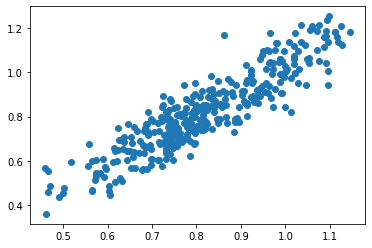

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(clf.predict(X_test), y_test)

In [ ]:
import numpy as np
X_train = np.array(X_train)
X_train

array([[ 6.9738461e+04,  3.0172611e+01,  1.6230786e-01, ...,
         1.2994273e+02,  3.0054461e-02,  1.0260017e+02],
       [ 5.6060023e+04,  2.5552778e+01,  8.5401721e-02, ...,
         6.4696571e+01, -2.5847500e-04,  2.6435402e+01],
       [ 5.0478566e+04,  2.5004150e+01,  1.3108575e-01, ...,
         1.6630031e+02, -2.0277413e-02,  6.5908173e+01],
       ...,
       [ 7.6296078e+04,  2.6051298e+01,  1.6755566e-01, ...,
         6.8538139e+01, -2.8107500e-03,  3.8135670e+01],
       [ 9.3622109e+04,  2.9099094e+01,  3.0513936e-01, ...,
         1.2738395e+03,  4.5897460e-03,  6.8834375e+02],
       [ 6.5680813e+04,  2.3720495e+01,  1.5630737e-01, ...,
         2.2377888e+02,  1.5193356e-02,  1.3801863e+02]])

In [ ]:
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

In [ ]:
from keras.optimizers.optimizer_v2.optimizer_v2 import learning_rate_schedule
layers_list = [1,2,3]
nodes_list = [64,128,256]
batch_sizes = [20,100,200]
lrs = [.01,.001,.0001]
dropouts = [.1,.3,.5]
activations = ['sigmoid','relu']

hps = []
val_losses = []
count = 0

for layers in layers_list:
  for dropout in dropouts:
    for batch_size in batch_sizes:
      for lr in lrs:
        for nodes in nodes_list:
          for activation in activations:
            model = Sequential()
            model.add(Dense(nodes, activation=activation, input_shape=(X_train.shape[1],)))
            if layers == 1:
              model.add(Dense(nodes, activation=activation))
            elif layers == 2:
              model.add(Dense(nodes, activation=activation))
              model.add(Dense(nodes, activation=activation))
            elif layers == 3:
              model.add(Dense(nodes, activation=activation))
              model.add(Dense(nodes, activation=activation))
              model.add(Dense(nodes, activation=activation))
            model.add(Dense(1, activation='linear'))

            # Compile the model
            model.compile(loss='mse',
                          optimizer=keras.optimizers.Adam(lr=lr),
                          metrics=['mse'])

            # Train the model
            history = model.fit(X_train, y_train,
                                batch_size=batch_size,
                                epochs=10,
                                verbose=0,
                                validation_data=(X_val, y_val))
            count += 1
            print("mse:", history.history['val_loss'][-1])
            print("dropout:", dropout, "batch_size:", batch_size, "lr:", lr)
            print("nodes:", nodes, "activation:", activation, "layers:", layers)
            print("models fitted:", count, "/486")
            print("----------------------------------------------")

            hps.append({"dropout" : dropout, 
                        "batch_size" : batch_size,
                        "lr" : lr,
                        "layers" : layers,
                        "nodes" : nodes,
                        "activation" : activation})
            val_losses.append(history.history['val_mse'][-1])

print("The best_hps are:", hps[np.argmin(val_losses)])

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.0543 - mse: 0.0543 - val_loss: 0.0415 - val_mse: 0.0415
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0386 - val_mse: 0.0386
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 8/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0319 - mse: 0.0319 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 8764992.0000 - mse: 8764992.0000 - val_loss: 2343.4712 - val_mse: 2343.4712
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 2844.4688 - mse: 2844.4688 - val_loss: 1626.8558 - val_mse: 1626.8560
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 1358.2689 - mse: 1358.2689 - val_loss: 1528.4828 - val_mse: 1528.4828
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 2418.0952 - mse: 2418.0952 - val_loss: 366.2511 - val_mse: 366.2511
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 468.9027 - mse: 468.9027 - val_loss: 283.9841 - val_mse: 283.9841
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 684.1131 - mse: 684.1131 - val_loss: 342.7037 - val_mse: 342.7037
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 2445.6631 - mse: 2445.6631 - val_loss: 245.5073 - val_mse: 245.5073
Epoch 8/10
98/98 [=====

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 0.1642 - mse: 0.1642 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0616 - val_mse: 0.0616
Epoch 8/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0357 - mse: 0.0357 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 33153058.0000 - mse: 33153058.0000 - val_loss: 1091.0265 - val_mse: 1091.0265
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 732.4048 - mse: 732.4048 - val_loss: 461.7360 - val_mse: 461.7360
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 4300.6455 - mse: 4300.6455 - val_loss: 327.3506 - val_mse: 327.3506
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 530.9529 - mse: 530.9529 - val_loss: 241.7846 - val_mse: 241.7846
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 221.6247 - mse: 221.6247 - val_loss: 197.3272 - val_mse: 197.3272
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 177.8610 - mse: 177.8610 - val_loss: 192.3912 - val_mse: 192.3912
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 145.1258 - mse: 145.1258 - val_loss: 132.9005 - val_mse: 132.9005
Epoch 8/10
98/98 [=============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 0.6512 - mse: 0.6512 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0404 - val_mse: 0.0404
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0330 - mse: 0.0330 - val_loss: 0.0455 - val_mse: 0.0455
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0396 - val_mse: 0.0396
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0390 - val_mse: 0.0390
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0325 - mse: 0.0325 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 32488248.0000 - mse: 32488248.0000 - val_loss: 22.5580 - val_mse: 22.5580
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 154.2811 - mse: 154.2811 - val_loss: 28.9373 - val_mse: 28.9373
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 28.0911 - mse: 28.0911 - val_loss: 29.2961 - val_mse: 29.2961
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 22.1358 - mse: 22.1358 - val_loss: 12.9097 - val_mse: 12.9097
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 15.9384 - mse: 15.9384 - val_loss: 13.7591 - val_mse: 13.7591
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 12.6148 - mse: 12.6148 - val_loss: 10.6579 - val_mse: 10.6579
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 11.7770 - mse: 11.7770 - val_loss: 6.3324 - val_mse: 6.3324
Epoch 8/10
98/98 [==============================] - 0s 5ms/st

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 0.3437 - mse: 0.3437 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 8/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0285 - mse: 0.0285 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 6ms/step - loss: 582842.6250 - mse: 582842.6250 - val_loss: 23159.1211 - val_mse: 23159.1211
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 16650.2812 - mse: 16650.2812 - val_loss: 4274.9922 - val_mse: 4274.9922
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 4172.0645 - mse: 4172.0645 - val_loss: 1920.7036 - val_mse: 1920.7036
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 1998.3973 - mse: 1998.3973 - val_loss: 3128.9580 - val_mse: 3128.9580
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 1587.7324 - mse: 1587.7324 - val_loss: 821.8518 - val_mse: 821.8518
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 1283.6483 - mse: 1283.6483 - val_loss: 283.2557 - val_mse: 283.2557
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 1815.7391 - mse: 1815.7391 - val_loss: 863.2148 - val_mse: 863.2148
Epoch 8/10
98/9

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0314 - mse: 0.0314 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 1114241.1250 - mse: 1114241.1250 - val_loss: 10539.6250 - val_mse: 10539.6250
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 5813.2822 - mse: 5813.2822 - val_loss: 3075.8030 - val_mse: 3075.8030
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 13010.0654 - mse: 13010.0654 - val_loss: 2066.9775 - val_mse: 2066.9775
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 35738.7891 - mse: 35738.7891 - val_loss: 30619.0840 - val_mse: 30619.0840
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 13377.9492 - mse: 13377.9492 - val_loss: 2897.2026 - val_mse: 2897.2026
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 2624.5803 - mse: 2624.5803 - val_loss: 1466.6102 - val_mse: 1466.6102
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 1287.3888 - mse: 1287.3888 - val_loss: 1022.9882 - val_mse: 1022.9882
E

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0379 - mse: 0.0379 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0321 - mse: 0.0321 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 2814251.5000 - mse: 2814252.0000 - val_loss: 1501.2125 - val_mse: 1501.2125
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 5800.7612 - mse: 5800.7612 - val_loss: 2598.4741 - val_mse: 2598.4741
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 57535.4922 - mse: 57535.4922 - val_loss: 4191.5146 - val_mse: 4191.5146
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 4301.0605 - mse: 4301.0605 - val_loss: 562.1905 - val_mse: 562.1905
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 18261.8281 - mse: 18261.8281 - val_loss: 6273.9521 - val_mse: 6273.9521
Epoch 6/10
98/98 [==============================] - 1s 14ms/step - loss: 15230.5332 - mse: 15230.5332 - val_loss: 54100.3438 - val_mse: 54100.3438
Epoch 7/10
98/98 [==============================] - 1s 11ms/step - loss: 7755.3394 - mse: 7755.3394 - val_loss: 2711.8286 - val_mse: 2711.8286
Epo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 4ms/step - loss: 0.3154 - mse: 0.3154 - val_loss: 0.0872 - val_mse: 0.0872
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0481 - mse: 0.0481 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0387 - val_mse: 0.0387
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 8/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0249 - mse: 0.0249 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 31000172.0000 - mse: 31000172.0000 - val_loss: 127001.4688 - val_mse: 127001.4688
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 107286.6953 - mse: 107286.6953 - val_loss: 75067.8750 - val_mse: 75067.8750
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 69515.0625 - mse: 69515.0625 - val_loss: 49468.7812 - val_mse: 49468.7812
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 45181.6758 - mse: 45181.6758 - val_loss: 33379.6289 - val_mse: 33379.6289
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 30937.3125 - mse: 30937.3125 - val_loss: 25443.2324 - val_mse: 25443.2324
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 22668.0625 - mse: 22668.0625 - val_loss: 16979.4023 - val_mse: 16979.4023
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 16613.6934 - mse: 16613.6934 - val_loss: 12108.4834 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 4ms/step - loss: 0.0441 - mse: 0.0441 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 8/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0218 - mse: 0.0218 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 4205988.0000 - mse: 4205988.0000 - val_loss: 15889.0537 - val_mse: 15889.0537
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 9452.8623 - mse: 9452.8623 - val_loss: 1546.1437 - val_mse: 1546.1437
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 2140.5273 - mse: 2140.5273 - val_loss: 969.4283 - val_mse: 969.4283
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 1127.9537 - mse: 1127.9537 - val_loss: 731.1126 - val_mse: 731.1126
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 788.2621 - mse: 788.2621 - val_loss: 728.9149 - val_mse: 728.9149
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 738.7517 - mse: 738.7517 - val_loss: 668.6809 - val_mse: 668.6809
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 653.8251 - mse: 653.8251 - val_loss: 787.6432 - val_mse: 787.6432
Epoch 8/10
98/98 [=======

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 0.5926 - mse: 0.5926 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0206 - mse: 0.0206 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 75825.3984 - mse: 75825.3984 - val_loss: 1523.2853 - val_mse: 1523.2853
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 1276.0664 - mse: 1276.0664 - val_loss: 251.6391 - val_mse: 251.6391
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 451.8600 - mse: 451.8600 - val_loss: 177.8973 - val_mse: 177.8973
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 362.3346 - mse: 362.3346 - val_loss: 209.8895 - val_mse: 209.8895
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 1685.0797 - mse: 1685.0797 - val_loss: 333.8979 - val_mse: 333.8979
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 936.4738 - mse: 936.4738 - val_loss: 154.9668 - val_mse: 154.9668
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 3127.5972 - mse: 3127.5972 - val_loss: 161.2548 - val_mse: 161.2548
Epoch 8/10
98/98 [===============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 11ms/step - loss: 0.2262 - mse: 0.2262 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 2/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 5/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 7/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0304 - mse: 0.0304 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 77681368.0000 - mse: 77681368.0000 - val_loss: 1190318.1250 - val_mse: 1190318.2500
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 2594198.5000 - mse: 2594198.5000 - val_loss: 1142267.0000 - val_mse: 1142267.0000
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 264147.7188 - mse: 264147.7188 - val_loss: 8491.7197 - val_mse: 8491.7197
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 12334.3896 - mse: 12334.3906 - val_loss: 11026.3867 - val_mse: 11026.3867
Epoch 5/10
20/20 [==============================] - 0s 4ms/step - loss: 6463.2476 - mse: 6463.2476 - val_loss: 5656.5386 - val_mse: 5656.5386
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: 4905.6704 - mse: 4905.6709 - val_loss: 4484.7441 - val_mse: 4484.7441
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 4302.6743 - mse: 4302.6743 - val_loss: 3585.4167 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 0.4779 - mse: 0.4779 - val_loss: 0.1378 - val_mse: 0.1378
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0677 - mse: 0.0677 - val_loss: 0.0631 - val_mse: 0.0631
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 6/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 8/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0294 - mse: 0.0294 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 88072256.0000 - mse: 88072256.0000 - val_loss: 266997.0000 - val_mse: 266997.0000
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 452668.5000 - mse: 452668.5000 - val_loss: 70477.4062 - val_mse: 70477.4062
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 40331.3203 - mse: 40331.3203 - val_loss: 35930.7422 - val_mse: 35930.7422
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 4551.9966 - mse: 4551.9966 - val_loss: 2194.5747 - val_mse: 2194.5747
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 1727.4176 - mse: 1727.4176 - val_loss: 1512.4388 - val_mse: 1512.4388
Epoch 6/10
20/20 [==============================] - 0s 5ms/step - loss: 1199.2480 - mse: 1199.2480 - val_loss: 1195.5533 - val_mse: 1195.5533
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 935.1746 - mse: 935.1746 - val_loss: 941.1777 - val_mse: 941.177

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 21ms/step - loss: 2.7876 - mse: 2.7876 - val_loss: 0.5920 - val_mse: 0.5920
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.1402 - mse: 0.1402 - val_loss: 0.0398 - val_mse: 0.0398
Epoch 3/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 8/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0297 - mse: 0.0297 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 234329168.0000 - mse: 234329168.0000 - val_loss: 292645.1250 - val_mse: 292645.1250
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 59961.0469 - mse: 59961.0430 - val_loss: 3775.9392 - val_mse: 3775.9387
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 3307.3501 - mse: 3307.3501 - val_loss: 2218.6694 - val_mse: 2218.6694
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 1728.5276 - mse: 1728.5276 - val_loss: 809.6025 - val_mse: 809.6025
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 542.4902 - mse: 542.4902 - val_loss: 72.9956 - val_mse: 72.9956
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 130.0143 - mse: 130.0143 - val_loss: 75.8696 - val_mse: 75.8696
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 71.6385 - mse: 71.6385 - val_loss: 54.4455 - val_mse: 54.4455
Epoch 8/10
20/20 [====

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 0.1609 - mse: 0.1609 - val_loss: 0.0536 - val_mse: 0.0536
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 6/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0231 - mse: 0.0231 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 347300.3750 - mse: 347300.3750 - val_loss: 36146.3750 - val_mse: 36146.3750
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 30115.1504 - mse: 30115.1504 - val_loss: 16986.3164 - val_mse: 16986.3164
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 10450.4736 - mse: 10450.4727 - val_loss: 7548.8999 - val_mse: 7548.8999
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 4935.9771 - mse: 4935.9771 - val_loss: 3491.8533 - val_mse: 3491.8533
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 2854.1331 - mse: 2854.1331 - val_loss: 2158.0283 - val_mse: 2158.0283
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 3220.9568 - mse: 3220.9568 - val_loss: 1899.4712 - val_mse: 1899.4712
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 3527.9583 - mse: 3527.9583 - val_loss: 1131.7301 - val_mse: 1131.7301
Epoc

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 0.0529 - mse: 0.0529 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0215 - mse: 0.0215 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 22ms/step - loss: 2726238.2500 - mse: 2726238.2500 - val_loss: 1116062.2500 - val_mse: 1116062.2500
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 304349.0312 - mse: 304349.0312 - val_loss: 100712.0234 - val_mse: 100712.0234
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 46172.2617 - mse: 46172.2617 - val_loss: 12930.1348 - val_mse: 12930.1348
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 13974.8984 - mse: 13974.8984 - val_loss: 9296.5801 - val_mse: 9296.5801
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 6710.0986 - mse: 6710.0986 - val_loss: 3159.2612 - val_mse: 3159.2612
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 4702.8359 - mse: 4702.8359 - val_loss: 1319.1698 - val_mse: 1319.1698
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 8870.6426 - mse: 8870.6426 - val_loss: 1851.5063 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.2855 - mse: 0.2855 - val_loss: 0.1251 - val_mse: 0.1251
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0487 - mse: 0.0487 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0200 - val_mse: 0.0200
Epoch 8/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0200 - mse: 0.0200 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 6609441.5000 - mse: 6609441.5000 - val_loss: 1312575.1250 - val_mse: 1312575.1250
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 550516.8125 - mse: 550516.8125 - val_loss: 140812.2188 - val_mse: 140812.2031
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 103828.2969 - mse: 103828.2969 - val_loss: 1792.3201 - val_mse: 1792.3201
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 15709.4219 - mse: 15709.4219 - val_loss: 3011.7029 - val_mse: 3011.7029
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 3485.6062 - mse: 3485.6062 - val_loss: 2250.9194 - val_mse: 2250.9194
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 1167.9602 - mse: 1167.9602 - val_loss: 722.2985 - val_mse: 722.2985
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 817.8188 - mse: 817.8188 - val_loss: 640.9952 - val_mse: 640.9

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 0.1441 - mse: 0.1441 - val_loss: 0.1011 - val_mse: 0.1011
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0610 - mse: 0.0610 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 6/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0277 - mse: 0.0277 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 2357215.0000 - mse: 2357215.0000 - val_loss: 939822.5000 - val_mse: 939822.5000
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 841462.5000 - mse: 841462.5000 - val_loss: 648299.1250 - val_mse: 648299.1250
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 597697.3750 - mse: 597697.3750 - val_loss: 464090.9062 - val_mse: 464090.9062
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 506890.9062 - mse: 506890.9062 - val_loss: 379422.0312 - val_mse: 379422.0312
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 378116.5625 - mse: 378116.5625 - val_loss: 284957.6250 - val_mse: 284957.6250
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 287611.0312 - mse: 287611.0312 - val_loss: 205331.7969 - val_mse: 205331.7969
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 207848.7812 - mse: 207848.7812 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 23ms/step - loss: 0.0551 - mse: 0.0551 - val_loss: 0.0398 - val_mse: 0.0398
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 8/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0247 - mse: 0.0247 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 23ms/step - loss: 3377850.2500 - mse: 3377850.2500 - val_loss: 1168642.1250 - val_mse: 1168642.1250
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 433510.4062 - mse: 433510.4062 - val_loss: 256583.4688 - val_mse: 256583.4688
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 186923.3594 - mse: 186923.3750 - val_loss: 130420.6172 - val_mse: 130420.6172
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 118157.2734 - mse: 118157.2734 - val_loss: 93997.0547 - val_mse: 93997.0547
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 85404.4531 - mse: 85404.4531 - val_loss: 66410.4219 - val_mse: 66410.4219
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 61121.8320 - mse: 61121.8320 - val_loss: 48298.7578 - val_mse: 48298.7578
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 43294.8828 - mse: 43294.8789 - val_loss: 330

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 0.4015 - mse: 0.4015 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0228 - mse: 0.0228 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 52976480.0000 - mse: 52976484.0000 - val_loss: 3064461.2500 - val_mse: 3064461.2500
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 4156986.7500 - mse: 4156986.7500 - val_loss: 83374.6406 - val_mse: 83374.6406
Epoch 3/10
20/20 [==============================] - 0s 11ms/step - loss: 361472.5938 - mse: 361472.5938 - val_loss: 91036.8750 - val_mse: 91036.8750
Epoch 4/10
20/20 [==============================] - 0s 12ms/step - loss: 74994.9688 - mse: 74994.9688 - val_loss: 60090.8867 - val_mse: 60090.8867
Epoch 5/10
20/20 [==============================] - 0s 15ms/step - loss: 41288.3672 - mse: 41288.3672 - val_loss: 38548.5938 - val_mse: 38548.5938
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 37030.4570 - mse: 37030.4570 - val_loss: 38029.9648 - val_mse: 38029.9609
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 34922.7773 - mse: 34922.7812 - val_loss:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 24ms/step - loss: 0.2056 - mse: 0.2056 - val_loss: 0.1015 - val_mse: 0.1015
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0548 - val_mse: 0.0548
Epoch 3/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 5/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0290 - mse: 0.0290 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 36ms/step - loss: 38309340.0000 - mse: 38309340.0000 - val_loss: 3861991.5000 - val_mse: 3861991.5000
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 3045801.2500 - mse: 3045801.2500 - val_loss: 1573246.1250 - val_mse: 1573246.1250
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 470589.6562 - mse: 470589.6562 - val_loss: 119440.0000 - val_mse: 119440.0000
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 67175.0547 - mse: 67175.0547 - val_loss: 19503.1074 - val_mse: 19503.1074
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 30908.9727 - mse: 30908.9707 - val_loss: 7231.5986 - val_mse: 7231.5986
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 12989.5352 - mse: 12989.5352 - val_loss: 5459.2344 - val_mse: 5459.2344
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 6384.6162 - mse: 6384.6162 - val_loss: 3932

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 0.8323 - mse: 0.8323 - val_loss: 0.4699 - val_mse: 0.4699
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 0.1797 - mse: 0.1797 - val_loss: 0.1276 - val_mse: 0.1276
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0745 - mse: 0.0745 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0409 - mse: 0.0409 - val_loss: 0.0396 - val_mse: 0.0396
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0390 - val_mse: 0.0390
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0294 - mse: 0.0294 - va

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 30ms/step - loss: 221539856.0000 - mse: 221539856.0000 - val_loss: 238258.0156 - val_mse: 238258.0156
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 6743288.0000 - mse: 6743288.0000 - val_loss: 129453.4297 - val_mse: 129453.4297
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 916529.5625 - mse: 916529.5625 - val_loss: 206094.5000 - val_mse: 206094.5000
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 177464.5469 - mse: 177464.5469 - val_loss: 10678.3447 - val_mse: 10678.3447
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 14019.4395 - mse: 14019.4395 - val_loss: 4008.1865 - val_mse: 4008.1865
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 6010.9912 - mse: 6010.9912 - val_loss: 3702.7319 - val_mse: 3702.7319
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 3824.5649 - mse: 3824.5649 - val_loss: 4

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 25ms/step - loss: 5.8419 - mse: 5.8419 - val_loss: 2.2996 - val_mse: 2.2996
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 0.8372 - mse: 0.8372 - val_loss: 0.7233 - val_mse: 0.7233
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 0.2434 - mse: 0.2434 - val_loss: 0.2227 - val_mse: 0.2227
Epoch 4/10
10/10 [==============================] - 0s 17ms/step - loss: 0.1131 - mse: 0.1131 - val_loss: 0.0944 - val_mse: 0.0944
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0595 - mse: 0.0595 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 6/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 8/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0309 - mse: 0.0309 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 36ms/step - loss: 809943168.0000 - mse: 809943168.0000 - val_loss: 18682618.0000 - val_mse: 18682618.0000
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 7829665.5000 - mse: 7829664.5000 - val_loss: 128965.6250 - val_mse: 128965.6250
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 483241.5938 - mse: 483241.5938 - val_loss: 298436.0000 - val_mse: 298436.0000
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 101428.2656 - mse: 101428.2656 - val_loss: 817.5834 - val_mse: 817.5834
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 13126.6660 - mse: 13126.6660 - val_loss: 4873.6543 - val_mse: 4873.6543
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 6957.2432 - mse: 6957.2432 - val_loss: 1957.6797 - val_mse: 1957.6797
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 2565.5103 - mse: 2565.5103 - val_loss: 1

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 25ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 8/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0225 - mse: 0.0225 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 24ms/step - loss: 10158538.0000 - mse: 10158538.0000 - val_loss: 3062159.2500 - val_mse: 3062159.2500
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 1786868.7500 - mse: 1786868.7500 - val_loss: 1320150.7500 - val_mse: 1320150.7500
Epoch 3/10
10/10 [==============================] - 0s 6ms/step - loss: 706075.4375 - mse: 706075.3750 - val_loss: 574556.5625 - val_mse: 574556.5625
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 291261.8438 - mse: 291261.8438 - val_loss: 238983.2812 - val_mse: 238983.2812
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 126207.3594 - mse: 126207.3594 - val_loss: 82886.3047 - val_mse: 82886.3047
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 68627.1797 - mse: 68627.1797 - val_loss: 40878.3438 - val_mse: 40878.3438
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 41250.2148 - mse: 41250.2148 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 0.1127 - mse: 0.1127 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0206 - mse: 0.0206 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 27ms/step - loss: 6695149.5000 - mse: 6695149.5000 - val_loss: 1332236.7500 - val_mse: 1332236.7500
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 1840658.8750 - mse: 1840658.8750 - val_loss: 73876.5547 - val_mse: 73876.5547
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 553907.3125 - mse: 553907.3125 - val_loss: 31520.8398 - val_mse: 31520.8379
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 179540.1250 - mse: 179540.1250 - val_loss: 26584.9219 - val_mse: 26584.9180
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 77016.6875 - mse: 77016.6875 - val_loss: 10470.6982 - val_mse: 10470.6982
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 28859.1621 - mse: 28859.1621 - val_loss: 13139.2100 - val_mse: 13139.2100
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 13387.8564 - mse: 13387.8564 - val_loss: 835

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 38ms/step - loss: 0.1456 - mse: 0.1456 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0568 - mse: 0.0568 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 5/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 7/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 8/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0206 - mse: 0.0206 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 28ms/step - loss: 13581307.0000 - mse: 13581307.0000 - val_loss: 9745398.0000 - val_mse: 9745398.0000
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 3318654.0000 - mse: 3318654.0000 - val_loss: 1329051.1250 - val_mse: 1329051.1250
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 1205206.5000 - mse: 1205206.5000 - val_loss: 35626.1328 - val_mse: 35626.1328
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 283579.8125 - mse: 283579.8125 - val_loss: 81424.5469 - val_mse: 81424.5469
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 101480.1016 - mse: 101480.1016 - val_loss: 43165.4609 - val_mse: 43165.4609
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 38357.3438 - mse: 38357.3398 - val_loss: 13989.5479 - val_mse: 13989.5479
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 14833.7812 - mse: 14833.7812 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 2.5510 - mse: 2.5510 - val_loss: 2.4064 - val_mse: 2.4064
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 2.1887 - mse: 2.1887 - val_loss: 2.0614 - val_mse: 2.0614
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 1.8631 - mse: 1.8631 - val_loss: 1.7502 - val_mse: 1.7502
Epoch 4/10
10/10 [==============================] - 0s 6ms/step - loss: 1.5740 - mse: 1.5740 - val_loss: 1.4766 - val_mse: 1.4766
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 1.3200 - mse: 1.3200 - val_loss: 1.2363 - val_mse: 1.2363
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 1.0984 - mse: 1.0984 - val_loss: 1.0301 - val_mse: 1.0301
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 0.9090 - mse: 0.9090 - val_loss: 0.8545 - val_mse: 0.8545
Epoch 8/10
10/10 [==============================] - 0s 7ms/step - loss: 0.7476 - mse: 0.7476 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 29ms/step - loss: 36185432.0000 - mse: 36185432.0000 - val_loss: 23062300.0000 - val_mse: 23062300.0000
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 16018865.0000 - mse: 16018865.0000 - val_loss: 8717219.0000 - val_mse: 8717219.0000
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 5296869.5000 - mse: 5296869.5000 - val_loss: 2279687.0000 - val_mse: 2279687.0000
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 1275476.7500 - mse: 1275476.8750 - val_loss: 556143.5000 - val_mse: 556143.5000
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 535962.9375 - mse: 535963.0000 - val_loss: 459609.7500 - val_mse: 459609.7500
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 583578.4375 - mse: 583578.4375 - val_loss: 484988.3750 - val_mse: 484988.3750
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 557524.1875 - mse:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 31ms/step - loss: 2.1523 - mse: 2.1523 - val_loss: 1.8014 - val_mse: 1.8014
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 1.4601 - mse: 1.4601 - val_loss: 1.1891 - val_mse: 1.1891
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 0.9328 - mse: 0.9328 - val_loss: 0.7424 - val_mse: 0.7424
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.5616 - mse: 0.5616 - val_loss: 0.4423 - val_mse: 0.4423
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3228 - mse: 0.3228 - val_loss: 0.2542 - val_mse: 0.2542
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 0.1803 - mse: 0.1803 - val_loss: 0.1470 - val_mse: 0.1470
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.1021 - mse: 0.1021 - val_loss: 0.0909 - val_mse: 0.0909
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0645 - mse: 0.0645 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 28ms/step - loss: 43767688.0000 - mse: 43767688.0000 - val_loss: 16392517.0000 - val_mse: 16392517.0000
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 7598197.5000 - mse: 7598197.5000 - val_loss: 581090.2500 - val_mse: 581090.2500
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 662238.9375 - mse: 662238.9375 - val_loss: 1542306.0000 - val_mse: 1542306.0000
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 1514852.0000 - mse: 1514852.0000 - val_loss: 1207841.2500 - val_mse: 1207841.1250
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 635279.1250 - mse: 635279.0000 - val_loss: 258463.7656 - val_mse: 258463.7656
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 258160.0469 - mse: 258160.0469 - val_loss: 227729.6406 - val_mse: 227729.6406
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 253191.1094 - mse: 253

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 49ms/step - loss: 1.1108 - mse: 1.1108 - val_loss: 0.4497 - val_mse: 0.4497
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 0.1871 - mse: 0.1871 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0706 - val_mse: 0.0706
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0702 - mse: 0.0702 - val_loss: 0.0556 - val_mse: 0.0556
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0300 - mse: 0.0300 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 31ms/step - loss: 9113592.0000 - mse: 9113592.0000 - val_loss: 4662491.5000 - val_mse: 4662491.5000
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 2989170.2500 - mse: 2989170.2500 - val_loss: 67047.9922 - val_mse: 67047.9922
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 792108.1875 - mse: 792108.1875 - val_loss: 388571.0000 - val_mse: 388571.0000
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 209379.8125 - mse: 209379.8125 - val_loss: 341682.9062 - val_mse: 341682.9062
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 134220.0781 - mse: 134220.0781 - val_loss: 98858.8281 - val_mse: 98858.8281
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 83167.7344 - mse: 83167.7344 - val_loss: 50302.7344 - val_mse: 50302.7344
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 46406.0195 - mse: 46406.0195 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 0.0612 - mse: 0.0612 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0323 - mse: 0.0323 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0316 - mse: 0.0316 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 2825854.5000 - mse: 2825854.5000 - val_loss: 3488.9773 - val_mse: 3488.9773
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 15752.5186 - mse: 15752.5186 - val_loss: 672.6664 - val_mse: 672.6664
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 420.3189 - mse: 420.3189 - val_loss: 163.8005 - val_mse: 163.8005
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 137.1859 - mse: 137.1859 - val_loss: 69.7530 - val_mse: 69.7530
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 213.8529 - mse: 213.8529 - val_loss: 125.7577 - val_mse: 125.7577
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 212.2746 - mse: 212.2746 - val_loss: 50.5315 - val_mse: 50.5315
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 57.4035 - mse: 57.4035 - val_loss: 56.3595 - val_mse: 56.3595
Epoch 8/10
98/98 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.1895 - mse: 0.1895 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0315 - mse: 0.0315 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 36739780.0000 - mse: 36739780.0000 - val_loss: 4803.0498 - val_mse: 4803.0498
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 8014.1392 - mse: 8014.1392 - val_loss: 3839.8667 - val_mse: 3839.8667
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 926.4773 - mse: 926.4773 - val_loss: 209.9826 - val_mse: 209.9826
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 239.9561 - mse: 239.9561 - val_loss: 157.1235 - val_mse: 157.1235
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 205.2126 - mse: 205.2126 - val_loss: 152.5973 - val_mse: 152.5973
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 175.3054 - mse: 175.3054 - val_loss: 227.1662 - val_mse: 227.1662
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 172.0781 - mse: 172.0781 - val_loss: 175.5471 - val_mse: 175.5471
Epoch 8/10
98/98 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.8490 - mse: 0.8490 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0459 - val_mse: 0.0459
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0318 - mse: 0.0318 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 43797120.0000 - mse: 43797120.0000 - val_loss: 26827.4238 - val_mse: 26827.4238
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 1542.3492 - mse: 1542.3492 - val_loss: 65.8782 - val_mse: 65.8782
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 121.6018 - mse: 121.6018 - val_loss: 47.1592 - val_mse: 47.1592
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 62.8541 - mse: 62.8541 - val_loss: 37.5619 - val_mse: 37.5619
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 36.0529 - mse: 36.0529 - val_loss: 40.7094 - val_mse: 40.7094
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 34.2523 - mse: 34.2523 - val_loss: 14.5630 - val_mse: 14.5630
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 32.3125 - mse: 32.3125 - val_loss: 55.2863 - val_mse: 55.2863
Epoch 8/10
98/98 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 0.4830 - mse: 0.4830 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 8/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0293 - mse: 0.0293 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 4ms/step - loss: 30161154.0000 - mse: 30161154.0000 - val_loss: 364678.7500 - val_mse: 364678.7500
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 155521.2812 - mse: 155521.2812 - val_loss: 58108.3633 - val_mse: 58108.3633
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 36937.8242 - mse: 36937.8242 - val_loss: 16989.8496 - val_mse: 16989.8496
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 14075.2129 - mse: 14075.2129 - val_loss: 4761.0811 - val_mse: 4761.0811
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 10331.0283 - mse: 10331.0283 - val_loss: 2864.9097 - val_mse: 2864.9097
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 6758.1074 - mse: 6758.1074 - val_loss: 2551.0454 - val_mse: 2551.0454
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 3296.9585 - mse: 3296.9585 - val_loss: 1732.5385 - val_mse: 1

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 0.1702 - mse: 0.1702 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0258 - val_mse: 0.0258
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0239 - mse: 0.0239 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0268 - mse: 0.0268 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 1542222.0000 - mse: 1542222.0000 - val_loss: 3702.8167 - val_mse: 3702.8167
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 34092.2578 - mse: 34092.2578 - val_loss: 1331.5785 - val_mse: 1331.5785
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 4375.7412 - mse: 4375.7412 - val_loss: 578.5132 - val_mse: 578.5132
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 1898.7603 - mse: 1898.7603 - val_loss: 1005.8164 - val_mse: 1005.8164
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 6112.2407 - mse: 6112.2407 - val_loss: 6082.4644 - val_mse: 6082.4644
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 9619.8154 - mse: 9619.8154 - val_loss: 885.5533 - val_mse: 885.5533
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 2103.2468 - mse: 2103.2468 - val_loss: 345.8999 - val_mse: 345.8999
Epoch 8/10
98/9

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 9ms/step - loss: 0.0584 - mse: 0.0584 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 2/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0466 - val_mse: 0.0466
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 8/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0267 - mse: 0.0267 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 2024650.1250 - mse: 2024650.1250 - val_loss: 4073.4014 - val_mse: 4073.4014
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 2337.0278 - mse: 2337.0278 - val_loss: 1408.8783 - val_mse: 1408.8783
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 777.0909 - mse: 777.0909 - val_loss: 1688.6187 - val_mse: 1688.6187
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 3976.4331 - mse: 3976.4331 - val_loss: 423.1924 - val_mse: 423.1924
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 2501.9092 - mse: 2501.9092 - val_loss: 851.0601 - val_mse: 851.0601
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 25552.7832 - mse: 25552.7832 - val_loss: 11481.0635 - val_mse: 11481.0635
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 9719.9697 - mse: 9719.9697 - val_loss: 598.2070 - val_mse: 598.2070
Epoch 8/10
98/9

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 8ms/step - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0250 - val_mse: 0.0250
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0212 - mse: 0.0212 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 11459413.0000 - mse: 11459412.0000 - val_loss: 42315.8867 - val_mse: 42315.8867
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 101971.7266 - mse: 101971.7266 - val_loss: 15420.7881 - val_mse: 15420.7881
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 65897.0547 - mse: 65897.0547 - val_loss: 10127.8486 - val_mse: 10127.8486
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 40840.9375 - mse: 40840.9375 - val_loss: 4978.2197 - val_mse: 4978.2197
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 28958.0234 - mse: 28958.0234 - val_loss: 2094.4624 - val_mse: 2094.4624
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 18708.4629 - mse: 18708.4629 - val_loss: 1369.6759 - val_mse: 1369.6759
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 12807.0039 - mse: 12807.0039 - val_loss: 1463.1031 - val_mse:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 0.3730 - mse: 0.3730 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0239 - mse: 0.0239 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0240 - val_mse: 0.0240
Epoch 8/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0217 - mse: 0.0217 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 1016624.9375 - mse: 1016624.9375 - val_loss: 38124.0352 - val_mse: 38124.0352
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 19354.1660 - mse: 19354.1660 - val_loss: 5038.9277 - val_mse: 5038.9277
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 4492.1245 - mse: 4492.1245 - val_loss: 2374.9348 - val_mse: 2374.9348
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 2693.4988 - mse: 2693.4988 - val_loss: 1185.1805 - val_mse: 1185.1805
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 1794.1105 - mse: 1794.1102 - val_loss: 950.0229 - val_mse: 950.0229
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 1643.7351 - mse: 1643.7351 - val_loss: 905.5901 - val_mse: 905.5901
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 1246.3218 - mse: 1246.3218 - val_loss: 723.5057 - val_mse: 723.5058
Epoch 8/10
98

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.1519 - mse: 0.1519 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 8/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0201 - mse: 0.0201 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 461935.0000 - mse: 461935.0000 - val_loss: 16808.9277 - val_mse: 16808.9277
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 10522.7012 - mse: 10522.7012 - val_loss: 2820.1362 - val_mse: 2820.1362
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 5300.1777 - mse: 5300.1777 - val_loss: 760.6324 - val_mse: 760.6324
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 2031.2081 - mse: 2031.2081 - val_loss: 406.9069 - val_mse: 406.9069
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 781.3567 - mse: 781.3567 - val_loss: 340.6328 - val_mse: 340.6328
Epoch 6/10
98/98 [==============================] - 1s 8ms/step - loss: 549.4609 - mse: 549.4609 - val_loss: 227.0649 - val_mse: 227.0649
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 670.1460 - mse: 670.1460 - val_loss: 454.2905 - val_mse: 454.2905
Epoch 8/10
98/98 [=======

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 0.4106 - mse: 0.4106 - val_loss: 0.1084 - val_mse: 0.1084
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0548 - mse: 0.0548 - val_loss: 0.0464 - val_mse: 0.0464
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 4/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 8/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0294 - mse: 0.0294 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 28807132.0000 - mse: 28807132.0000 - val_loss: 4867004.5000 - val_mse: 4867004.5000
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 889737.5625 - mse: 889737.5625 - val_loss: 135843.2969 - val_mse: 135843.2969
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 58386.5469 - mse: 58386.5469 - val_loss: 15908.0234 - val_mse: 15908.0234
Epoch 4/10
20/20 [==============================] - 0s 4ms/step - loss: 16813.2598 - mse: 16813.2598 - val_loss: 8263.5342 - val_mse: 8263.5342
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 6558.7466 - mse: 6558.7466 - val_loss: 5326.7222 - val_mse: 5326.7222
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 4772.2676 - mse: 4772.2676 - val_loss: 4259.8145 - val_mse: 4259.8145
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 3859.7820 - mse: 3859.7820 - val_loss: 3495.7905 - val_mse

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.5074 - mse: 0.5074 - val_loss: 0.1605 - val_mse: 0.1605
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0664 - mse: 0.0664 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 8/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0300 - mse: 0.0300 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 97528888.0000 - mse: 97528888.0000 - val_loss: 1024421.8125 - val_mse: 1024421.8125
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 310618.4062 - mse: 310618.4062 - val_loss: 20172.4609 - val_mse: 20172.4609
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 35515.8281 - mse: 35515.8281 - val_loss: 7189.8193 - val_mse: 7189.8193
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 6008.7881 - mse: 6008.7881 - val_loss: 734.1237 - val_mse: 734.1237
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 1224.4927 - mse: 1224.4927 - val_loss: 277.8957 - val_mse: 277.8957
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 565.3275 - mse: 565.3275 - val_loss: 189.9631 - val_mse: 189.9631
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 380.4081 - mse: 380.4081 - val_loss: 154.7237 - val_mse: 154.7237
Epoch

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 3.6334 - mse: 3.6334 - val_loss: 0.6901 - val_mse: 0.6901
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.1608 - mse: 0.1608 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0297 - mse: 0.0297 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 296044608.0000 - mse: 296044544.0000 - val_loss: 496245.5312 - val_mse: 496245.5312
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 149328.2031 - mse: 149328.2031 - val_loss: 2474.1841 - val_mse: 2474.1841
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 12089.9814 - mse: 12089.9824 - val_loss: 1830.6494 - val_mse: 1830.6494
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 2014.6023 - mse: 2014.6023 - val_loss: 1222.0933 - val_mse: 1222.0934
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 1088.0842 - mse: 1088.0842 - val_loss: 915.2404 - val_mse: 915.2404
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 783.6624 - mse: 783.6624 - val_loss: 625.7606 - val_mse: 625.7606
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 542.9614 - mse: 542.9614 - val_loss: 423.3201 - val_mse: 423.3201
Epoch 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 11ms/step - loss: 0.8118 - mse: 0.8118 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0792 - mse: 0.0792 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 4/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0234 - mse: 0.0234 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 896658.0000 - mse: 896657.8750 - val_loss: 196651.8438 - val_mse: 196651.8438
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 92187.9922 - mse: 92187.9922 - val_loss: 29120.7676 - val_mse: 29120.7676
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 16591.1934 - mse: 16591.1934 - val_loss: 8060.2695 - val_mse: 8060.2695
Epoch 4/10
20/20 [==============================] - 0s 4ms/step - loss: 6057.3896 - mse: 6057.3896 - val_loss: 2322.6538 - val_mse: 2322.6538
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 3187.6938 - mse: 3187.6938 - val_loss: 1713.4087 - val_mse: 1713.4087
Epoch 6/10
20/20 [==============================] - 0s 5ms/step - loss: 2146.7788 - mse: 2146.7788 - val_loss: 1383.6971 - val_mse: 1383.6971
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 1788.6965 - mse: 1788.6965 - val_loss: 1343.4281 - val_mse: 1343.4281
Ep

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 54ms/step - loss: 0.3180 - mse: 0.3180 - val_loss: 0.0873 - val_mse: 0.0873
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 8/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0215 - mse: 0.0215 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 3208005.5000 - mse: 3208005.5000 - val_loss: 59709.0859 - val_mse: 59709.0859
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 286423.2188 - mse: 286423.2188 - val_loss: 27573.5508 - val_mse: 27573.5508
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 42107.0000 - mse: 42107.0000 - val_loss: 22384.2441 - val_mse: 22384.2441
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 11412.2949 - mse: 11412.2949 - val_loss: 6120.9160 - val_mse: 6120.9160
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 5524.3066 - mse: 5524.3066 - val_loss: 4098.3838 - val_mse: 4098.3838
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 3415.4448 - mse: 3415.4448 - val_loss: 2255.5466 - val_mse: 2255.5466
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 1823.0520 - mse: 1823.0520 - val_loss: 1298.4177 - val_mse: 1298.4

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.1627 - mse: 0.1627 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0233 - mse: 0.0233 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 9656207.0000 - mse: 9656207.0000 - val_loss: 340832.4062 - val_mse: 340832.4062
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 736924.0625 - mse: 736924.0625 - val_loss: 525625.0000 - val_mse: 525625.0000
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 154593.7656 - mse: 154593.7656 - val_loss: 97735.4531 - val_mse: 97735.4531
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 35220.6641 - mse: 35220.6641 - val_loss: 9468.4561 - val_mse: 9468.4561
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 10775.4375 - mse: 10775.4375 - val_loss: 6385.5918 - val_mse: 6385.5918
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 4751.1870 - mse: 4751.1870 - val_loss: 4371.2070 - val_mse: 4371.2070
Epoch 7/10
20/20 [==============================] - 0s 12ms/step - loss: 2886.2129 - mse: 2886.2129 - val_loss: 1727.6417 - val_ms

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 0.5676 - mse: 0.5676 - val_loss: 0.4319 - val_mse: 0.4319
Epoch 2/10
20/20 [==============================] - 0s 4ms/step - loss: 0.3049 - mse: 0.3049 - val_loss: 0.2244 - val_mse: 0.2244
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 0.1493 - mse: 0.1493 - val_loss: 0.1100 - val_mse: 0.1100
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0716 - mse: 0.0716 - val_loss: 0.0593 - val_mse: 0.0593
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0409 - mse: 0.0409 - val_loss: 0.0397 - val_mse: 0.0397
Epoch 6/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 8/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0267 - mse: 0.0267 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 31738044.0000 - mse: 31738044.0000 - val_loss: 7522837.5000 - val_mse: 7522837.5000
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 2148751.0000 - mse: 2148751.0000 - val_loss: 137506.7188 - val_mse: 137506.7188
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 246851.0938 - mse: 246851.0938 - val_loss: 174708.2188 - val_mse: 174708.2188
Epoch 4/10
20/20 [==============================] - 0s 4ms/step - loss: 91982.9609 - mse: 91982.9609 - val_loss: 63458.1758 - val_mse: 63458.1680
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 66052.0625 - mse: 66052.0625 - val_loss: 60720.8594 - val_mse: 60720.8594
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: 60417.0195 - mse: 60417.0195 - val_loss: 58183.4453 - val_mse: 58183.4453
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 55751.8594 - mse: 55751.8633 - val_loss: 5

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 0.0769 - mse: 0.0769 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0239 - mse: 0.0239 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0232 - mse: 0.0232 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 37199616.0000 - mse: 37199616.0000 - val_loss: 6004164.5000 - val_mse: 6004164.5000
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 1336634.8750 - mse: 1336634.8750 - val_loss: 609754.5625 - val_mse: 609754.5625
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 568073.8750 - mse: 568073.8750 - val_loss: 146610.7656 - val_mse: 146610.7500
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 151696.9062 - mse: 151696.8906 - val_loss: 156298.1094 - val_mse: 156298.1094
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 107371.2344 - mse: 107371.2344 - val_loss: 70128.1562 - val_mse: 70128.1484
Epoch 6/10
20/20 [==============================] - 0s 5ms/step - loss: 61898.8398 - mse: 61898.8398 - val_loss: 52606.6562 - val_mse: 52606.6484
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 49690.7266 - mse: 49690.7266 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.0736 - mse: 0.0736 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 3/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0239 - mse: 0.0239 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0204 - mse: 0.0204 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 20ms/step - loss: 1652601.7500 - mse: 1652601.7500 - val_loss: 580887.7500 - val_mse: 580887.7500
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 187839.3125 - mse: 187839.3125 - val_loss: 105693.9453 - val_mse: 105693.9453
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 52205.4414 - mse: 52205.4414 - val_loss: 31202.5859 - val_mse: 31202.5859
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 26653.2031 - mse: 26653.2031 - val_loss: 17743.9219 - val_mse: 17743.9219
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 13866.2412 - mse: 13866.2412 - val_loss: 9171.5381 - val_mse: 9171.5381
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 7720.0522 - mse: 7720.0522 - val_loss: 5665.7676 - val_mse: 5665.7676
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 4811.0273 - mse: 4811.0273 - val_loss: 3918.5825 - val_mse

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 0.4175 - mse: 0.4175 - val_loss: 0.1520 - val_mse: 0.1520
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0967 - mse: 0.0967 - val_loss: 0.1014 - val_mse: 0.1014
Epoch 3/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0644 - mse: 0.0644 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0370 - mse: 0.0370 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 8/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0296 - mse: 0.0296 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 72313608.0000 - mse: 72313608.0000 - val_loss: 38458984.0000 - val_mse: 38458984.0000
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 11946800.0000 - mse: 11946800.0000 - val_loss: 4063861.2500 - val_mse: 4063861.2500
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 2467121.0000 - mse: 2467121.0000 - val_loss: 366592.0312 - val_mse: 366592.0312
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 795227.7500 - mse: 795227.7500 - val_loss: 10078.5938 - val_mse: 10078.5938
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 311895.2188 - mse: 311895.2188 - val_loss: 35317.1406 - val_mse: 35317.1406
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 127059.5859 - mse: 127059.5859 - val_loss: 62039.3633 - val_mse: 62039.3633
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 56835.3008 - mse: 56835.3008

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 1.0077 - mse: 1.0077 - val_loss: 0.6420 - val_mse: 0.6420
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.2274 - mse: 0.2274 - val_loss: 0.1972 - val_mse: 0.1972
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 0.1123 - mse: 0.1123 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0478 - mse: 0.0478 - val_loss: 0.0526 - val_mse: 0.0526
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 8/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0294 - mse: 0.0294 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 22ms/step - loss: 165548512.0000 - mse: 165548512.0000 - val_loss: 20043962.0000 - val_mse: 20043964.0000
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 11424660.0000 - mse: 11424660.0000 - val_loss: 5287916.0000 - val_mse: 5287916.5000
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 1532153.3750 - mse: 1532153.3750 - val_loss: 805874.2500 - val_mse: 805874.2500
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 246324.5469 - mse: 246324.5469 - val_loss: 107881.9922 - val_mse: 107881.9922
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 100760.0469 - mse: 100760.0469 - val_loss: 6462.6167 - val_mse: 6462.6167
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 23643.4180 - mse: 23643.4180 - val_loss: 20329.5371 - val_mse: 20329.5371
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 9377.8975 - mse: 9377.8975 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 6.6680 - mse: 6.6680 - val_loss: 3.0580 - val_mse: 3.0580
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 1.0136 - mse: 1.0136 - val_loss: 0.8332 - val_mse: 0.8332
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.2717 - mse: 0.2717 - val_loss: 0.2708 - val_mse: 0.2708
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 0.1171 - mse: 0.1171 - val_loss: 0.1182 - val_mse: 0.1182
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0672 - mse: 0.0672 - val_loss: 0.0464 - val_mse: 0.0464
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0419 - mse: 0.0419 - val_loss: 0.0399 - val_mse: 0.0399
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0313 - mse: 0.0313 - 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 62ms/step - loss: 500589120.0000 - mse: 500589120.0000 - val_loss: 8076280.5000 - val_mse: 8076280.5000
Epoch 2/10
10/10 [==============================] - 0s 18ms/step - loss: 1979462.1250 - mse: 1979462.1250 - val_loss: 373159.9375 - val_mse: 373159.9375
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 315945.3750 - mse: 315945.3750 - val_loss: 225777.0625 - val_mse: 225777.0625
Epoch 4/10
10/10 [==============================] - 0s 17ms/step - loss: 80317.5625 - mse: 80317.5625 - val_loss: 2222.4395 - val_mse: 2222.4395
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 18174.3633 - mse: 18174.3633 - val_loss: 15046.0381 - val_mse: 15046.0381
Epoch 6/10
10/10 [==============================] - 0s 16ms/step - loss: 9398.8477 - mse: 9398.8477 - val_loss: 7073.9233 - val_mse: 7073.9233
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 3472.1699 - mse: 3472.1699 - val_loss: 9

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 1.9531 - mse: 1.9531 - val_loss: 0.7031 - val_mse: 0.7031
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.2752 - mse: 0.2752 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0509 - mse: 0.0509 - val_loss: 0.0864 - val_mse: 0.0864
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0876 - mse: 0.0876 - val_loss: 0.0616 - val_mse: 0.0616
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0431 - mse: 0.0431 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 8/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0288 - mse: 0.0288 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 135381200.0000 - mse: 135381200.0000 - val_loss: 10295418.0000 - val_mse: 10295418.0000
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 29231696.0000 - mse: 29231694.0000 - val_loss: 14417136.0000 - val_mse: 14417136.0000
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 4316187.5000 - mse: 4316187.5000 - val_loss: 4949670.0000 - val_mse: 4949670.0000
Epoch 4/10
10/10 [==============================] - 0s 6ms/step - loss: 4338686.5000 - mse: 4338686.5000 - val_loss: 846308.1875 - val_mse: 846308.1875
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 674933.5000 - mse: 674933.5000 - val_loss: 1128080.3750 - val_mse: 1128080.3750
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 658618.4375 - mse: 658618.4375 - val_loss: 265181.1250 - val_mse: 265181.1250
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 355671.6250 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 24ms/step - loss: 0.3160 - mse: 0.3160 - val_loss: 0.1993 - val_mse: 0.1993
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0805 - mse: 0.0805 - val_loss: 0.1063 - val_mse: 0.1063
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0557 - mse: 0.0557 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0233 - mse: 0.0233 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0219 - mse: 0.0219 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 10772923.0000 - mse: 10772923.0000 - val_loss: 6074941.5000 - val_mse: 6074941.5000
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 3130913.0000 - mse: 3130913.0000 - val_loss: 1650357.2500 - val_mse: 1650357.2500
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 804696.9375 - mse: 804696.9375 - val_loss: 107985.0547 - val_mse: 107985.0547
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 307186.7812 - mse: 307186.8125 - val_loss: 291212.6875 - val_mse: 291212.6562
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 119044.5781 - mse: 119044.5781 - val_loss: 6799.2681 - val_mse: 6799.2690
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 39589.1055 - mse: 39589.1055 - val_loss: 36590.9102 - val_mse: 36590.9102
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 15930.9180 - mse: 15930.9180 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 0.2827 - mse: 0.2827 - val_loss: 0.2202 - val_mse: 0.2202
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0952 - mse: 0.0952 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0410 - mse: 0.0410 - val_loss: 0.0421 - val_mse: 0.0421
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0200 - mse: 0.0200 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 41ms/step - loss: 9277750.0000 - mse: 9277751.0000 - val_loss: 4858061.0000 - val_mse: 4858061.0000
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 1975413.8750 - mse: 1975413.8750 - val_loss: 1641225.2500 - val_mse: 1641225.2500
Epoch 3/10
10/10 [==============================] - 0s 17ms/step - loss: 661861.3125 - mse: 661861.3125 - val_loss: 442946.0000 - val_mse: 442946.0000
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 206194.5312 - mse: 206194.5312 - val_loss: 81479.4531 - val_mse: 81479.4531
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 71095.2031 - mse: 71095.2031 - val_loss: 7771.5078 - val_mse: 7771.5073
Epoch 6/10
10/10 [==============================] - 0s 16ms/step - loss: 26162.9316 - mse: 26162.9316 - val_loss: 31377.0312 - val_mse: 31377.0312
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 12897.7012 - mse: 12897.7012 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 3.0219 - mse: 3.0219 - val_loss: 2.8738 - val_mse: 2.8738
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 2.6531 - mse: 2.6531 - val_loss: 2.5207 - val_mse: 2.5207
Epoch 3/10
10/10 [==============================] - 0s 6ms/step - loss: 2.3188 - mse: 2.3188 - val_loss: 2.2010 - val_mse: 2.2010
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 2.0178 - mse: 2.0178 - val_loss: 1.9168 - val_mse: 1.9168
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 1.7493 - mse: 1.7493 - val_loss: 1.6612 - val_mse: 1.6612
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 1.5108 - mse: 1.5108 - val_loss: 1.4345 - val_mse: 1.4345
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 1.2986 - mse: 1.2986 - val_loss: 1.2339 - val_mse: 1.2339
Epoch 8/10
10/10 [==============================] - 0s 7ms/step - loss: 1.1102 - mse: 1.1102 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 27ms/step - loss: 62104544.0000 - mse: 62104544.0000 - val_loss: 39758604.0000 - val_mse: 39758600.0000
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 30490916.0000 - mse: 30490916.0000 - val_loss: 16427622.0000 - val_mse: 16427622.0000
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 11692221.0000 - mse: 11692221.0000 - val_loss: 4695909.5000 - val_mse: 4695909.5000
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 3159881.2500 - mse: 3159881.2500 - val_loss: 768843.3125 - val_mse: 768843.3125
Epoch 5/10
10/10 [==============================] - 0s 6ms/step - loss: 774528.6250 - mse: 774528.6250 - val_loss: 281115.7188 - val_mse: 281115.7188
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 560734.3750 - mse: 560734.3750 - val_loss: 445679.5938 - val_mse: 445679.5938
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 603985.3750 - 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 24ms/step - loss: 0.0662 - mse: 0.0662 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 8/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0225 - mse: 0.0225 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 24ms/step - loss: 27141496.0000 - mse: 27141496.0000 - val_loss: 6087826.5000 - val_mse: 6087826.5000
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 1953701.1250 - mse: 1953701.1250 - val_loss: 1268675.2500 - val_mse: 1268675.2500
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 2216520.0000 - mse: 2216520.0000 - val_loss: 1661254.6250 - val_mse: 1661254.6250
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 1125635.3750 - mse: 1125635.3750 - val_loss: 461022.5625 - val_mse: 461022.5625
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 506594.4062 - mse: 506594.4062 - val_loss: 635277.0000 - val_mse: 635277.0625
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 455973.6875 - mse: 455973.6875 - val_loss: 338995.2500 - val_mse: 338995.2500
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 298875.5938 - mse: 298

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 1.7006 - mse: 1.7006 - val_loss: 0.8839 - val_mse: 0.8839
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.4681 - mse: 0.4681 - val_loss: 0.1536 - val_mse: 0.1536
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0604 - mse: 0.0604 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0475 - mse: 0.0475 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0248 - mse: 0.0248 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 42ms/step - loss: 2488384.0000 - mse: 2488384.0000 - val_loss: 770268.5000 - val_mse: 770268.5000
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 445350.0938 - mse: 445350.0938 - val_loss: 294118.1250 - val_mse: 294118.1250
Epoch 3/10
10/10 [==============================] - 0s 17ms/step - loss: 164405.6875 - mse: 164405.6875 - val_loss: 103508.2578 - val_mse: 103508.2578
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 63270.2969 - mse: 63270.2969 - val_loss: 28440.1738 - val_mse: 28440.1738
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 26244.8555 - mse: 26244.8555 - val_loss: 5309.1797 - val_mse: 5309.1797
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 12027.0059 - mse: 12027.0059 - val_loss: 6061.9131 - val_mse: 6061.9131
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 8306.1348 - mse: 8306.1348 - val_loss: 7369.98

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.0708 - mse: 0.0708 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0305 - mse: 0.0305 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 6ms/step - loss: 5519996.0000 - mse: 5519996.0000 - val_loss: 2138.6689 - val_mse: 2138.6689
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 1042.2365 - mse: 1042.2365 - val_loss: 691.4653 - val_mse: 691.4653
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 1834.6379 - mse: 1834.6379 - val_loss: 183.2536 - val_mse: 183.2536
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 585.3127 - mse: 585.3127 - val_loss: 155.3233 - val_mse: 155.3233
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 1277.7389 - mse: 1277.7389 - val_loss: 814.5240 - val_mse: 814.5240
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 466.7126 - mse: 466.7126 - val_loss: 185.0891 - val_mse: 185.0891
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 200.9885 - mse: 200.9885 - val_loss: 185.7969 - val_mse: 185.7969
Epoch 8/10
98/98 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.1927 - mse: 0.1927 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: 0.0417 - val_mse: 0.0417
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0324 - mse: 0.0324 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 46571088.0000 - mse: 46571088.0000 - val_loss: 16450.6250 - val_mse: 16450.6250
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 6552.8467 - mse: 6552.8467 - val_loss: 862.7571 - val_mse: 862.7571
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 609.3839 - mse: 609.3839 - val_loss: 407.9196 - val_mse: 407.9196
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 190.4234 - mse: 190.4234 - val_loss: 50.3772 - val_mse: 50.3772
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 96.4381 - mse: 96.4381 - val_loss: 79.4164 - val_mse: 79.4164
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 94.6719 - mse: 94.6719 - val_loss: 32.7250 - val_mse: 32.7250
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 70.4007 - mse: 70.4007 - val_loss: 34.1203 - val_mse: 34.1203
Epoch 8/10
98/98 [=========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.7975 - mse: 0.7975 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0317 - mse: 0.0317 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 32352728.0000 - mse: 32352730.0000 - val_loss: 1631.6617 - val_mse: 1631.6617
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 988.4981 - mse: 988.4981 - val_loss: 138.9848 - val_mse: 138.9848
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 211.6967 - mse: 211.6967 - val_loss: 49.0296 - val_mse: 49.0296
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 64.7119 - mse: 64.7119 - val_loss: 17.6953 - val_mse: 17.6953
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 28.7563 - mse: 28.7563 - val_loss: 10.5932 - val_mse: 10.5932
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 18.8410 - mse: 18.8410 - val_loss: 30.3358 - val_mse: 30.3358
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 14.7269 - mse: 14.7269 - val_loss: 9.8284 - val_mse: 9.8284
Epoch 8/10
98/98 [==============================] - 0

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 8/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0291 - mse: 0.0291 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 7203749.0000 - mse: 7203749.0000 - val_loss: 74163.4844 - val_mse: 74163.4922
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 24650.5117 - mse: 24650.5117 - val_loss: 9426.8291 - val_mse: 9426.8291
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 7167.4272 - mse: 7167.4272 - val_loss: 5196.0156 - val_mse: 5196.0156
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 3781.2661 - mse: 3781.2661 - val_loss: 2596.6824 - val_mse: 2596.6824
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 2947.1716 - mse: 2947.1711 - val_loss: 2040.6058 - val_mse: 2040.6058
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 3132.8564 - mse: 3132.8564 - val_loss: 1378.5420 - val_mse: 1378.5419
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 1743.8868 - mse: 1743.8867 - val_loss: 1603.8126 - val_mse: 1603.8126
Epoch 8

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.0925 - mse: 0.0925 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0258 - val_mse: 0.0258
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0307 - mse: 0.0307 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 729516.1250 - mse: 729516.1250 - val_loss: 18157.0762 - val_mse: 18157.0762
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 21924.8516 - mse: 21924.8516 - val_loss: 1522.6936 - val_mse: 1522.6936
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 22348.9180 - mse: 22348.9180 - val_loss: 19483.0430 - val_mse: 19483.0430
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 10641.8516 - mse: 10641.8516 - val_loss: 738.9195 - val_mse: 738.9195
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 979.8010 - mse: 979.8010 - val_loss: 412.5051 - val_mse: 412.5051
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 3468.2224 - mse: 3468.2224 - val_loss: 475.4374 - val_mse: 475.4374
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 1153.9083 - mse: 1153.9083 - val_loss: 261.9786 - val_mse: 261.9786
Epoch 8/10
98

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.0658 - mse: 0.0658 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 8/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0325 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 3427783.7500 - mse: 3427783.7500 - val_loss: 7505.6172 - val_mse: 7505.6172
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 2193.4231 - mse: 2193.4231 - val_loss: 423.8968 - val_mse: 423.8968
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 3704.5188 - mse: 3704.5183 - val_loss: 1631.8650 - val_mse: 1631.8650
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 529.8476 - mse: 529.8476 - val_loss: 146.9581 - val_mse: 146.9581
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 4990.0444 - mse: 4990.0444 - val_loss: 2225.0229 - val_mse: 2225.0229
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 2103.7480 - mse: 2103.7480 - val_loss: 456.0724 - val_mse: 456.0724
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 342.3410 - mse: 342.3410 - val_loss: 776.3402 - val_mse: 776.3402
Epoch 8/10
98/98 [=====

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.1850 - mse: 0.1850 - val_loss: 0.0429 - val_mse: 0.0429
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0323 - mse: 0.0323 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 8/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0242 - mse: 0.0242 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 168057.3906 - mse: 168057.3906 - val_loss: 24985.8906 - val_mse: 24985.8867
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 75189.2109 - mse: 75189.2109 - val_loss: 10251.1016 - val_mse: 10251.1016
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 38099.5430 - mse: 38099.5430 - val_loss: 5830.9976 - val_mse: 5830.9976
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 20752.3965 - mse: 20752.3965 - val_loss: 3889.8699 - val_mse: 3889.8699
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 12664.1016 - mse: 12664.1016 - val_loss: 3081.2568 - val_mse: 3081.2568
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 7188.4351 - mse: 7188.4351 - val_loss: 1426.9174 - val_mse: 1426.9174
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 5176.7070 - mse: 5176.7070 - val_loss: 1452.0820 - val_mse: 1452.0818
E

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.2837 - mse: 0.2837 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 8/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0229 - mse: 0.0229 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 4ms/step - loss: 297940.2188 - mse: 297940.2188 - val_loss: 26193.8125 - val_mse: 26193.8125
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 24049.6211 - mse: 24049.6211 - val_loss: 9538.6816 - val_mse: 9538.6826
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 8024.4429 - mse: 8024.4429 - val_loss: 4534.3770 - val_mse: 4534.3770
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 2888.8364 - mse: 2888.8364 - val_loss: 2173.6235 - val_mse: 2173.6235
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 1702.8735 - mse: 1702.8735 - val_loss: 1307.1628 - val_mse: 1307.1628
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 1248.0464 - mse: 1248.0463 - val_loss: 1339.7501 - val_mse: 1339.7501
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 1013.6721 - mse: 1013.6721 - val_loss: 784.3234 - val_mse: 784.3234
Epoch 8/10


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 14ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0240 - val_mse: 0.0240
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0204 - mse: 0.0204 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 1182882.1250 - mse: 1182882.1250 - val_loss: 7519.9805 - val_mse: 7519.9805
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 6288.0112 - mse: 6288.0112 - val_loss: 3079.7708 - val_mse: 3079.7708
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 2243.6145 - mse: 2243.6145 - val_loss: 979.6183 - val_mse: 979.6183
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 2041.1747 - mse: 2041.1747 - val_loss: 410.7408 - val_mse: 410.7408
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 2612.9688 - mse: 2612.9688 - val_loss: 516.1967 - val_mse: 516.1967
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 497.1883 - mse: 497.1883 - val_loss: 380.0285 - val_mse: 380.0285
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 412.8703 - mse: 412.8703 - val_loss: 236.8291 - val_mse: 236.8291
Epoch 8/10
98/98 [=======

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 0.1924 - mse: 0.1924 - val_loss: 0.1059 - val_mse: 0.1059
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0298 - mse: 0.0298 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 21ms/step - loss: 58505972.0000 - mse: 58505968.0000 - val_loss: 1553332.0000 - val_mse: 1553332.0000
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 1308332.5000 - mse: 1308332.5000 - val_loss: 24969.6719 - val_mse: 24969.6719
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 125010.8516 - mse: 125010.8516 - val_loss: 4967.3320 - val_mse: 4967.3320
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 17996.7969 - mse: 17996.7969 - val_loss: 5196.2842 - val_mse: 5196.2837
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 5439.4824 - mse: 5439.4824 - val_loss: 2770.6199 - val_mse: 2770.6199
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 3478.6921 - mse: 3478.6921 - val_loss: 1905.2991 - val_mse: 1905.2993
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 3028.0847 - mse: 3028.0847 - val_loss: 1807.5551 - val_mse

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 0.8006 - mse: 0.8006 - val_loss: 0.1202 - val_mse: 0.1202
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0817 - mse: 0.0817 - val_loss: 0.0454 - val_mse: 0.0454
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0306 - mse: 0.0306 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 147362576.0000 - mse: 147362576.0000 - val_loss: 8659731.0000 - val_mse: 8659731.0000
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 1849107.7500 - mse: 1849107.7500 - val_loss: 148745.8750 - val_mse: 148745.8750
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 179231.7031 - mse: 179231.7031 - val_loss: 67538.9844 - val_mse: 67538.9844
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 17268.7520 - mse: 17268.7520 - val_loss: 5805.0210 - val_mse: 5805.0210
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 4292.3809 - mse: 4292.3809 - val_loss: 1152.1091 - val_mse: 1152.1091
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 1718.2771 - mse: 1718.2771 - val_loss: 1088.6345 - val_mse: 1088.6345
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 1265.2539 - mse: 1265.2539 - val_loss: 965.2106 - va

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 3.1851 - mse: 3.1851 - val_loss: 0.5572 - val_mse: 0.5572
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.1626 - mse: 0.1626 - val_loss: 0.0959 - val_mse: 0.0959
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0301 - mse: 0.0301 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 22ms/step - loss: 232885264.0000 - mse: 232885264.0000 - val_loss: 1606567.7500 - val_mse: 1606567.7500
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 228846.6875 - mse: 228846.6875 - val_loss: 14062.8535 - val_mse: 14062.8535
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 11506.5449 - mse: 11506.5449 - val_loss: 3213.7861 - val_mse: 3213.7861
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 5315.3110 - mse: 5315.3110 - val_loss: 2237.0242 - val_mse: 2237.0242
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 4604.7549 - mse: 4604.7549 - val_loss: 1386.8544 - val_mse: 1386.8544
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 4449.5063 - mse: 4449.5063 - val_loss: 841.3273 - val_mse: 841.3273
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 1008.2747 - mse: 1008.2747 - val_loss: 427.2892 - val_mse:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 8/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0224 - mse: 0.0224 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 26769736.0000 - mse: 26769736.0000 - val_loss: 674501.2500 - val_mse: 674501.1875
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 2161966.2500 - mse: 2161966.5000 - val_loss: 1098998.5000 - val_mse: 1098998.5000
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 343500.1250 - mse: 343500.1250 - val_loss: 53157.1875 - val_mse: 53157.1875
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 67634.2891 - mse: 67634.2891 - val_loss: 11509.8135 - val_mse: 11509.8135
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 15022.6270 - mse: 15022.6270 - val_loss: 6652.1943 - val_mse: 6652.1943
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 7433.3999 - mse: 7433.3999 - val_loss: 6408.6357 - val_mse: 6408.6357
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 5918.3921 - mse: 5918.3921 - val_loss: 5228.8940 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 0.1228 - mse: 0.1228 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0240 - val_mse: 0.0240
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 6/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0219 - mse: 0.0219 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 1187837.8750 - mse: 1187837.8750 - val_loss: 437917.1250 - val_mse: 437917.1250
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 176887.6875 - mse: 176887.6875 - val_loss: 22712.2930 - val_mse: 22712.2891
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 33101.9766 - mse: 33101.9766 - val_loss: 8092.8867 - val_mse: 8092.8867
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 7454.2373 - mse: 7454.2373 - val_loss: 2475.0295 - val_mse: 2475.0295
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 3962.4656 - mse: 3962.4656 - val_loss: 1880.6606 - val_mse: 1880.6606
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 2059.8977 - mse: 2059.8977 - val_loss: 1338.4181 - val_mse: 1338.4181
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 995.3433 - mse: 995.3433 - val_loss: 637.9249 - val_mse: 637.9249
Ep

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.2307 - mse: 0.2307 - val_loss: 0.0923 - val_mse: 0.0923
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0410 - mse: 0.0410 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0203 - mse: 0.0203 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 11480767.0000 - mse: 11480767.0000 - val_loss: 3078918.2500 - val_mse: 3078918.2500
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 949520.6875 - mse: 949520.6875 - val_loss: 410417.3438 - val_mse: 410417.3438
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 124628.2969 - mse: 124628.2969 - val_loss: 18620.2969 - val_mse: 18620.2969
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 18958.3594 - mse: 18958.3594 - val_loss: 12987.3105 - val_mse: 12987.3105
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 8219.2949 - mse: 8219.2949 - val_loss: 5346.2129 - val_mse: 5346.2129
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 4452.5571 - mse: 4452.5571 - val_loss: 2668.1035 - val_mse: 2668.1035
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 3020.7778 - mse: 3020.7773 - val_loss: 1605.7332 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 4.1788 - mse: 4.1788 - val_loss: 3.8092 - val_mse: 3.8092
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 3.4058 - mse: 3.4058 - val_loss: 3.0902 - val_mse: 3.0902
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 2.7405 - mse: 2.7405 - val_loss: 2.4792 - val_mse: 2.4792
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 2.1886 - mse: 2.1886 - val_loss: 1.9819 - val_mse: 1.9819
Epoch 5/10
20/20 [==============================] - 0s 4ms/step - loss: 1.7306 - mse: 1.7306 - val_loss: 1.5559 - val_mse: 1.5559
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 1.3485 - mse: 1.3485 - val_loss: 1.2119 - val_mse: 1.2119
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 1.0368 - mse: 1.0368 - val_loss: 0.9325 - val_mse: 0.9325
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.7847 - mse: 0.7847 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 12ms/step - loss: 10125125.0000 - mse: 10125125.0000 - val_loss: 2333869.2500 - val_mse: 2333869.0000
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 713057.3125 - mse: 713057.3125 - val_loss: 159757.5938 - val_mse: 159757.5938
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 157374.5781 - mse: 157374.5781 - val_loss: 134340.9062 - val_mse: 134340.9219
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 71606.8281 - mse: 71606.8281 - val_loss: 66710.4609 - val_mse: 66710.4609
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 51876.7031 - mse: 51876.7031 - val_loss: 53313.4375 - val_mse: 53313.4375
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 40578.6523 - mse: 40578.6523 - val_loss: 42395.0195 - val_mse: 42395.0195
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 31734.7637 - mse: 31734.7637 - val_loss: 313

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 2s 25ms/step - loss: 4.1801 - mse: 4.1801 - val_loss: 3.1725 - val_mse: 3.1725
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 2.3774 - mse: 2.3774 - val_loss: 1.7257 - val_mse: 1.7257
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 1.2262 - mse: 1.2262 - val_loss: 0.8568 - val_mse: 0.8568
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 0.5767 - mse: 0.5767 - val_loss: 0.3982 - val_mse: 0.3982
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.2551 - mse: 0.2551 - val_loss: 0.1802 - val_mse: 0.1802
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.1114 - mse: 0.1114 - val_loss: 0.0867 - val_mse: 0.0867
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0548 - mse: 0.0548 - val_loss: 0.0536 - val_mse: 0.0536
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0385 - mse: 0.0385 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 49797.4375 - mse: 49797.4375 - val_loss: 10618.6543 - val_mse: 10618.6553
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 9893.6191 - mse: 9893.6191 - val_loss: 4973.1621 - val_mse: 4973.1621
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 4129.0513 - mse: 4129.0513 - val_loss: 2402.4890 - val_mse: 2402.4890
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 1494.9379 - mse: 1494.9379 - val_loss: 900.8392 - val_mse: 900.8392
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 632.0550 - mse: 632.0550 - val_loss: 516.6367 - val_mse: 516.6367
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 496.7863 - mse: 496.7863 - val_loss: 435.3233 - val_mse: 435.3233
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 442.2656 - mse: 442.2655 - val_loss: 485.2759 - val_mse: 485.2759
Epoch 8/10
20/20 [========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 18ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0198 - mse: 0.0198 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 22626858.0000 - mse: 22626856.0000 - val_loss: 6267968.0000 - val_mse: 6267968.0000
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 2186265.7500 - mse: 2186265.7500 - val_loss: 640072.6250 - val_mse: 640072.6250
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 345484.4375 - mse: 345484.4375 - val_loss: 208883.0312 - val_mse: 208883.0312
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 86801.5234 - mse: 86801.5234 - val_loss: 32379.8926 - val_mse: 32379.8926
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 26164.5684 - mse: 26164.5684 - val_loss: 19224.9336 - val_mse: 19224.9336
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 16175.7705 - mse: 16175.7705 - val_loss: 10427.6787 - val_mse: 10427.6787
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 10874.2637 - mse: 10874.2637 - val_loss: 6

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 21ms/step - loss: 0.3954 - mse: 0.3954 - val_loss: 0.2931 - val_mse: 0.2931
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.1125 - mse: 0.1125 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0515 - val_mse: 0.0515
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0407 - mse: 0.0407 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0296 - mse: 0.0296 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 50ms/step - loss: 75360480.0000 - mse: 75360480.0000 - val_loss: 36792892.0000 - val_mse: 36792888.0000
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 13014280.0000 - mse: 13014281.0000 - val_loss: 8021781.5000 - val_mse: 8021781.5000
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 2564526.2500 - mse: 2564526.2500 - val_loss: 2805632.7500 - val_mse: 2805632.7500
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 1005083.6250 - mse: 1005083.6250 - val_loss: 724988.6875 - val_mse: 724988.6875
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 391173.7500 - mse: 391173.7500 - val_loss: 25998.4863 - val_mse: 25998.4863
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 15088.0732 - mse: 15088.0732 - val_loss: 5626.7368 - val_mse: 5626.7368
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 6446.4229 - mse: 6446

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 0.8533 - mse: 0.8533 - val_loss: 0.5120 - val_mse: 0.5120
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.2003 - mse: 0.2003 - val_loss: 0.0870 - val_mse: 0.0870
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0842 - mse: 0.0842 - val_loss: 0.0405 - val_mse: 0.0405
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0412 - mse: 0.0412 - val_loss: 0.0566 - val_mse: 0.0566
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0370 - val_mse: 0.0370
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 8/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0279 - mse: 0.0279 - va

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 25ms/step - loss: 295160512.0000 - mse: 295160512.0000 - val_loss: 398810.9062 - val_mse: 398810.9062
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 10721328.0000 - mse: 10721328.0000 - val_loss: 635335.6875 - val_mse: 635335.6875
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 2394090.7500 - mse: 2394090.7500 - val_loss: 554612.1875 - val_mse: 554612.1875
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 703101.3750 - mse: 703101.3750 - val_loss: 279730.8750 - val_mse: 279730.8750
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 96120.3828 - mse: 96120.3828 - val_loss: 14475.6230 - val_mse: 14475.6230
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 29538.5703 - mse: 29538.5703 - val_loss: 18023.5645 - val_mse: 18023.5645
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 12570.3740 - mse: 12570.3740 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 30ms/step - loss: 4.9978 - mse: 4.9978 - val_loss: 1.8426 - val_mse: 1.8426
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 0.6640 - mse: 0.6640 - val_loss: 0.3395 - val_mse: 0.3395
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.1608 - mse: 0.1608 - val_loss: 0.0921 - val_mse: 0.0921
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0719 - mse: 0.0719 - val_loss: 0.0560 - val_mse: 0.0560
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0299 - mse: 0.0299 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 28ms/step - loss: 673910272.0000 - mse: 673910272.0000 - val_loss: 8162347.0000 - val_mse: 8162347.0000
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 2430517.5000 - mse: 2430517.5000 - val_loss: 12305.2539 - val_mse: 12305.2539
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 343490.9688 - mse: 343490.9688 - val_loss: 2670.2388 - val_mse: 2670.2388
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 49253.9727 - mse: 49253.9727 - val_loss: 30641.8086 - val_mse: 30641.8086
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 16689.3203 - mse: 16689.3203 - val_loss: 14508.3203 - val_mse: 14508.3203
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 6914.8550 - mse: 6914.8550 - val_loss: 6636.1411 - val_mse: 6636.1411
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 2893.4902 - mse: 2893.4902 - val_loss: 2536.6

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0228 - mse: 0.0228 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 37ms/step - loss: 7748176.0000 - mse: 7748176.0000 - val_loss: 591830.1875 - val_mse: 591830.1875
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 1435028.5000 - mse: 1435028.5000 - val_loss: 30392.8516 - val_mse: 30392.8516
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 501109.5625 - mse: 501109.5625 - val_loss: 25130.1855 - val_mse: 25130.1855
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 201620.2344 - mse: 201620.2344 - val_loss: 57396.9492 - val_mse: 57396.9492
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 91093.4297 - mse: 91093.4297 - val_loss: 66832.5469 - val_mse: 66832.5469
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 43998.3672 - mse: 43998.3672 - val_loss: 39465.7656 - val_mse: 39465.7617
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 21012.4688 - mse: 21012.4688 - val_loss: 147

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 0.5834 - mse: 0.5834 - val_loss: 0.3571 - val_mse: 0.3571
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.2015 - mse: 0.2015 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0816 - mse: 0.0816 - val_loss: 0.0446 - val_mse: 0.0446
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0395 - mse: 0.0395 - val_loss: 0.0406 - val_mse: 0.0406
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0384 - val_mse: 0.0384
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0261 - mse: 0.0261 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 25ms/step - loss: 15151857.0000 - mse: 15151857.0000 - val_loss: 6048833.0000 - val_mse: 6048832.5000
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 3919409.2500 - mse: 3919409.2500 - val_loss: 3172280.5000 - val_mse: 3172280.5000
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 1312406.6250 - mse: 1312406.6250 - val_loss: 442606.7500 - val_mse: 442606.7500
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 368570.9375 - mse: 368570.9375 - val_loss: 123272.6719 - val_mse: 123272.6875
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 176995.4375 - mse: 176995.4375 - val_loss: 157187.6875 - val_mse: 157187.6875
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 76776.1875 - mse: 76776.1875 - val_loss: 7601.5137 - val_mse: 7601.5137
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 29292.9824 - mse: 29292.9824 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 41ms/step - loss: 0.3927 - mse: 0.3927 - val_loss: 0.2617 - val_mse: 0.2617
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.1287 - mse: 0.1287 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0258 - val_mse: 0.0258
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 6/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 8/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0213 - mse: 0.0213 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 33ms/step - loss: 21881576.0000 - mse: 21881576.0000 - val_loss: 295923.5625 - val_mse: 295923.5625
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 4155927.2500 - mse: 4155927.2500 - val_loss: 1696255.1250 - val_mse: 1696255.1250
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 1194148.8750 - mse: 1194148.8750 - val_loss: 1604012.3750 - val_mse: 1604012.3750
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 593717.8750 - mse: 593717.8750 - val_loss: 579468.6875 - val_mse: 579468.6875
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 300002.9375 - mse: 300002.9375 - val_loss: 187821.2188 - val_mse: 187821.2188
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 131422.9219 - mse: 131422.9219 - val_loss: 96526.8906 - val_mse: 96526.8906
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 60603.2578 - mse: 6060

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 0.9122 - mse: 0.9122 - val_loss: 0.8404 - val_mse: 0.8404
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.7302 - mse: 0.7302 - val_loss: 0.6743 - val_mse: 0.6743
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.5746 - mse: 0.5746 - val_loss: 0.5286 - val_mse: 0.5286
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.4434 - mse: 0.4434 - val_loss: 0.4074 - val_mse: 0.4074
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.3392 - mse: 0.3392 - val_loss: 0.3137 - val_mse: 0.3137
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2572 - mse: 0.2572 - val_loss: 0.2385 - val_mse: 0.2385
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.1937 - mse: 0.1937 - val_loss: 0.1835 - val_mse: 0.1835
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.1462 - mse: 0.1462 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 43159728.0000 - mse: 43159728.0000 - val_loss: 21297764.0000 - val_mse: 21297764.0000
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 13682004.0000 - mse: 13682004.0000 - val_loss: 3968638.2500 - val_mse: 3968638.2500
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 2671231.0000 - mse: 2671231.0000 - val_loss: 663430.5625 - val_mse: 663430.5625
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 1452524.5000 - mse: 1452524.5000 - val_loss: 1252852.0000 - val_mse: 1252852.0000
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 1649877.6250 - mse: 1649877.6250 - val_loss: 1044920.5000 - val_mse: 1044920.5000
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 1274458.8750 - mse: 1274458.8750 - val_loss: 601845.0625 - val_mse: 601845.0000
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 1007469.0000

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 2.0923 - mse: 2.0923 - val_loss: 1.7326 - val_mse: 1.7326
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 1.3968 - mse: 1.3968 - val_loss: 1.1262 - val_mse: 1.1262
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.8762 - mse: 0.8762 - val_loss: 0.6850 - val_mse: 0.6850
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.5126 - mse: 0.5126 - val_loss: 0.3955 - val_mse: 0.3955
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.2842 - mse: 0.2842 - val_loss: 0.2205 - val_mse: 0.2205
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.1541 - mse: 0.1541 - val_loss: 0.1259 - val_mse: 0.1259
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0872 - mse: 0.0872 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 8/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0564 - mse: 0.0564 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 2390136.7500 - mse: 2390136.7500 - val_loss: 1029723.8125 - val_mse: 1029723.8125
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 1048945.7500 - mse: 1048945.7500 - val_loss: 442621.0000 - val_mse: 442621.0000
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 486903.7500 - mse: 486903.7500 - val_loss: 524531.1250 - val_mse: 524531.1250
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 293871.0312 - mse: 293871.0312 - val_loss: 238749.1719 - val_mse: 238749.1719
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 180031.3438 - mse: 180031.3438 - val_loss: 163456.3750 - val_mse: 163456.3750
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 108993.7109 - mse: 108993.7109 - val_loss: 79275.6719 - val_mse: 79275.6719
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 61322.5586 - mse: 61322.5586 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 30ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0470 - val_mse: 0.0470
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0202 - mse: 0.0202 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 30ms/step - loss: 7871146.5000 - mse: 7871146.5000 - val_loss: 1513674.7500 - val_mse: 1513674.7500
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 2372608.7500 - mse: 2372608.7500 - val_loss: 1035548.8750 - val_mse: 1035548.8750
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 465754.5938 - mse: 465754.5938 - val_loss: 617840.5625 - val_mse: 617840.5625
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 451633.5312 - mse: 451633.5312 - val_loss: 156706.4531 - val_mse: 156706.4531
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 190713.4062 - mse: 190713.4062 - val_loss: 142830.1875 - val_mse: 142830.1875
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 94394.6875 - mse: 94394.6875 - val_loss: 68266.1016 - val_mse: 68266.1094
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 50351.3984 - mse: 50351.3984

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 9ms/step - loss: 0.0908 - mse: 0.0908 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0506 - val_mse: 0.0506
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0332 - mse: 0.0332 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 1631882.8750 - mse: 1631882.8750 - val_loss: 799.6246 - val_mse: 799.6246
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 1546.9459 - mse: 1546.9459 - val_loss: 220.0931 - val_mse: 220.0931
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 1436.2189 - mse: 1436.2189 - val_loss: 1409.0316 - val_mse: 1409.0316
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 11168.3369 - mse: 11168.3369 - val_loss: 410.2642 - val_mse: 410.2641
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 765.1458 - mse: 765.1459 - val_loss: 312.4050 - val_mse: 312.4050
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 270.2293 - mse: 270.2293 - val_loss: 6.4986 - val_mse: 6.4986
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 48.0065 - mse: 48.0065 - val_loss: 73.0556 - val_mse: 73.0556
Epoch 8/10
98/98 [=================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.1673 - mse: 0.1673 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0436 - val_mse: 0.0436
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0335 - mse: 0.0335 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 33763168.0000 - mse: 33763168.0000 - val_loss: 7238.8955 - val_mse: 7238.8955
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 812.8747 - mse: 812.8747 - val_loss: 100.5407 - val_mse: 100.5407
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 179.7290 - mse: 179.7290 - val_loss: 39.9595 - val_mse: 39.9595
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 166.9756 - mse: 166.9756 - val_loss: 63.5703 - val_mse: 63.5703
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 239.3469 - mse: 239.3469 - val_loss: 59.4226 - val_mse: 59.4226
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 267.6520 - mse: 267.6520 - val_loss: 80.7640 - val_mse: 80.7640
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 217.0809 - mse: 217.0809 - val_loss: 1523.2284 - val_mse: 1523.2284
Epoch 8/10
98/98 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.8913 - mse: 0.8913 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 4/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 5/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 6/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 7/10
98/98 [==============================] - 2s 16ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 8/10
98/98 [==============================] - 1s 12ms/step - loss: 0.0314 - mse: 0.0314 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 154697376.0000 - mse: 154697376.0000 - val_loss: 16404.6426 - val_mse: 16404.6426
Epoch 2/10
98/98 [==============================] - 1s 7ms/step - loss: 19592.5938 - mse: 19592.5938 - val_loss: 1136.8577 - val_mse: 1136.8577
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 717.4882 - mse: 717.4882 - val_loss: 162.6161 - val_mse: 162.6161
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 140.8157 - mse: 140.8157 - val_loss: 189.7013 - val_mse: 189.7013
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 48.6759 - mse: 48.6759 - val_loss: 90.0999 - val_mse: 90.0999
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 59.7829 - mse: 59.7829 - val_loss: 12.2347 - val_mse: 12.2347
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 64.9195 - mse: 64.9195 - val_loss: 12.7335 - val_mse: 12.7335
Epoch 8/10
98/98 [=================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 7ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0239 - mse: 0.0239 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0282 - mse: 0.0282 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 2484350.7500 - mse: 2484350.7500 - val_loss: 3007.6741 - val_mse: 3007.6741
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 3897.7168 - mse: 3897.7168 - val_loss: 632.0806 - val_mse: 632.0806
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 1337.9191 - mse: 1337.9191 - val_loss: 319.8696 - val_mse: 319.8696
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 950.8538 - mse: 950.8538 - val_loss: 202.5059 - val_mse: 202.5059
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 347.7660 - mse: 347.7660 - val_loss: 164.3725 - val_mse: 164.3725
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 3131.1492 - mse: 3131.1492 - val_loss: 162.2268 - val_mse: 162.2268
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 697.6074 - mse: 697.6074 - val_loss: 120.2973 - val_mse: 120.2973
Epoch 8/10
98/98 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.0537 - mse: 0.0537 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0240 - val_mse: 0.0240
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 8/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0307 - mse: 0.0307 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 855473.4375 - mse: 855473.4375 - val_loss: 1611.4049 - val_mse: 1611.4049
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 37353.1445 - mse: 37353.1445 - val_loss: 4567.5161 - val_mse: 4567.5161
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 3734.8513 - mse: 3734.8513 - val_loss: 879.6746 - val_mse: 879.6746
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 1962.5618 - mse: 1962.5618 - val_loss: 389.9025 - val_mse: 389.9025
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 1486.9696 - mse: 1486.9696 - val_loss: 596.2322 - val_mse: 596.2322
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 566.2833 - mse: 566.2833 - val_loss: 141.6028 - val_mse: 141.6028
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 1698.6355 - mse: 1698.6355 - val_loss: 132.7477 - val_mse: 132.7477
Epoch 8/10
98/98 [=====

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 12ms/step - loss: 0.0607 - mse: 0.0607 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0471 - val_mse: 0.0471
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 8/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0275 - mse: 0.0275 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 10ms/step - loss: 1388481.3750 - mse: 1388481.3750 - val_loss: 300.9806 - val_mse: 300.9806
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 5154.4536 - mse: 5154.4531 - val_loss: 102.4009 - val_mse: 102.4009
Epoch 3/10
98/98 [==============================] - 1s 10ms/step - loss: 299.6885 - mse: 299.6885 - val_loss: 52.5982 - val_mse: 52.5982
Epoch 4/10
98/98 [==============================] - 1s 9ms/step - loss: 509.8058 - mse: 509.8058 - val_loss: 219.0858 - val_mse: 219.0858
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 2087.7649 - mse: 2087.7649 - val_loss: 2307.4983 - val_mse: 2307.4983
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 439.6551 - mse: 439.6551 - val_loss: 39.4131 - val_mse: 39.4131
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 86.2548 - mse: 86.2548 - val_loss: 22.4286 - val_mse: 22.4286
Epoch 8/10
98/98 [===================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 1.7471 - mse: 1.7471 - val_loss: 0.6288 - val_mse: 0.6288
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.2415 - mse: 0.2415 - val_loss: 0.0739 - val_mse: 0.0739
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 8/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0284 - mse: 0.0284 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 8ms/step - loss: 6453315.5000 - mse: 6453315.5000 - val_loss: 24936.4609 - val_mse: 24936.4609
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 24388.4785 - mse: 24388.4785 - val_loss: 12459.5234 - val_mse: 12459.5234
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 15328.1104 - mse: 15328.1104 - val_loss: 9879.5586 - val_mse: 9879.5596
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 11338.5068 - mse: 11338.5068 - val_loss: 7807.9941 - val_mse: 7807.9941
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 9325.3438 - mse: 9325.3438 - val_loss: 6612.0669 - val_mse: 6612.0669
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 7499.1040 - mse: 7499.1040 - val_loss: 5386.5464 - val_mse: 5386.5464
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 5863.5645 - mse: 5863.5645 - val_loss: 4099.8911 - val_mse: 4099.8911
E

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 0.2649 - mse: 0.2649 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0225 - mse: 0.0225 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 31844.5059 - mse: 31844.5059 - val_loss: 2636.0833 - val_mse: 2636.0833
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 2429.2761 - mse: 2429.2761 - val_loss: 1084.4652 - val_mse: 1084.4652
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 1211.1284 - mse: 1211.1284 - val_loss: 406.5060 - val_mse: 406.5060
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 394.0026 - mse: 394.0027 - val_loss: 363.6356 - val_mse: 363.6356
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 434.8079 - mse: 434.8079 - val_loss: 283.7299 - val_mse: 283.7299
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 521.3261 - mse: 521.3261 - val_loss: 370.8349 - val_mse: 370.8349
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 587.0320 - mse: 587.0319 - val_loss: 8092.0244 - val_mse: 8092.0244
Epoch 8/10
98/98 [=============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 2/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 3/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 6/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 7/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 8/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0205 - mse: 0.0205 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 1251257.0000 - mse: 1251257.0000 - val_loss: 1773.0413 - val_mse: 1773.0413
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 2151.5151 - mse: 2151.5151 - val_loss: 937.6944 - val_mse: 937.6944
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 843.8284 - mse: 843.8284 - val_loss: 370.2811 - val_mse: 370.2811
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 1547.1882 - mse: 1547.1882 - val_loss: 286.2461 - val_mse: 286.2461
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 822.4205 - mse: 822.4205 - val_loss: 233.8685 - val_mse: 233.8685
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 324.7109 - mse: 324.7109 - val_loss: 292.1852 - val_mse: 292.1852
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 262.5689 - mse: 262.5689 - val_loss: 174.8482 - val_mse: 174.8482
Epoch 8/10
98/98 [=============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 3s 22ms/step - loss: 0.1762 - mse: 0.1762 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0412 - mse: 0.0412 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 8/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0298 - mse: 0.0298 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 18786284.0000 - mse: 18786284.0000 - val_loss: 77240.7734 - val_mse: 77240.7734
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 28875.7500 - mse: 28875.7500 - val_loss: 6893.4326 - val_mse: 6893.4326
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 2899.7361 - mse: 2899.7361 - val_loss: 718.9052 - val_mse: 718.9052
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 492.8854 - mse: 492.8854 - val_loss: 240.1783 - val_mse: 240.1783
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 137.3456 - mse: 137.3456 - val_loss: 65.9198 - val_mse: 65.9198
Epoch 6/10
20/20 [==============================] - 0s 5ms/step - loss: 65.3944 - mse: 65.3944 - val_loss: 35.3080 - val_mse: 35.3080
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 43.2338 - mse: 43.2338 - val_loss: 61.3001 - val_mse: 61.3001
Epoch 8/10
20/20 [==============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 50ms/step - loss: 0.5825 - mse: 0.5825 - val_loss: 0.1402 - val_mse: 0.1402
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0657 - mse: 0.0657 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0303 - mse: 0.0303 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 26ms/step - loss: 157570272.0000 - mse: 157570272.0000 - val_loss: 1090914.3750 - val_mse: 1090914.3750
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 312745.3750 - mse: 312745.3438 - val_loss: 62908.0273 - val_mse: 62908.0273
Epoch 3/10
20/20 [==============================] - 0s 12ms/step - loss: 37991.2891 - mse: 37991.2891 - val_loss: 1243.8383 - val_mse: 1243.8383
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 5303.4624 - mse: 5303.4624 - val_loss: 2806.8538 - val_mse: 2806.8538
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 1475.0455 - mse: 1475.0455 - val_loss: 963.0449 - val_mse: 963.0449
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 823.7592 - mse: 823.7592 - val_loss: 691.7336 - val_mse: 691.7336
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 663.2232 - mse: 663.2232 - val_loss: 500.9087 - val_mse: 500.9

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 20ms/step - loss: 3.4544 - mse: 3.4544 - val_loss: 0.0414 - val_mse: 0.0414
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.1742 - mse: 0.1742 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 8/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0295 - mse: 0.0295 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 19ms/step - loss: 479695840.0000 - mse: 479695840.0000 - val_loss: 120683.8516 - val_mse: 120683.8516
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 22735.5195 - mse: 22735.5176 - val_loss: 4083.5942 - val_mse: 4083.5942
Epoch 3/10
20/20 [==============================] - 0s 11ms/step - loss: 2101.4536 - mse: 2101.4536 - val_loss: 1446.9174 - val_mse: 1446.9174
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 2151.8967 - mse: 2151.8967 - val_loss: 511.7029 - val_mse: 511.7029
Epoch 5/10
20/20 [==============================] - 0s 11ms/step - loss: 462.4033 - mse: 462.4034 - val_loss: 251.8762 - val_mse: 251.8762
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 202.8181 - mse: 202.8181 - val_loss: 188.8583 - val_mse: 188.8583
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 200.7699 - mse: 200.7699 - val_loss: 97.9006 - val_mse: 97.9006
Epoch 8/10

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.0556 - mse: 0.0556 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0232 - mse: 0.0232 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 3015683.7500 - mse: 3015683.7500 - val_loss: 1058772.0000 - val_mse: 1058772.0000
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 268294.5312 - mse: 268294.5312 - val_loss: 45878.8750 - val_mse: 45878.8750
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 35687.1797 - mse: 35687.1797 - val_loss: 22387.2988 - val_mse: 22387.2988
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 14274.8135 - mse: 14274.8135 - val_loss: 10431.1582 - val_mse: 10431.1582
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 8596.4355 - mse: 8596.4355 - val_loss: 6961.5596 - val_mse: 6961.5596
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 6209.7212 - mse: 6209.7212 - val_loss: 5262.7734 - val_mse: 5262.7734
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 4793.2822 - mse: 4793.2822 - val_loss: 3914.4231 - val_mse: 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 23ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 3/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0233 - mse: 0.0233 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0216 - mse: 0.0216 - va

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 5761503.5000 - mse: 5761503.5000 - val_loss: 115299.1641 - val_mse: 115299.1641
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 439080.3125 - mse: 439080.2500 - val_loss: 103504.8203 - val_mse: 103504.8203
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 60808.1016 - mse: 60808.1016 - val_loss: 36797.5469 - val_mse: 36797.5469
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 19867.8340 - mse: 19867.8340 - val_loss: 14197.0986 - val_mse: 14197.0986
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 9637.8867 - mse: 9637.8867 - val_loss: 6440.6333 - val_mse: 6440.6333
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 3254.6614 - mse: 3254.6614 - val_loss: 1877.3989 - val_mse: 1877.3989
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 1687.9840 - mse: 1687.9840 - val_loss: 1439.8721 - val_mse: 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 18ms/step - loss: 0.0886 - mse: 0.0886 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 8/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0208 - mse: 0.0208 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 19ms/step - loss: 5953363.5000 - mse: 5953363.5000 - val_loss: 381072.6875 - val_mse: 381072.6875
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 274663.8125 - mse: 274663.8125 - val_loss: 49611.5547 - val_mse: 49611.5547
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 32644.3594 - mse: 32644.3594 - val_loss: 15113.8916 - val_mse: 15113.8916
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 7680.4419 - mse: 7680.4419 - val_loss: 2653.3557 - val_mse: 2653.3557
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 2489.4810 - mse: 2489.4810 - val_loss: 1934.5692 - val_mse: 1934.5692
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 1322.2396 - mse: 1322.2396 - val_loss: 939.4850 - val_mse: 939.4850
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 797.2383 - mse: 797.2383 - val_loss: 577.5473 - val_mse: 577.5

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 21ms/step - loss: 2.2322 - mse: 2.2322 - val_loss: 1.8873 - val_mse: 1.8873
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 1.5526 - mse: 1.5526 - val_loss: 1.2875 - val_mse: 1.2875
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 1.0360 - mse: 1.0360 - val_loss: 0.8464 - val_mse: 0.8464
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.6642 - mse: 0.6642 - val_loss: 0.5373 - val_mse: 0.5373
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.4112 - mse: 0.4112 - val_loss: 0.3294 - val_mse: 0.3294
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.2462 - mse: 0.2462 - val_loss: 0.1990 - val_mse: 0.1990
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.1458 - mse: 0.1458 - val_loss: 0.1213 - val_mse: 0.1213
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0881 - mse: 0.0881 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 19287750.0000 - mse: 19287750.0000 - val_loss: 2215011.7500 - val_mse: 2215011.7500
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 643877.2500 - mse: 643877.2500 - val_loss: 560713.0000 - val_mse: 560713.0000
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 342147.2188 - mse: 342147.2188 - val_loss: 98532.3516 - val_mse: 98532.3516
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 126329.7188 - mse: 126329.7188 - val_loss: 63106.5664 - val_mse: 63106.5664
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 80205.7344 - mse: 80205.7344 - val_loss: 39071.5664 - val_mse: 39071.5664
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 49715.0547 - mse: 49715.0547 - val_loss: 19230.7070 - val_mse: 19230.7070
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 34397.1914 - mse: 34397.1953 - val_loss: 134

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 1.4386 - mse: 1.4386 - val_loss: 0.7826 - val_mse: 0.7826
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.4190 - mse: 0.4190 - val_loss: 0.1760 - val_mse: 0.1760
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0818 - mse: 0.0818 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0277 - mse: 0.0277 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 663833.6875 - mse: 663833.6875 - val_loss: 260349.2656 - val_mse: 260349.2656
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 70422.9375 - mse: 70422.9375 - val_loss: 31976.3730 - val_mse: 31976.3730
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 13073.5029 - mse: 13073.5029 - val_loss: 6370.7607 - val_mse: 6370.7607
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 3182.2827 - mse: 3182.2827 - val_loss: 2259.1357 - val_mse: 2259.1360
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 1521.3397 - mse: 1521.3396 - val_loss: 848.3187 - val_mse: 848.3187
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 1027.9403 - mse: 1027.9403 - val_loss: 753.3378 - val_mse: 753.3378
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 834.7338 - mse: 834.7339 - val_loss: 651.1165 - val_mse: 651.1165
Epoch 8/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 2s 59ms/step - loss: 0.5432 - mse: 0.5432 - val_loss: 0.0417 - val_mse: 0.0417
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0659 - mse: 0.0659 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 5/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 8/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0251 - mse: 0.0251 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 21ms/step - loss: 221601.4062 - mse: 221601.4062 - val_loss: 27975.3672 - val_mse: 27975.3672
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 11984.0664 - mse: 11984.0664 - val_loss: 4174.1470 - val_mse: 4174.1470
Epoch 3/10
20/20 [==============================] - 0s 12ms/step - loss: 2100.6768 - mse: 2100.6768 - val_loss: 1184.4945 - val_mse: 1184.4945
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 810.6943 - mse: 810.6943 - val_loss: 724.2924 - val_mse: 724.2924
Epoch 5/10
20/20 [==============================] - 0s 11ms/step - loss: 675.0610 - mse: 675.0610 - val_loss: 612.2436 - val_mse: 612.2436
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 700.2753 - mse: 700.2753 - val_loss: 804.5767 - val_mse: 804.5767
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 572.1386 - mse: 572.1386 - val_loss: 507.2238 - val_mse: 507.2238
Epoch 8/10
20/20 [

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 31ms/step - loss: 0.4961 - mse: 0.4961 - val_loss: 0.2557 - val_mse: 0.2557
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 0.1100 - mse: 0.1100 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0516 - mse: 0.0516 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 0.0471 - val_mse: 0.0471
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0295 - mse: 0.0295 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 28ms/step - loss: 43136928.0000 - mse: 43136920.0000 - val_loss: 66576.2188 - val_mse: 66576.2188
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 1189182.7500 - mse: 1189182.7500 - val_loss: 656374.2500 - val_mse: 656374.2500
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 207258.3125 - mse: 207258.3281 - val_loss: 24328.6777 - val_mse: 24328.6777
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 49863.6797 - mse: 49863.6797 - val_loss: 47370.2344 - val_mse: 47370.2344
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 21421.7012 - mse: 21421.7012 - val_loss: 791.0717 - val_mse: 791.0717
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 6434.6577 - mse: 6434.6572 - val_loss: 7331.8545 - val_mse: 7331.8545
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 3067.6584 - mse: 3067.6584 - val_loss: 1125.9701 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 36ms/step - loss: 1.5797 - mse: 1.5797 - val_loss: 0.3262 - val_mse: 0.3262
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 0.2623 - mse: 0.2623 - val_loss: 0.2178 - val_mse: 0.2178
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.1045 - mse: 0.1045 - val_loss: 0.0909 - val_mse: 0.0909
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.0627 - val_mse: 0.0627
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0330 - mse: 0.0330 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0296 - mse: 0.0296 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 40ms/step - loss: 241347360.0000 - mse: 241347360.0000 - val_loss: 2914231.0000 - val_mse: 2914231.0000
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 693350.5625 - mse: 693350.5625 - val_loss: 22199.5684 - val_mse: 22199.5684
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - loss: 37720.2891 - mse: 37720.2891 - val_loss: 5033.5327 - val_mse: 5033.5327
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 2595.5579 - mse: 2595.5579 - val_loss: 1446.5839 - val_mse: 1446.5839
Epoch 5/10
10/10 [==============================] - 0s 16ms/step - loss: 1140.5311 - mse: 1140.5311 - val_loss: 1255.7877 - val_mse: 1255.7877
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 823.8527 - mse: 823.8526 - val_loss: 579.0837 - val_mse: 579.0837
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 513.4230 - mse: 513.4230 - val_loss: 285.4781 - val_mse: 285

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 33ms/step - loss: 6.4282 - mse: 6.4282 - val_loss: 0.0562 - val_mse: 0.0562
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 0.7554 - mse: 0.7554 - val_loss: 0.0515 - val_mse: 0.0515
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 0.2641 - mse: 0.2641 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.1088 - mse: 0.1088 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0562 - mse: 0.0562 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0394 - mse: 0.0394 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0305 - mse: 0.0305 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 29ms/step - loss: 741668480.0000 - mse: 741668480.0000 - val_loss: 6671020.0000 - val_mse: 6671020.0000
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 1649607.6250 - mse: 1649607.6250 - val_loss: 168772.4219 - val_mse: 168772.4219
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 138974.2344 - mse: 138974.2344 - val_loss: 85522.0312 - val_mse: 85522.0312
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 66642.5703 - mse: 66642.5703 - val_loss: 50938.4102 - val_mse: 50938.4102
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 33570.6055 - mse: 33570.6055 - val_loss: 1806.4969 - val_mse: 1806.4969
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 8974.1602 - mse: 8974.1602 - val_loss: 7303.6348 - val_mse: 7303.6348
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 3192.3650 - mse: 3192.3650 - val_loss: 233

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 24ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0237 - mse: 0.0237 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 17063818.0000 - mse: 17063818.0000 - val_loss: 4545159.5000 - val_mse: 4545159.5000
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 2484435.0000 - mse: 2484435.2500 - val_loss: 1610837.3750 - val_mse: 1610837.3750
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 802927.8750 - mse: 802927.8750 - val_loss: 602741.2500 - val_mse: 602741.2500
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 278969.4375 - mse: 278969.4375 - val_loss: 116049.4609 - val_mse: 116049.4609
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 121633.1719 - mse: 121633.1719 - val_loss: 53586.2539 - val_mse: 53586.2539
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 71572.6094 - mse: 71572.6094 - val_loss: 49613.2656 - val_mse: 49613.2656
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 43743.6016 - mse: 43743.6016 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 27ms/step - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0225 - mse: 0.0225 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 42ms/step - loss: 3375198.7500 - mse: 3375198.5000 - val_loss: 4839.2607 - val_mse: 4839.2607
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 526182.5000 - mse: 526182.5000 - val_loss: 289232.5625 - val_mse: 289232.5625
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 170896.2969 - mse: 170896.2969 - val_loss: 216018.4062 - val_mse: 216018.4062
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 75979.6406 - mse: 75979.6406 - val_loss: 45362.0156 - val_mse: 45362.0156
Epoch 5/10
10/10 [==============================] - 0s 16ms/step - loss: 27038.3457 - mse: 27038.3457 - val_loss: 11220.7832 - val_mse: 11220.7832
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 11726.7490 - mse: 11726.7490 - val_loss: 4540.5796 - val_mse: 4540.5796
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 5105.7671 - mse: 5105.7671 - val_loss: 2639.1309

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 36ms/step - loss: 0.1043 - mse: 0.1043 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 6/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 8/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0207 - mse: 0.0207 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 31ms/step - loss: 9744668.0000 - mse: 9744667.0000 - val_loss: 4573896.5000 - val_mse: 4573896.5000
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 1428987.7500 - mse: 1428987.7500 - val_loss: 1159619.1250 - val_mse: 1159619.0000
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 431581.3125 - mse: 431581.3125 - val_loss: 262738.3125 - val_mse: 262738.3125
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 100155.1719 - mse: 100155.1719 - val_loss: 43948.4648 - val_mse: 43948.4648
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 33787.5586 - mse: 33787.5586 - val_loss: 9440.6387 - val_mse: 9440.6387
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 12560.3994 - mse: 12560.3994 - val_loss: 7509.7915 - val_mse: 7509.7915
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 3146.5635 - mse: 3146.5635 - val_loss:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 0.1027 - mse: 0.1027 - val_loss: 0.0651 - val_mse: 0.0651
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0514 - mse: 0.0514 - val_loss: 0.0370 - val_mse: 0.0370
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0281 - mse: 0.0281 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 28ms/step - loss: 9942212.0000 - mse: 9942212.0000 - val_loss: 3640688.7500 - val_mse: 3640688.7500
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 1613040.6250 - mse: 1613040.6250 - val_loss: 60786.6328 - val_mse: 60786.6328
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 127613.0156 - mse: 127613.0156 - val_loss: 341791.6875 - val_mse: 341791.6875
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 301800.4688 - mse: 301800.4688 - val_loss: 151720.4844 - val_mse: 151720.4844
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 58373.0469 - mse: 58373.0469 - val_loss: 9228.8916 - val_mse: 9228.8916
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 24997.1543 - mse: 24997.1543 - val_loss: 23248.2090 - val_mse: 23248.2090
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 24921.2676 - mse: 24921.2676 - val_loss: 8

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 35ms/step - loss: 0.6785 - mse: 0.6785 - val_loss: 0.4376 - val_mse: 0.4376
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 0.2738 - mse: 0.2738 - val_loss: 0.1497 - val_mse: 0.1497
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0824 - mse: 0.0824 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 8/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0299 - mse: 0.0299 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 37ms/step - loss: 173424.3906 - mse: 173424.3906 - val_loss: 81760.4609 - val_mse: 81760.4688
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 44318.1836 - mse: 44318.1836 - val_loss: 35796.0078 - val_mse: 35796.0117
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 21478.5000 - mse: 21478.5000 - val_loss: 5359.3926 - val_mse: 5359.3926
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 9300.2031 - mse: 9300.2031 - val_loss: 5560.2729 - val_mse: 5560.2729
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 5967.4595 - mse: 5967.4595 - val_loss: 5339.4507 - val_mse: 5339.4507
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 5009.9902 - mse: 5009.9902 - val_loss: 4308.0791 - val_mse: 4308.0791
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 3915.4658 - mse: 3915.4661 - val_loss: 3420.8503 - val_mse: 3420.850

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 35ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 3/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0231 - mse: 0.0231 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 33ms/step - loss: 3654318.5000 - mse: 3654318.5000 - val_loss: 1154620.1250 - val_mse: 1154620.1250
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 577216.3750 - mse: 577216.3750 - val_loss: 510498.6875 - val_mse: 510498.6875
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 210695.5625 - mse: 210695.5625 - val_loss: 213930.4375 - val_mse: 213930.4375
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 83222.5938 - mse: 83222.5938 - val_loss: 75134.1875 - val_mse: 75134.1875
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 32106.9238 - mse: 32106.9238 - val_loss: 15233.2090 - val_mse: 15233.2090
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 10334.1904 - mse: 10334.1904 - val_loss: 1589.8085 - val_mse: 1589.8085
Epoch 7/10
10/10 [==============================] - 0s 16ms/step - loss: 3988.9678 - mse: 3988.9678 - val_loss: 744

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.0557 - mse: 0.0557 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 8/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0322 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 7488252.0000 - mse: 7488252.0000 - val_loss: 346.6164 - val_mse: 346.6164
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 5001.4146 - mse: 5001.4146 - val_loss: 533.1251 - val_mse: 533.1251
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 1381.2546 - mse: 1381.2546 - val_loss: 217.9712 - val_mse: 217.9712
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 321.0080 - mse: 321.0080 - val_loss: 132.4872 - val_mse: 132.4872
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 238.3499 - mse: 238.3499 - val_loss: 550.7902 - val_mse: 550.7902
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 230.4027 - mse: 230.4027 - val_loss: 193.1711 - val_mse: 193.1711
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 166.8676 - mse: 166.8676 - val_loss: 55.9199 - val_mse: 55.9199
Epoch 8/10
98/98 [=================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.1449 - mse: 0.1449 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0387 - val_mse: 0.0387
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0396 - val_mse: 0.0396
Epoch 8/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0313 - mse: 0.0313 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 14865124.0000 - mse: 14865124.0000 - val_loss: 850.6841 - val_mse: 850.6841
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 720.5955 - mse: 720.5955 - val_loss: 167.4486 - val_mse: 167.4486
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 140.3891 - mse: 140.3891 - val_loss: 60.2027 - val_mse: 60.2027
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 130.5514 - mse: 130.5514 - val_loss: 121.1998 - val_mse: 121.1998
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 90.5039 - mse: 90.5039 - val_loss: 90.0453 - val_mse: 90.0453
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 84.9617 - mse: 84.9617 - val_loss: 268.5325 - val_mse: 268.5325
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 94.3313 - mse: 94.3313 - val_loss: 22.8115 - val_mse: 22.8115
Epoch 8/10
98/98 [=============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 12ms/step - loss: 0.6748 - mse: 0.6748 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0389 - val_mse: 0.0389
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 8/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0311 - mse: 0.0311 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 73740664.0000 - mse: 73740664.0000 - val_loss: 932.4243 - val_mse: 932.4243
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 3484.1873 - mse: 3484.1873 - val_loss: 4433.6089 - val_mse: 4433.6089
Epoch 3/10
98/98 [==============================] - 1s 9ms/step - loss: 5227.5347 - mse: 5227.5347 - val_loss: 141.2479 - val_mse: 141.2479
Epoch 4/10
98/98 [==============================] - 1s 9ms/step - loss: 547.3765 - mse: 547.3765 - val_loss: 612.9386 - val_mse: 612.9386
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 50354.7812 - mse: 50354.7812 - val_loss: 1768.1991 - val_mse: 1768.1991
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 6388.9790 - mse: 6388.9790 - val_loss: 146.1764 - val_mse: 146.1764
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 225.2835 - mse: 225.2835 - val_loss: 4.1303 - val_mse: 4.1303
Epoch 8/10
98/98 [=======

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0284 - mse: 0.0284 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 2526143.2500 - mse: 2526143.2500 - val_loss: 14843.9258 - val_mse: 14843.9258
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 13246.0713 - mse: 13246.0713 - val_loss: 3479.5786 - val_mse: 3479.5786
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 10453.5039 - mse: 10453.5039 - val_loss: 462.7549 - val_mse: 462.7549
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 4149.4312 - mse: 4149.4312 - val_loss: 1170.4862 - val_mse: 1170.4862
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 8635.9297 - mse: 8635.9297 - val_loss: 388.0969 - val_mse: 388.0969
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 2156.2415 - mse: 2156.2415 - val_loss: 105.8161 - val_mse: 105.8161
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 718.8989 - mse: 718.8989 - val_loss: 145.6158 - val_mse: 145.6158
Epoch 8/10
98/9

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 7ms/step - loss: 0.0953 - mse: 0.0953 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 8/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0273 - mse: 0.0273 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 741240.2500 - mse: 741240.2500 - val_loss: 1382.3690 - val_mse: 1382.3690
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 1224.1592 - mse: 1224.1592 - val_loss: 451.7285 - val_mse: 451.7285
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 3313.5259 - mse: 3313.5259 - val_loss: 2544.3237 - val_mse: 2544.3237
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 29229.4004 - mse: 29229.4004 - val_loss: 7595.2173 - val_mse: 7595.2173
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 2662.5142 - mse: 2662.5142 - val_loss: 1206.8586 - val_mse: 1206.8586
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 519.4189 - mse: 519.4189 - val_loss: 332.7199 - val_mse: 332.7199
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 308.2911 - mse: 308.2911 - val_loss: 101.8078 - val_mse: 101.8078
Epoch 8/10
98/98 [===

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 8/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0329 - mse: 0.0329 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 1560886.8750 - mse: 1560886.8750 - val_loss: 4569.8589 - val_mse: 4569.8594
Epoch 2/10
98/98 [==============================] - 1s 7ms/step - loss: 20929.9336 - mse: 20929.9336 - val_loss: 15686.2393 - val_mse: 15686.2402
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 3517.1062 - mse: 3517.1062 - val_loss: 369.2197 - val_mse: 369.2197
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 145.4442 - mse: 145.4442 - val_loss: 67.8327 - val_mse: 67.8327
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 98.4876 - mse: 98.4876 - val_loss: 67.6781 - val_mse: 67.6781
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 130.7188 - mse: 130.7188 - val_loss: 38.1565 - val_mse: 38.1565
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 229.7290 - mse: 229.7290 - val_loss: 414.8184 - val_mse: 414.8184
Epoch 8/10
98/98 [===============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0216 - mse: 0.0216 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 17339904.0000 - mse: 17339904.0000 - val_loss: 76268.2344 - val_mse: 76268.2344
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 63028.1016 - mse: 63028.1016 - val_loss: 29589.5742 - val_mse: 29589.5742
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 31856.9023 - mse: 31856.9023 - val_loss: 12621.5459 - val_mse: 12621.5459
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 14669.2041 - mse: 14669.2041 - val_loss: 5825.6353 - val_mse: 5825.6353
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 7892.4009 - mse: 7892.4019 - val_loss: 3289.4927 - val_mse: 3289.4927
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 4503.7749 - mse: 4503.7749 - val_loss: 2770.0779 - val_mse: 2770.0779
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 3303.5090 - mse: 3303.5090 - val_loss: 2025.6982 - val_mse: 2025.69

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.2622 - mse: 0.2622 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 8/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0227 - mse: 0.0227 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 5ms/step - loss: 390348.1562 - mse: 390348.1562 - val_loss: 14428.4453 - val_mse: 14428.4453
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 9888.9336 - mse: 9888.9336 - val_loss: 5491.8916 - val_mse: 5491.8916
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 5158.9634 - mse: 5158.9634 - val_loss: 3370.1843 - val_mse: 3370.1843
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 1643.7788 - mse: 1643.7788 - val_loss: 1602.3997 - val_mse: 1602.3997
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 1219.0491 - mse: 1219.0491 - val_loss: 2469.0437 - val_mse: 2469.0437
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 905.5274 - mse: 905.5274 - val_loss: 1068.3738 - val_mse: 1068.3738
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 883.8228 - mse: 883.8228 - val_loss: 884.1895 - val_mse: 884.1895
Epoch 8/10
98/98 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 5/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 6/10
98/98 [==============================] - 1s 11ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 7/10
98/98 [==============================] - 1s 10ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 8/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0202 - mse: 0.0202 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 10ms/step - loss: 302575.4375 - mse: 302575.4375 - val_loss: 397.0163 - val_mse: 397.0162
Epoch 2/10
98/98 [==============================] - 1s 7ms/step - loss: 1530.1019 - mse: 1530.1019 - val_loss: 180.9697 - val_mse: 180.9697
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 659.6284 - mse: 659.6284 - val_loss: 202.8306 - val_mse: 202.8306
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 215.6700 - mse: 215.6700 - val_loss: 108.9998 - val_mse: 108.9998
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 242.2875 - mse: 242.2876 - val_loss: 271.9995 - val_mse: 271.9995
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 2928.7126 - mse: 2928.7126 - val_loss: 264.1017 - val_mse: 264.1017
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 2925.2859 - mse: 2925.2859 - val_loss: 104.9678 - val_mse: 104.9678
Epoch 8/10
98/98 [==============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 22ms/step - loss: 0.7136 - mse: 0.7136 - val_loss: 0.0476 - val_mse: 0.0476
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0728 - mse: 0.0728 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0293 - mse: 0.0293 - va

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 22ms/step - loss: 16809458.0000 - mse: 16809458.0000 - val_loss: 74137.7891 - val_mse: 74137.7891
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 34204.8477 - mse: 34204.8438 - val_loss: 3785.6667 - val_mse: 3785.6667
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 8248.3438 - mse: 8248.3447 - val_loss: 6337.2827 - val_mse: 6337.2827
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 1837.2876 - mse: 1837.2876 - val_loss: 887.8995 - val_mse: 887.8995
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 485.7126 - mse: 485.7126 - val_loss: 250.4356 - val_mse: 250.4356
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 198.5458 - mse: 198.5458 - val_loss: 146.2426 - val_mse: 146.2426
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 90.0960 - mse: 90.0960 - val_loss: 79.9652 - val_mse: 79.9652
Epoch 8/10
20/20 [====

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.5301 - mse: 0.5301 - val_loss: 0.1747 - val_mse: 0.1747
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0654 - mse: 0.0654 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0296 - mse: 0.0296 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 19ms/step - loss: 53317320.0000 - mse: 53317320.0000 - val_loss: 8576.9746 - val_mse: 8576.9756
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 24464.8223 - mse: 24464.8203 - val_loss: 640.7241 - val_mse: 640.7241
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 3096.1660 - mse: 3096.1660 - val_loss: 1199.7080 - val_mse: 1199.7080
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 356.7831 - mse: 356.7831 - val_loss: 223.2604 - val_mse: 223.2604
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 143.8059 - mse: 143.8059 - val_loss: 37.1991 - val_mse: 37.1991
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 59.1413 - mse: 59.1413 - val_loss: 44.4363 - val_mse: 44.4363
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 43.5234 - mse: 43.5234 - val_loss: 47.6591 - val_mse: 47.6591
Epoch 8/10
20/20 [===============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 2s 23ms/step - loss: 3.1506 - mse: 3.1506 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.1544 - mse: 0.1544 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 5/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0296 - mse: 0.0296 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 20ms/step - loss: 386406752.0000 - mse: 386406752.0000 - val_loss: 247820.9375 - val_mse: 247820.9375
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 50150.9023 - mse: 50150.9023 - val_loss: 8299.4961 - val_mse: 8299.4961
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 4082.4937 - mse: 4082.4937 - val_loss: 1668.8685 - val_mse: 1668.8685
Epoch 4/10
20/20 [==============================] - 0s 12ms/step - loss: 1119.3557 - mse: 1119.3558 - val_loss: 370.0567 - val_mse: 370.0567
Epoch 5/10
20/20 [==============================] - 0s 11ms/step - loss: 448.2891 - mse: 448.2891 - val_loss: 528.2908 - val_mse: 528.2908
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 387.3945 - mse: 387.3945 - val_loss: 234.6633 - val_mse: 234.6633
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 230.4081 - mse: 230.4081 - val_loss: 90.8188 - val_mse: 90.8188
Epoch 8/10

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0408 - val_mse: 0.0408
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0270 - mse: 0.0270 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 25ms/step - loss: 969578.5000 - mse: 969578.5000 - val_loss: 240822.3750 - val_mse: 240822.3750
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 70250.2344 - mse: 70250.2344 - val_loss: 5374.1118 - val_mse: 5374.1118
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 10848.6982 - mse: 10848.6982 - val_loss: 4533.1406 - val_mse: 4533.1406
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 3042.8137 - mse: 3042.8137 - val_loss: 1844.5624 - val_mse: 1844.5624
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 1818.6962 - mse: 1818.6962 - val_loss: 1194.8798 - val_mse: 1194.8798
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 1192.3536 - mse: 1192.3536 - val_loss: 999.5522 - val_mse: 999.5522
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 921.4798 - mse: 921.4798 - val_loss: 729.0687 - val_mse: 729.0687
Epoch 8/10

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 0.1888 - mse: 0.1888 - val_loss: 0.0869 - val_mse: 0.0869
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0419 - mse: 0.0419 - val_loss: 0.0407 - val_mse: 0.0407
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0215 - mse: 0.0215 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 3487826.5000 - mse: 3487826.5000 - val_loss: 224215.9844 - val_mse: 224215.9844
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 216522.8594 - mse: 216522.8438 - val_loss: 71376.9062 - val_mse: 71376.9062
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 39633.2383 - mse: 39633.2383 - val_loss: 20101.1816 - val_mse: 20101.1816
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 10455.1836 - mse: 10455.1836 - val_loss: 5790.2573 - val_mse: 5790.2573
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 11294.4277 - mse: 11294.4277 - val_loss: 2940.3936 - val_mse: 2940.3936
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 7688.0361 - mse: 7688.0356 - val_loss: 1571.3590 - val_mse: 1571.3590
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 10420.9658 - mse: 10420.9648 - val_loss: 573.8983 - val_mse: 5

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 18ms/step - loss: 0.0723 - mse: 0.0723 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 6/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 8/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0233 - mse: 0.0233 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 20ms/step - loss: 7229635.0000 - mse: 7229635.0000 - val_loss: 1350558.1250 - val_mse: 1350558.1250
Epoch 2/10
20/20 [==============================] - 0s 16ms/step - loss: 399345.0312 - mse: 399345.0312 - val_loss: 53260.5781 - val_mse: 53260.5781
Epoch 3/10
20/20 [==============================] - 0s 15ms/step - loss: 29564.5137 - mse: 29564.5137 - val_loss: 11839.5410 - val_mse: 11839.5410
Epoch 4/10
20/20 [==============================] - 0s 16ms/step - loss: 5101.7476 - mse: 5101.7476 - val_loss: 1750.0072 - val_mse: 1750.0072
Epoch 5/10
20/20 [==============================] - 0s 17ms/step - loss: 899.1504 - mse: 899.1504 - val_loss: 466.8490 - val_mse: 466.8490
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 216.5108 - mse: 216.5108 - val_loss: 180.6929 - val_mse: 180.6929
Epoch 7/10
20/20 [==============================] - 0s 15ms/step - loss: 114.4427 - mse: 114.4427 - val_loss: 139.9447 - val_mse: 139.9447


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 1.1145 - mse: 1.1145 - val_loss: 0.8774 - val_mse: 0.8774
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.6632 - mse: 0.6632 - val_loss: 0.5034 - val_mse: 0.5034
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 0.3643 - mse: 0.3643 - val_loss: 0.2710 - val_mse: 0.2710
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 0.1885 - mse: 0.1885 - val_loss: 0.1422 - val_mse: 0.1422
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0967 - mse: 0.0967 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0540 - mse: 0.0540 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0313 - mse: 0.0313 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 6485904.5000 - mse: 6485905.0000 - val_loss: 60367.8828 - val_mse: 60367.8828
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 376890.8750 - mse: 376890.8750 - val_loss: 91697.3125 - val_mse: 91697.3125
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 66103.8516 - mse: 66103.8516 - val_loss: 66763.9297 - val_mse: 66763.9297
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 47064.2812 - mse: 47064.2812 - val_loss: 34626.2969 - val_mse: 34626.2969
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 40496.3789 - mse: 40496.3789 - val_loss: 33471.4570 - val_mse: 33471.4570
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 36725.7852 - mse: 36725.7852 - val_loss: 30389.9082 - val_mse: 30389.9082
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 34416.6758 - mse: 34416.6758 - val_loss: 28576.9414 - va

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 0.5348 - mse: 0.5348 - val_loss: 0.1817 - val_mse: 0.1817
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0705 - mse: 0.0705 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0300 - mse: 0.0300 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 92002984.0000 - mse: 92002984.0000 - val_loss: 21492410.0000 - val_mse: 21492410.0000
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 5708524.5000 - mse: 5708524.5000 - val_loss: 416162.9062 - val_mse: 416162.9062
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 821073.5625 - mse: 821073.5625 - val_loss: 317862.5625 - val_mse: 317862.5625
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 180757.5781 - mse: 180757.5781 - val_loss: 184404.3906 - val_mse: 184404.3906
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 130788.8672 - mse: 130788.8672 - val_loss: 120458.6406 - val_mse: 120458.6406
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 104627.3594 - mse: 104627.3594 - val_loss: 105593.3125 - val_mse: 105593.3125
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 90550.3984 - mse: 90550.

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 18ms/step - loss: 0.5765 - mse: 0.5765 - val_loss: 0.0387 - val_mse: 0.0387
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0672 - mse: 0.0672 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0237 - mse: 0.0237 - 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 18ms/step - loss: 2530404.5000 - mse: 2530404.5000 - val_loss: 255401.5000 - val_mse: 255401.5000
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 224821.2031 - mse: 224821.2031 - val_loss: 41228.5469 - val_mse: 41228.5469
Epoch 3/10
20/20 [==============================] - 0s 11ms/step - loss: 23829.7773 - mse: 23829.7773 - val_loss: 12270.5566 - val_mse: 12270.5566
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 5100.8257 - mse: 5100.8257 - val_loss: 1650.3379 - val_mse: 1650.3379
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 1675.9835 - mse: 1675.9835 - val_loss: 793.2585 - val_mse: 793.2585
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 919.5896 - mse: 919.5896 - val_loss: 604.8941 - val_mse: 604.8941
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 713.9913 - mse: 713.9913 - val_loss: 456.8011 - val_mse: 456.8011
Ep

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 34ms/step - loss: 0.2449 - mse: 0.2449 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0688 - mse: 0.0688 - val_loss: 0.0681 - val_mse: 0.0681
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0295 - mse: 0.0295 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 30ms/step - loss: 14311988.0000 - mse: 14311988.0000 - val_loss: 722835.6250 - val_mse: 722835.6250
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 219480.9688 - mse: 219480.9688 - val_loss: 4088.0466 - val_mse: 4088.0466
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 31797.1641 - mse: 31797.1641 - val_loss: 29753.5391 - val_mse: 29753.5391
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 13363.6855 - mse: 13363.6855 - val_loss: 1327.7443 - val_mse: 1327.7443
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 4430.4043 - mse: 4430.4043 - val_loss: 5652.8110 - val_mse: 5652.8110
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 2211.1379 - mse: 2211.1377 - val_loss: 921.1241 - val_mse: 921.1241
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 925.8367 - mse: 925.8367 - val_loss: 436.3171 - val_mse: 436.3

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 33ms/step - loss: 0.9599 - mse: 0.9599 - val_loss: 0.1575 - val_mse: 0.1575
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.1828 - mse: 0.1828 - val_loss: 0.1788 - val_mse: 0.1788
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0864 - mse: 0.0864 - val_loss: 0.0686 - val_mse: 0.0686
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0478 - mse: 0.0478 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 8/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0296 - mse: 0.0296 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 28ms/step - loss: 186391168.0000 - mse: 186391168.0000 - val_loss: 67810.6094 - val_mse: 67810.6094
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 595402.0625 - mse: 595402.0625 - val_loss: 417426.1250 - val_mse: 417426.1250
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 106648.1797 - mse: 106648.1797 - val_loss: 37676.3047 - val_mse: 37676.3047
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 4802.1191 - mse: 4802.1196 - val_loss: 547.0048 - val_mse: 547.0048
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 562.1033 - mse: 562.1033 - val_loss: 591.1909 - val_mse: 591.1909
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 809.4368 - mse: 809.4368 - val_loss: 666.0525 - val_mse: 666.0525
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 845.5339 - mse: 845.5339 - val_loss: 731.1655 - val_mse: 731.165

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 35ms/step - loss: 7.6455 - mse: 7.6455 - val_loss: 0.0567 - val_mse: 0.0567
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 0.6055 - mse: 0.6055 - val_loss: 0.1080 - val_mse: 0.1080
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 0.2133 - mse: 0.2133 - val_loss: 0.1143 - val_mse: 0.1143
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0941 - mse: 0.0941 - val_loss: 0.0601 - val_mse: 0.0601
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0569 - mse: 0.0569 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0306 - mse: 0.0306 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 37ms/step - loss: 659966784.0000 - mse: 659966784.0000 - val_loss: 967987.5625 - val_mse: 967987.5625
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 325190.0938 - mse: 325190.0938 - val_loss: 70969.1797 - val_mse: 70969.1797
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - loss: 71285.2188 - mse: 71285.2188 - val_loss: 29974.8516 - val_mse: 29974.8555
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 16742.2383 - mse: 16742.2383 - val_loss: 11546.7891 - val_mse: 11546.7891
Epoch 5/10
10/10 [==============================] - 0s 23ms/step - loss: 3930.0710 - mse: 3930.0710 - val_loss: 1474.0532 - val_mse: 1474.0532
Epoch 6/10
10/10 [==============================] - 0s 21ms/step - loss: 1063.2695 - mse: 1063.2695 - val_loss: 272.2420 - val_mse: 272.2420
Epoch 7/10
10/10 [==============================] - 0s 20ms/step - loss: 466.7914 - mse: 466.7914 - val_loss: 300.6665 - val_ms

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 38ms/step - loss: 0.0740 - mse: 0.0740 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0239 - mse: 0.0239 - va

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 28ms/step - loss: 3601466.5000 - mse: 3601466.5000 - val_loss: 411277.5938 - val_mse: 411277.5938
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 527594.5000 - mse: 527594.5000 - val_loss: 181244.1250 - val_mse: 181244.1250
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 171479.9844 - mse: 171480.0156 - val_loss: 117733.5625 - val_mse: 117733.5625
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 63778.0938 - mse: 63778.0938 - val_loss: 51708.5117 - val_mse: 51708.5117
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 25282.3125 - mse: 25282.3125 - val_loss: 21878.9844 - val_mse: 21878.9844
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 10529.0156 - mse: 10529.0156 - val_loss: 6113.9360 - val_mse: 6113.9360
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 4172.9790 - mse: 4172.9790 - val_loss: 1930.72

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 25ms/step - loss: 1.3298 - mse: 1.3298 - val_loss: 0.3467 - val_mse: 0.3467
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.4214 - mse: 0.4214 - val_loss: 0.0846 - val_mse: 0.0846
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0741 - mse: 0.0741 - val_loss: 0.1395 - val_mse: 0.1395
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0685 - mse: 0.0685 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0266 - mse: 0.0266 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 25ms/step - loss: 7561766.5000 - mse: 7561766.5000 - val_loss: 41817.1641 - val_mse: 41817.1719
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 1298743.1250 - mse: 1298743.1250 - val_loss: 775651.3125 - val_mse: 775651.3125
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 402529.2188 - mse: 402529.2188 - val_loss: 396284.2812 - val_mse: 396284.2812
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 188253.5469 - mse: 188253.5469 - val_loss: 28803.2637 - val_mse: 28803.2637
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 68497.7500 - mse: 68497.7500 - val_loss: 5516.2773 - val_mse: 5516.2773
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 22375.4570 - mse: 22375.4570 - val_loss: 11349.6084 - val_mse: 11349.6084
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 8682.3789 - mse: 8682.3789 - val_loss: 660

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 29ms/step - loss: 0.1579 - mse: 0.1579 - val_loss: 0.0606 - val_mse: 0.0606
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0592 - mse: 0.0592 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 8/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0223 - mse: 0.0223 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 36ms/step - loss: 15166283.0000 - mse: 15166283.0000 - val_loss: 7181436.0000 - val_mse: 7181436.0000
Epoch 2/10
10/10 [==============================] - 0s 22ms/step - loss: 2260909.5000 - mse: 2260909.5000 - val_loss: 942292.3125 - val_mse: 942292.3125
Epoch 3/10
10/10 [==============================] - 0s 23ms/step - loss: 656592.1250 - mse: 656592.1250 - val_loss: 204547.2969 - val_mse: 204547.2969
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 143572.0781 - mse: 143572.0781 - val_loss: 148381.1875 - val_mse: 148381.1875
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 80615.4688 - mse: 80615.4688 - val_loss: 2984.8599 - val_mse: 2984.8599
Epoch 6/10
10/10 [==============================] - 0s 21ms/step - loss: 21472.5137 - mse: 21472.5156 - val_loss: 22976.6680 - val_mse: 22976.6680
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 9547.9443 - mse: 9547.9443 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 31ms/step - loss: 0.3351 - mse: 0.3351 - val_loss: 0.2850 - val_mse: 0.2850
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.2199 - mse: 0.2199 - val_loss: 0.1841 - val_mse: 0.1841
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 0.1362 - mse: 0.1362 - val_loss: 0.1150 - val_mse: 0.1150
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0825 - mse: 0.0825 - val_loss: 0.0722 - val_mse: 0.0722
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0288 - mse: 0.0288 - va

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 23ms/step - loss: 240200464.0000 - mse: 240200464.0000 - val_loss: 195145840.0000 - val_mse: 195145840.0000
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 169800176.0000 - mse: 169800176.0000 - val_loss: 132053920.0000 - val_mse: 132053920.0000
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 109960160.0000 - mse: 109960160.0000 - val_loss: 79055296.0000 - val_mse: 79055296.0000
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 62326612.0000 - mse: 62326612.0000 - val_loss: 40994256.0000 - val_mse: 40994256.0000
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 30726322.0000 - mse: 30726322.0000 - val_loss: 18123830.0000 - val_mse: 18123830.0000
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 12523338.0000 - mse: 12523338.0000 - val_loss: 5959672.0000 - val_mse: 5959672.0000
Epoch 7/10
10/10 [==============================] - 0

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 100ms/step - loss: 0.4103 - mse: 0.4103 - val_loss: 0.2467 - val_mse: 0.2467
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 0.1423 - mse: 0.1423 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 3/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0412 - mse: 0.0412 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0279 - mse: 0.0279

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 39ms/step - loss: 83703656.0000 - mse: 83703656.0000 - val_loss: 34144364.0000 - val_mse: 34144364.0000
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 16506842.0000 - mse: 16506842.0000 - val_loss: 1800999.1250 - val_mse: 1800999.1250
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 632109.9375 - mse: 632109.9375 - val_loss: 1427842.7500 - val_mse: 1427842.7500
Epoch 4/10
10/10 [==============================] - 0s 17ms/step - loss: 1844981.2500 - mse: 1844981.2500 - val_loss: 1452398.8750 - val_mse: 1452398.8750
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 702032.4375 - mse: 702032.4375 - val_loss: 84258.7344 - val_mse: 84258.7344
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 47233.4414 - mse: 47233.4492 - val_loss: 86706.2500 - val_mse: 86706.2500
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 112440.5078 - mse:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 55ms/step - loss: 0.2187 - mse: 0.2187 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 2/10
10/10 [==============================] - 0s 22ms/step - loss: 0.0543 - mse: 0.0543 - val_loss: 0.0636 - val_mse: 0.0636
Epoch 3/10
10/10 [==============================] - 0s 27ms/step - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 4/10
10/10 [==============================] - 0s 25ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 5/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 7/10
10/10 [==============================] - 0s 24ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 8/10
10/10 [==============================] - 0s 24ms/step - loss: 0.0262 - mse: 0.0262 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 34ms/step - loss: 2322227.0000 - mse: 2322227.0000 - val_loss: 121513.2031 - val_mse: 121513.2031
Epoch 2/10
10/10 [==============================] - 0s 18ms/step - loss: 426200.5625 - mse: 426200.5625 - val_loss: 65965.4375 - val_mse: 65965.4375
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - loss: 167644.8438 - mse: 167644.8438 - val_loss: 82907.8281 - val_mse: 82907.8281
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 81284.6172 - mse: 81284.6172 - val_loss: 79849.7422 - val_mse: 79849.7422
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 32223.0527 - mse: 32223.0527 - val_loss: 7592.7529 - val_mse: 7592.7529
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 6364.2402 - mse: 6364.2402 - val_loss: 5103.6650 - val_mse: 5103.6650
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 3912.0020 - mse: 3912.0020 - val_loss: 1098.5289 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.1117 - mse: 0.1117 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 8/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0324 - mse: 0.0324 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 6827969.0000 - mse: 6827969.0000 - val_loss: 4170.6646 - val_mse: 4170.6646
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 862.9668 - mse: 862.9668 - val_loss: 190.5586 - val_mse: 190.5586
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 238.8885 - mse: 238.8885 - val_loss: 127.9266 - val_mse: 127.9266
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 1068.1267 - mse: 1068.1267 - val_loss: 282.5511 - val_mse: 282.5511
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 362.4407 - mse: 362.4407 - val_loss: 72.9934 - val_mse: 72.9934
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 204.4276 - mse: 204.4276 - val_loss: 366.6433 - val_mse: 366.6433
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 150.8113 - mse: 150.8113 - val_loss: 70.8274 - val_mse: 70.8274
Epoch 8/10
98/98 [===================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.1364 - mse: 0.1364 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 8/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0349 - mse: 0.0349 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 16509809.0000 - mse: 16509809.0000 - val_loss: 213.7704 - val_mse: 213.7704
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 1522.4099 - mse: 1522.4099 - val_loss: 176.6631 - val_mse: 176.6631
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 1628.3999 - mse: 1628.3999 - val_loss: 69.4513 - val_mse: 69.4513
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 112.3289 - mse: 112.3289 - val_loss: 79.1423 - val_mse: 79.1423
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 71.0105 - mse: 71.0105 - val_loss: 26.3525 - val_mse: 26.3525
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 93.6975 - mse: 93.6975 - val_loss: 49.9169 - val_mse: 49.9169
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 95.2828 - mse: 95.2828 - val_loss: 31.5582 - val_mse: 31.5582
Epoch 8/10
98/98 [=============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.6485 - mse: 0.6485 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0339 - mse: 0.0339 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 26283200.0000 - mse: 26283200.0000 - val_loss: 95.2633 - val_mse: 95.2633
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 29.7059 - mse: 29.7059 - val_loss: 11.8047 - val_mse: 11.8047
Epoch 3/10
98/98 [==============================] - 1s 9ms/step - loss: 20.2211 - mse: 20.2211 - val_loss: 11.0713 - val_mse: 11.0713
Epoch 4/10
98/98 [==============================] - 1s 9ms/step - loss: 11.0710 - mse: 11.0710 - val_loss: 8.7480 - val_mse: 8.7480
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 13.2950 - mse: 13.2950 - val_loss: 7.9717 - val_mse: 7.9717
Epoch 6/10
98/98 [==============================] - 1s 9ms/step - loss: 23.6634 - mse: 23.6634 - val_loss: 21.6730 - val_mse: 21.6730
Epoch 7/10
98/98 [==============================] - 1s 8ms/step - loss: 19.0256 - mse: 19.0256 - val_loss: 12.3507 - val_mse: 12.3507
Epoch 8/10
98/98 [==============================] - 1s 6ms/step -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.2430 - mse: 0.2430 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0250 - mse: 0.0250 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 346084.2188 - mse: 346084.1875 - val_loss: 5477.1904 - val_mse: 5477.1904
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 3072.7830 - mse: 3072.7830 - val_loss: 920.5524 - val_mse: 920.5524
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 1126.7428 - mse: 1126.7428 - val_loss: 1646.7250 - val_mse: 1646.7250
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 548.0607 - mse: 548.0607 - val_loss: 282.3333 - val_mse: 282.3333
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 500.8133 - mse: 500.8133 - val_loss: 178.4085 - val_mse: 178.4085
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 348.4041 - mse: 348.4041 - val_loss: 148.4322 - val_mse: 148.4322
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 269.9606 - mse: 269.9606 - val_loss: 163.1064 - val_mse: 163.1064
Epoch 8/10
98/98 [=============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.2325 - mse: 0.2325 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0287 - mse: 0.0287 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 684816.8125 - mse: 684816.8125 - val_loss: 2090.3179 - val_mse: 2090.3179
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 20807.9668 - mse: 20807.9668 - val_loss: 19830.9160 - val_mse: 19830.9160
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 5870.6738 - mse: 5870.6738 - val_loss: 8133.0356 - val_mse: 8133.0356
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 2809.4131 - mse: 2809.4131 - val_loss: 17210.7168 - val_mse: 17210.7168
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 2744.4644 - mse: 2744.4646 - val_loss: 631.8224 - val_mse: 631.8224
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 612.3975 - mse: 612.3975 - val_loss: 696.7036 - val_mse: 696.7036
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 828.8078 - mse: 828.8078 - val_loss: 2026.7638 - val_mse: 2026.7638
Epoch 8/10
98/9

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.2051 - mse: 0.2051 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 8/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0279 - mse: 0.0279 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
98/98 [==============================] - 2s 10ms/step - loss: 2102757.0000 - mse: 2102757.0000 - val_loss: 1120.0219 - val_mse: 1120.0219
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 19086.6230 - mse: 19086.6211 - val_loss: 173.3357 - val_mse: 173.3357
Epoch 3/10
98/98 [==============================] - 1s 9ms/step - loss: 615.2236 - mse: 615.2236 - val_loss: 206.1069 - val_mse: 206.1069
Epoch 4/10
98/98 [==============================] - 1s 10ms/step - loss: 417.7761 - mse: 417.7761 - val_loss: 111.5263 - val_mse: 111.5263
Epoch 5/10
98/98 [==============================] - 1s 9ms/step - loss: 229.0314 - mse: 229.0314 - val_loss: 222.8138 - val_mse: 222.8138
Epoch 6/10
98/98 [==============================] - 1s 9ms/step - loss: 160.0153 - mse: 160.0153 - val_loss: 230.1119 - val_mse: 230.1119
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 201.2087 - mse: 201.2087 - val_loss: 65.4098 - val_mse: 65.4098
Epoch 8/10
98/98 [==

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.5206 - mse: 0.5206 - val_loss: 0.0868 - val_mse: 0.0868
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0381 - mse: 0.0381 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0277 - mse: 0.0277 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 8ms/step - loss: 4305105.5000 - mse: 4305105.5000 - val_loss: 161187.4375 - val_mse: 161187.4375
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 109231.2109 - mse: 109231.2109 - val_loss: 73957.7422 - val_mse: 73957.7422
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 39709.9922 - mse: 39709.9922 - val_loss: 12485.6416 - val_mse: 12485.6416
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 10861.8721 - mse: 10861.8721 - val_loss: 6261.4219 - val_mse: 6261.4219
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 6593.7949 - mse: 6593.7954 - val_loss: 3985.1260 - val_mse: 3985.1260
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 4681.7627 - mse: 4681.7627 - val_loss: 3127.7786 - val_mse: 3127.7786
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 3600.1931 - mse: 3600.1931 - val_loss: 2382.4631 - val_mse: 2382.

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.1358 - mse: 0.1358 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0256 - mse: 0.0256 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 9ms/step - loss: 16308.9775 - mse: 16308.9775 - val_loss: 3309.8235 - val_mse: 3309.8235
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 869.8380 - mse: 869.8380 - val_loss: 302.9636 - val_mse: 302.9636
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 655.2912 - mse: 655.2911 - val_loss: 201.2051 - val_mse: 201.2051
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 360.0129 - mse: 360.0129 - val_loss: 890.2659 - val_mse: 890.2659
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 259.8490 - mse: 259.8490 - val_loss: 120.7398 - val_mse: 120.7397
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 183.4297 - mse: 183.4297 - val_loss: 115.4382 - val_mse: 115.4382
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 251.8590 - mse: 251.8590 - val_loss: 237.6010 - val_mse: 237.6010
Epoch 8/10
98/98 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 9ms/step - loss: 0.0383 - mse: 0.0383 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 2/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 8/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0211 - mse: 0.0211 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 1354477.1250 - mse: 1354477.1250 - val_loss: 1341.1753 - val_mse: 1341.1753
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 892.8080 - mse: 892.8080 - val_loss: 400.4681 - val_mse: 400.4681
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 561.9115 - mse: 561.9115 - val_loss: 363.3843 - val_mse: 363.3843
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 406.3293 - mse: 406.3293 - val_loss: 233.8145 - val_mse: 233.8145
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 304.0048 - mse: 304.0048 - val_loss: 178.5387 - val_mse: 178.5387
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 166.0302 - mse: 166.0302 - val_loss: 118.5289 - val_mse: 118.5289
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 138.9578 - mse: 138.9578 - val_loss: 103.9688 - val_mse: 103.9688
Epoch 8/10
98/98 [=================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 1.0963 - mse: 1.0963 - val_loss: 0.2466 - val_mse: 0.2466
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0814 - mse: 0.0814 - val_loss: 0.0466 - val_mse: 0.0466
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0297 - mse: 0.0297 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 32057078.0000 - mse: 32057078.0000 - val_loss: 281467.1875 - val_mse: 281467.1875
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 56597.0039 - mse: 56597.0039 - val_loss: 13659.8926 - val_mse: 13659.8926
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 5615.9575 - mse: 5615.9575 - val_loss: 3500.4766 - val_mse: 3500.4766
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 1660.0420 - mse: 1660.0420 - val_loss: 1755.8394 - val_mse: 1755.8394
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 929.7292 - mse: 929.7292 - val_loss: 1275.1447 - val_mse: 1275.1447
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 810.0554 - mse: 810.0554 - val_loss: 1210.2679 - val_mse: 1210.2679
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 683.6823 - mse: 683.6823 - val_loss: 1102.3140 - val_mse: 1102.3140
Epoch 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.5381 - mse: 0.5381 - val_loss: 0.1666 - val_mse: 0.1666
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0627 - mse: 0.0627 - val_loss: 0.0438 - val_mse: 0.0438
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0300 - mse: 0.0300 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 48024468.0000 - mse: 48024468.0000 - val_loss: 5433.0898 - val_mse: 5433.0898
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 11053.0459 - mse: 11053.0459 - val_loss: 1110.6685 - val_mse: 1110.6685
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 456.4180 - mse: 456.4180 - val_loss: 216.1350 - val_mse: 216.1350
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 72.0981 - mse: 72.0981 - val_loss: 24.1289 - val_mse: 24.1289
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 24.3298 - mse: 24.3298 - val_loss: 15.0565 - val_mse: 15.0565
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 14.1921 - mse: 14.1921 - val_loss: 11.2920 - val_mse: 11.2920
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 10.5102 - mse: 10.5102 - val_loss: 8.9536 - val_mse: 8.9536
Epoch 8/10
20/20 [=========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 4.1831 - mse: 4.1831 - val_loss: 0.1012 - val_mse: 0.1012
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 0.1424 - mse: 0.1424 - val_loss: 0.0560 - val_mse: 0.0560
Epoch 3/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0450 - mse: 0.0450 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
20/20 [==============================] - 0s 17ms/step - loss: 0.0303 - mse: 0.0303 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 28ms/step - loss: 523602944.0000 - mse: 523602944.0000 - val_loss: 93617.8672 - val_mse: 93617.8672
Epoch 2/10
20/20 [==============================] - 0s 16ms/step - loss: 16183.7383 - mse: 16183.7383 - val_loss: 2678.0598 - val_mse: 2678.0598
Epoch 3/10
20/20 [==============================] - 0s 15ms/step - loss: 2361.8955 - mse: 2361.8955 - val_loss: 1051.3914 - val_mse: 1051.3914
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 851.7091 - mse: 851.7091 - val_loss: 846.1718 - val_mse: 846.1718
Epoch 5/10
20/20 [==============================] - 0s 12ms/step - loss: 2243.6277 - mse: 2243.6277 - val_loss: 2423.0583 - val_mse: 2423.0581
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 16912.1602 - mse: 16912.1602 - val_loss: 15742.8555 - val_mse: 15742.8555
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 4266.5542 - mse: 4266.5542 - val_loss: 1224.8448 - val_mse: 1224.84

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 1.2887 - mse: 1.2887 - val_loss: 0.0549 - val_mse: 0.0549
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.1100 - mse: 0.1100 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 4/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 5/10
20/20 [==============================] - 0s 19ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0255 - mse: 0.0255 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 4s 61ms/step - loss: 2836790.2500 - mse: 2836790.2500 - val_loss: 271256.2500 - val_mse: 271256.2188
Epoch 2/10
20/20 [==============================] - 0s 20ms/step - loss: 110546.1484 - mse: 110546.1484 - val_loss: 54246.3125 - val_mse: 54246.3125
Epoch 3/10
20/20 [==============================] - 0s 15ms/step - loss: 27627.8848 - mse: 27627.8848 - val_loss: 16574.9316 - val_mse: 16574.9316
Epoch 4/10
20/20 [==============================] - 0s 15ms/step - loss: 15518.2158 - mse: 15518.2148 - val_loss: 15179.0967 - val_mse: 15179.0967
Epoch 5/10
20/20 [==============================] - 0s 19ms/step - loss: 12577.6357 - mse: 12577.6357 - val_loss: 11521.0762 - val_mse: 11521.0762
Epoch 6/10
20/20 [==============================] - 0s 16ms/step - loss: 10576.8242 - mse: 10576.8242 - val_loss: 9806.0928 - val_mse: 9806.0928
Epoch 7/10
20/20 [==============================] - 0s 15ms/step - loss: 7654.4243 - mse: 7654.4243 - val_loss: 4938.8184 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0219 - mse: 0.0219 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 2s 57ms/step - loss: 4671464.0000 - mse: 4671464.0000 - val_loss: 1092104.1250 - val_mse: 1092104.1250
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 404561.4062 - mse: 404561.3438 - val_loss: 152509.5156 - val_mse: 152509.5156
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 47003.4570 - mse: 47003.4570 - val_loss: 9528.2051 - val_mse: 9528.2051
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 6845.0991 - mse: 6845.0991 - val_loss: 531.2074 - val_mse: 531.2074
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 1571.5416 - mse: 1571.5417 - val_loss: 413.4311 - val_mse: 413.4311
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 583.2474 - mse: 583.2474 - val_loss: 452.7260 - val_mse: 452.7260
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 646.6172 - mse: 646.6172 - val_loss: 326.6223 - val_mse: 326.6223
Epoch

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
20/20 [==============================] - 2s 32ms/step - loss: 0.1485 - mse: 0.1485 - val_loss: 0.0719 - val_mse: 0.0719
Epoch 2/10
20/20 [==============================] - 0s 21ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 3/10
20/20 [==============================] - 0s 17ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 4/10
20/20 [==============================] - 0s 19ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 5/10
20/20 [==============================] - 0s 20ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 6/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 7/10
20/20 [==============================] - 1s 28ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 8/10
20/20 [==============================] - 1s 35ms/step - loss: 0.0211 - m

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
20/20 [==============================] - 3s 36ms/step - loss: 4332258.5000 - mse: 4332258.5000 - val_loss: 502290.8750 - val_mse: 502290.8750
Epoch 2/10
20/20 [==============================] - 0s 20ms/step - loss: 159835.5469 - mse: 159835.5469 - val_loss: 3191.6257 - val_mse: 3191.6257
Epoch 3/10
20/20 [==============================] - 0s 18ms/step - loss: 16104.9414 - mse: 16104.9414 - val_loss: 3801.3669 - val_mse: 3801.3669
Epoch 4/10
20/20 [==============================] - 0s 19ms/step - loss: 3897.2131 - mse: 3897.2131 - val_loss: 1053.4963 - val_mse: 1053.4963
Epoch 5/10
20/20 [==============================] - 0s 17ms/step - loss: 1846.9465 - mse: 1846.9465 - val_loss: 1144.9659 - val_mse: 1144.9659
Epoch 6/10
20/20 [==============================] - 0s 19ms/step - loss: 944.7702 - mse: 944.7702 - val_loss: 556.5914 - val_mse: 556.5914
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 678.9191 - mse: 678.9191 - val_loss: 450.9731 - val_mse: 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 2s 42ms/step - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 2/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 3/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 7/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 8/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0276 - mse: 0.0276 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
20/20 [==============================] - 3s 35ms/step - loss: 4669022.5000 - mse: 4669022.5000 - val_loss: 1457880.1250 - val_mse: 1457880.1250
Epoch 2/10
20/20 [==============================] - 0s 19ms/step - loss: 1027892.1875 - mse: 1027892.1875 - val_loss: 697311.3125 - val_mse: 697311.3125
Epoch 3/10
20/20 [==============================] - 0s 14ms/step - loss: 514619.0625 - mse: 514619.0625 - val_loss: 404262.2500 - val_mse: 404262.2500
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 351393.1562 - mse: 351393.1250 - val_loss: 316610.0625 - val_mse: 316610.0625
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 263986.1250 - mse: 263986.1250 - val_loss: 236702.2812 - val_mse: 236702.2812
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 191792.8906 - mse: 191792.8906 - val_loss: 160783.8438 - val_mse: 160783.8438
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 130116.8750 - ms

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 0.0792 - mse: 0.0792 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0252 - mse: 0.0252 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 297731.4375 - mse: 297731.4375 - val_loss: 21212.2109 - val_mse: 21212.2109
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 64222.8125 - mse: 64222.8125 - val_loss: 22261.2891 - val_mse: 22261.2891
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 32679.7012 - mse: 32679.7012 - val_loss: 7083.0205 - val_mse: 7083.0205
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 14210.0059 - mse: 14210.0059 - val_loss: 2989.7266 - val_mse: 2989.7268
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 6423.8853 - mse: 6423.8853 - val_loss: 1674.5739 - val_mse: 1674.5739
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 3387.6033 - mse: 3387.6033 - val_loss: 869.0657 - val_mse: 869.0657
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 1458.9703 - mse: 1458.9703 - val_loss: 586.0444 - val_mse: 586.0444
Epoch

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 19ms/step - loss: 0.2180 - mse: 0.2180 - val_loss: 0.0809 - val_mse: 0.0809
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0419 - val_mse: 0.0419
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 5/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 8/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0240 - mse: 0.0240 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 27ms/step - loss: 11561724.0000 - mse: 11561725.0000 - val_loss: 1171468.1250 - val_mse: 1171468.1250
Epoch 2/10
20/20 [==============================] - 0s 15ms/step - loss: 513283.6562 - mse: 513283.6562 - val_loss: 45441.3203 - val_mse: 45441.3203
Epoch 3/10
20/20 [==============================] - 0s 14ms/step - loss: 90943.0703 - mse: 90943.0703 - val_loss: 48557.5312 - val_mse: 48557.5312
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 16721.3945 - mse: 16721.3945 - val_loss: 3875.8196 - val_mse: 3875.8196
Epoch 5/10
20/20 [==============================] - 0s 14ms/step - loss: 3626.2839 - mse: 3626.2839 - val_loss: 1385.8196 - val_mse: 1385.8196
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 1230.5079 - mse: 1230.5079 - val_loss: 839.6915 - val_mse: 839.6915
Epoch 7/10
20/20 [==============================] - 0s 15ms/step - loss: 760.4459 - mse: 760.4459 - val_loss: 605.9286 - val_mse:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 27ms/step - loss: 0.2377 - mse: 0.2377 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0682 - mse: 0.0682 - val_loss: 0.0859 - val_mse: 0.0859
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0305 - mse: 0.0305 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 16796976.0000 - mse: 16796976.0000 - val_loss: 501833.6562 - val_mse: 501833.6562
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 588204.5625 - mse: 588204.5625 - val_loss: 26205.5703 - val_mse: 26205.5703
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 30614.3008 - mse: 30614.3027 - val_loss: 2346.8486 - val_mse: 2346.8486
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 10240.3291 - mse: 10240.3291 - val_loss: 3418.0508 - val_mse: 3418.0508
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 4311.2173 - mse: 4311.2173 - val_loss: 4467.4473 - val_mse: 4467.4473
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 2484.6787 - mse: 2484.6787 - val_loss: 2039.0543 - val_mse: 2039.0543
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 1580.8807 - mse: 1580.8807 - val_loss: 1136.5216 - val_mse:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 27ms/step - loss: 1.4362 - mse: 1.4362 - val_loss: 0.1407 - val_mse: 0.1407
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 0.2102 - mse: 0.2102 - val_loss: 0.0974 - val_mse: 0.0974
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0891 - mse: 0.0891 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0475 - val_mse: 0.0475
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 8/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0297 - mse: 0.0297 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 33ms/step - loss: 231254496.0000 - mse: 231254496.0000 - val_loss: 182536.5625 - val_mse: 182536.5625
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 768753.9375 - mse: 768753.9375 - val_loss: 130604.5000 - val_mse: 130604.5000
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 72173.6016 - mse: 72173.6016 - val_loss: 24071.0352 - val_mse: 24071.0352
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 17460.4492 - mse: 17460.4492 - val_loss: 1416.8833 - val_mse: 1416.8833
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 5880.6353 - mse: 5880.6353 - val_loss: 2296.5874 - val_mse: 2296.5874
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 2267.3564 - mse: 2267.3564 - val_loss: 1845.8225 - val_mse: 1845.8225
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 894.0164 - mse: 894.0164 - val_loss: 608.3627 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 46ms/step - loss: 8.2234 - mse: 8.2234 - val_loss: 0.0913 - val_mse: 0.0913
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 0.4145 - mse: 0.4145 - val_loss: 0.1236 - val_mse: 0.1236
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - loss: 0.1554 - mse: 0.1554 - val_loss: 0.1129 - val_mse: 0.1129
Epoch 4/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0764 - mse: 0.0764 - val_loss: 0.0575 - val_mse: 0.0575
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0383 - mse: 0.0383 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0309 - mse: 0.0309 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 38ms/step - loss: 743410752.0000 - mse: 743410752.0000 - val_loss: 28188.5801 - val_mse: 28188.5801
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 134582.2500 - mse: 134582.2500 - val_loss: 40075.6172 - val_mse: 40075.6172
Epoch 3/10
10/10 [==============================] - 0s 17ms/step - loss: 22589.6465 - mse: 22589.6465 - val_loss: 977.4705 - val_mse: 977.4705
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 1446.3645 - mse: 1446.3645 - val_loss: 314.2347 - val_mse: 314.2347
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 2771.3955 - mse: 2771.3955 - val_loss: 104.3005 - val_mse: 104.3005
Epoch 6/10
10/10 [==============================] - 0s 16ms/step - loss: 1615.3242 - mse: 1615.3242 - val_loss: 40.4947 - val_mse: 40.4947
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 566.1080 - mse: 566.1079 - val_loss: 710.7768 - val_mse: 710.7768
Epoc

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 31ms/step - loss: 0.8427 - mse: 0.8427 - val_loss: 0.0745 - val_mse: 0.0745
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0763 - mse: 0.0763 - val_loss: 0.1395 - val_mse: 0.1395
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.1058 - mse: 0.1058 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0383 - mse: 0.0383 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0287 - mse: 0.0287 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 30ms/step - loss: 17143948.0000 - mse: 17143948.0000 - val_loss: 7019948.0000 - val_mse: 7019948.0000
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 1937423.8750 - mse: 1937423.6250 - val_loss: 1630531.8750 - val_mse: 1630531.8750
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 879082.1875 - mse: 879082.1875 - val_loss: 252422.2656 - val_mse: 252422.2656
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 327376.0312 - mse: 327376.0312 - val_loss: 67171.5859 - val_mse: 67171.5859
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 120733.9609 - mse: 120733.9609 - val_loss: 66306.8438 - val_mse: 66306.8438
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 66637.2188 - mse: 66637.2188 - val_loss: 79325.3438 - val_mse: 79325.3438
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 38260.9180 - mse: 38260.9180 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 34ms/step - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0258 - val_mse: 0.0258
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0228 - mse: 0.0228 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 25ms/step - loss: 17018816.0000 - mse: 17018816.0000 - val_loss: 2029050.7500 - val_mse: 2029050.7500
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 2649939.7500 - mse: 2649939.7500 - val_loss: 1418565.8750 - val_mse: 1418565.8750
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 876792.3750 - mse: 876792.3750 - val_loss: 581937.8750 - val_mse: 581937.8750
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 291928.9062 - mse: 291928.9062 - val_loss: 237926.1719 - val_mse: 237926.1719
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 106458.9844 - mse: 106458.9844 - val_loss: 97792.9062 - val_mse: 97792.9062
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 38497.1406 - mse: 38497.1406 - val_loss: 19137.2832 - val_mse: 19137.2832
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 13333.9775 - mse: 13333.9775

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 38ms/step - loss: 1.1100 - mse: 1.1100 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2121 - mse: 0.2121 - val_loss: 0.0688 - val_mse: 0.0688
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0897 - mse: 0.0897 - val_loss: 0.0429 - val_mse: 0.0429
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0257 - mse: 0.0257 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 36ms/step - loss: 29119396.0000 - mse: 29119396.0000 - val_loss: 13801187.0000 - val_mse: 13801187.0000
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 4696697.0000 - mse: 4696697.0000 - val_loss: 30884.1797 - val_mse: 30884.1797
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 977655.6875 - mse: 977655.6250 - val_loss: 885593.5000 - val_mse: 885593.5000
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 413041.9375 - mse: 413041.9375 - val_loss: 182294.7188 - val_mse: 182294.7188
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 109692.7109 - mse: 109692.7266 - val_loss: 22321.4609 - val_mse: 22321.4609
Epoch 6/10
10/10 [==============================] - 0s 20ms/step - loss: 50138.9648 - mse: 50138.9648 - val_loss: 60032.9609 - val_mse: 60032.9609
Epoch 7/10
10/10 [==============================] - 0s 23ms/step - loss: 24054.2188 - mse: 24054.2188 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 36ms/step - loss: 0.4995 - mse: 0.4995 - val_loss: 0.4235 - val_mse: 0.4235
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 0.3335 - mse: 0.3335 - val_loss: 0.2762 - val_mse: 0.2762
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.2089 - mse: 0.2089 - val_loss: 0.1708 - val_mse: 0.1708
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.1241 - mse: 0.1241 - val_loss: 0.1023 - val_mse: 0.1023
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0731 - mse: 0.0731 - val_loss: 0.0634 - val_mse: 0.0634
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0438 - val_mse: 0.0438
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0290 - mse: 0.0290 - va

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 29ms/step - loss: 7777538.0000 - mse: 7777538.0000 - val_loss: 2467045.0000 - val_mse: 2467045.0000
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 1103623.3750 - mse: 1103623.3750 - val_loss: 51091.4766 - val_mse: 51091.4766
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 114566.2266 - mse: 114566.2266 - val_loss: 213273.5000 - val_mse: 213273.5000
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 243203.6719 - mse: 243203.6719 - val_loss: 161867.6562 - val_mse: 161867.6562
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 104319.7891 - mse: 104319.7891 - val_loss: 21968.4746 - val_mse: 21968.4766
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 40670.5273 - mse: 40670.5273 - val_loss: 22939.0176 - val_mse: 22939.0176
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 42893.5898 - mse: 42893.5898 - val_los

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 32ms/step - loss: 2.3775 - mse: 2.3775 - val_loss: 1.9033 - val_mse: 1.9033
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 1.5163 - mse: 1.5163 - val_loss: 1.1643 - val_mse: 1.1643
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.8885 - mse: 0.8885 - val_loss: 0.6538 - val_mse: 0.6538
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 0.4752 - mse: 0.4752 - val_loss: 0.3361 - val_mse: 0.3361
Epoch 5/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2307 - mse: 0.2307 - val_loss: 0.1619 - val_mse: 0.1619
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.1070 - mse: 0.1070 - val_loss: 0.0790 - val_mse: 0.0790
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0530 - mse: 0.0530 - val_loss: 0.0465 - val_mse: 0.0465
Epoch 8/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0346 - mse: 0.0346 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 27ms/step - loss: 2008952.2500 - mse: 2008952.2500 - val_loss: 1527985.7500 - val_mse: 1527985.7500
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 753925.8750 - mse: 753925.8750 - val_loss: 291019.5000 - val_mse: 291019.5000
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 371324.1250 - mse: 371324.1250 - val_loss: 153918.1250 - val_mse: 153918.1250
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 176777.0781 - mse: 176777.0781 - val_loss: 110300.2109 - val_mse: 110300.2109
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 100662.3438 - mse: 100662.3438 - val_loss: 68790.8438 - val_mse: 68790.8438
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 67575.3594 - mse: 67575.3594 - val_loss: 52482.5625 - val_mse: 52482.5625
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 48754.6875 - mse: 48754.6875 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 37ms/step - loss: 0.3158 - mse: 0.3158 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0532 - mse: 0.0532 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0524 - mse: 0.0524 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 7/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 8/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0256 - mse: 0.0256 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 41ms/step - loss: 207311.8438 - mse: 207311.8438 - val_loss: 54102.7422 - val_mse: 54102.7422
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 52388.7852 - mse: 52388.7852 - val_loss: 23886.1719 - val_mse: 23886.1719
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 18498.9688 - mse: 18498.9688 - val_loss: 6299.8101 - val_mse: 6299.8101
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 6563.0703 - mse: 6563.0703 - val_loss: 4129.1553 - val_mse: 4129.1553
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 2376.3655 - mse: 2376.3655 - val_loss: 2586.8359 - val_mse: 2586.8359
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 1196.0604 - mse: 1196.0604 - val_loss: 1222.5992 - val_mse: 1222.5992
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 800.4130 - mse: 800.4130 - val_loss: 911.1851 - val_mse: 911.1851
Ep

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.0786 - mse: 0.0786 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0495 - val_mse: 0.0495
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0532 - val_mse: 0.0532
Epoch 8/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0316 - mse: 0.0316 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 4248074.5000 - mse: 4248074.5000 - val_loss: 336.2658 - val_mse: 336.2658
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 3729.6094 - mse: 3729.6094 - val_loss: 118.8309 - val_mse: 118.8309
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 127.9766 - mse: 127.9766 - val_loss: 109.6761 - val_mse: 109.6761
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 82.9592 - mse: 82.9592 - val_loss: 112.8718 - val_mse: 112.8718
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 77.9383 - mse: 77.9383 - val_loss: 90.1581 - val_mse: 90.1581
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 77.2635 - mse: 77.2635 - val_loss: 31.8834 - val_mse: 31.8834
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 33.0962 - mse: 33.0962 - val_loss: 57.3157 - val_mse: 57.3157
Epoch 8/10
98/98 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.1152 - mse: 0.1152 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0370 - val_mse: 0.0370
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0423 - val_mse: 0.0423
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 8/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0366 - mse: 0.0366 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 7534681.0000 - mse: 7534681.0000 - val_loss: 666.9930 - val_mse: 666.9930
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 165.3605 - mse: 165.3606 - val_loss: 12.2900 - val_mse: 12.2900
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 39.0114 - mse: 39.0114 - val_loss: 13.3755 - val_mse: 13.3755
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 13.3895 - mse: 13.3895 - val_loss: 9.3761 - val_mse: 9.3761
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 24.2706 - mse: 24.2706 - val_loss: 7.0572 - val_mse: 7.0572
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 14.3513 - mse: 14.3513 - val_loss: 7.1130 - val_mse: 7.1130
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 97.6532 - mse: 97.6532 - val_loss: 652.2999 - val_mse: 652.2999
Epoch 8/10
98/98 [==============================] - 1s 6ms/step

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 15ms/step - loss: 0.7273 - mse: 0.7273 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 2/10
98/98 [==============================] - 1s 11ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 3/10
98/98 [==============================] - 1s 11ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 4/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 5/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 6/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
98/98 [==============================] - 1s 12ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 8/10
98/98 [==============================] - 1s 15ms/step - loss: 0.0360 - mse: 0.0360 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 9ms/step - loss: 73346256.0000 - mse: 73346256.0000 - val_loss: 2680.4382 - val_mse: 2680.4382
Epoch 2/10
98/98 [==============================] - 1s 9ms/step - loss: 1440.0208 - mse: 1440.0208 - val_loss: 124.4041 - val_mse: 124.4041
Epoch 3/10
98/98 [==============================] - 1s 8ms/step - loss: 90.9142 - mse: 90.9142 - val_loss: 16.0054 - val_mse: 16.0054
Epoch 4/10
98/98 [==============================] - 1s 8ms/step - loss: 35.0360 - mse: 35.0360 - val_loss: 14.0005 - val_mse: 14.0005
Epoch 5/10
98/98 [==============================] - 1s 9ms/step - loss: 177.6404 - mse: 177.6404 - val_loss: 81.1135 - val_mse: 81.1135
Epoch 6/10
98/98 [==============================] - 1s 10ms/step - loss: 35.8404 - mse: 35.8404 - val_loss: 5.4938 - val_mse: 5.4938
Epoch 7/10
98/98 [==============================] - 1s 11ms/step - loss: 11.2571 - mse: 11.2571 - val_loss: 4.2508 - val_mse: 4.2508
Epoch 8/10
98/98 [==============================] -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.1444 - mse: 0.1444 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0249 - mse: 0.0249 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 171596.7500 - mse: 171596.7500 - val_loss: 838.0846 - val_mse: 838.0846
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 1144.8702 - mse: 1144.8702 - val_loss: 352.4120 - val_mse: 352.4120
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 1629.6066 - mse: 1629.6066 - val_loss: 456.8547 - val_mse: 456.8547
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 4849.3911 - mse: 4849.3911 - val_loss: 1286.5609 - val_mse: 1286.5609
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 723.9333 - mse: 723.9333 - val_loss: 197.7793 - val_mse: 197.7793
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 225.6235 - mse: 225.6235 - val_loss: 62.8949 - val_mse: 62.8949
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 440.6020 - mse: 440.6020 - val_loss: 270.3651 - val_mse: 270.3651
Epoch 8/10
98/98 [===============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.1229 - mse: 0.1229 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0272 - mse: 0.0272 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 9ms/step - loss: 584454.6250 - mse: 584454.6250 - val_loss: 1790.1337 - val_mse: 1790.1337
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 8743.0918 - mse: 8743.0918 - val_loss: 824.8185 - val_mse: 824.8185
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 2200.7698 - mse: 2200.7698 - val_loss: 1130.9491 - val_mse: 1130.9491
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 965.2350 - mse: 965.2350 - val_loss: 201.5118 - val_mse: 201.5118
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 643.8465 - mse: 643.8465 - val_loss: 110.4301 - val_mse: 110.4301
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 104.6922 - mse: 104.6922 - val_loss: 79.9025 - val_mse: 79.9025
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 79.0298 - mse: 79.0298 - val_loss: 64.4329 - val_mse: 64.4329
Epoch 8/10
98/98 [===================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 15ms/step - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0258 - val_mse: 0.0258
Epoch 2/10
98/98 [==============================] - 1s 10ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 3/10
98/98 [==============================] - 1s 10ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0250 - val_mse: 0.0250
Epoch 8/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0261 - mse: 0.0261 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 9ms/step - loss: 723608.6250 - mse: 723608.6250 - val_loss: 45.0976 - val_mse: 45.0976
Epoch 2/10
98/98 [==============================] - 1s 12ms/step - loss: 79.7773 - mse: 79.7773 - val_loss: 18.4353 - val_mse: 18.4353
Epoch 3/10
98/98 [==============================] - 1s 14ms/step - loss: 335.5751 - mse: 335.5751 - val_loss: 44.5565 - val_mse: 44.5565
Epoch 4/10
98/98 [==============================] - 1s 15ms/step - loss: 581.3069 - mse: 581.3069 - val_loss: 62.7506 - val_mse: 62.7506
Epoch 5/10
98/98 [==============================] - 2s 15ms/step - loss: 512.0404 - mse: 512.0404 - val_loss: 12.4857 - val_mse: 12.4857
Epoch 6/10
98/98 [==============================] - 2s 17ms/step - loss: 45.4128 - mse: 45.4128 - val_loss: 30.1383 - val_mse: 30.1383
Epoch 7/10
98/98 [==============================] - 2s 16ms/step - loss: 1063.9111 - mse: 1063.9111 - val_loss: 122.0621 - val_mse: 122.0621
Epoch 8/10
98/98 [=============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 7ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 8/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0272 - mse: 0.0272 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 28697.6152 - mse: 28697.6152 - val_loss: 909.8058 - val_mse: 909.8058
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 923.7275 - mse: 923.7275 - val_loss: 502.2721 - val_mse: 502.2721
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 484.6828 - mse: 484.6828 - val_loss: 317.1369 - val_mse: 317.1369
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 316.8797 - mse: 316.8797 - val_loss: 233.2671 - val_mse: 233.2671
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 222.9370 - mse: 222.9370 - val_loss: 173.0645 - val_mse: 173.0645
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 176.7141 - mse: 176.7141 - val_loss: 151.5798 - val_mse: 151.5798
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 160.0119 - mse: 160.0119 - val_loss: 142.1421 - val_mse: 142.1421
Epoch 8/10
98/98 [=======================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.2846 - mse: 0.2846 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 8/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0263 - mse: 0.0263 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 823161.0000 - mse: 823161.0000 - val_loss: 10231.9971 - val_mse: 10231.9971
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 5801.8013 - mse: 5801.8013 - val_loss: 2230.7229 - val_mse: 2230.7229
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 1782.7213 - mse: 1782.7213 - val_loss: 636.9901 - val_mse: 636.9901
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 544.7930 - mse: 544.7930 - val_loss: 200.0078 - val_mse: 200.0078
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 349.9884 - mse: 349.9884 - val_loss: 158.5014 - val_mse: 158.5014
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 243.3950 - mse: 243.3950 - val_loss: 132.1014 - val_mse: 132.1014
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 202.9495 - mse: 202.9495 - val_loss: 109.3821 - val_mse: 109.3821
Epoch 8/10
98/98 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 10ms/step - loss: 0.1009 - mse: 0.1009 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 3/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 4/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 5/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 6/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 7/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 8/10
98/98 [==============================] - 1s 10ms/step - loss: 0.0210 - mse: 0.0210 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 10ms/step - loss: 1343585.1250 - mse: 1343585.1250 - val_loss: 1464.9363 - val_mse: 1464.9363
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 2051.8418 - mse: 2051.8418 - val_loss: 493.0674 - val_mse: 493.0674
Epoch 3/10
98/98 [==============================] - 1s 8ms/step - loss: 3240.5049 - mse: 3240.5049 - val_loss: 142.5551 - val_mse: 142.5551
Epoch 4/10
98/98 [==============================] - 1s 8ms/step - loss: 162.3843 - mse: 162.3843 - val_loss: 130.3256 - val_mse: 130.3256
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 494.7762 - mse: 494.7762 - val_loss: 93.2114 - val_mse: 93.2114
Epoch 6/10
98/98 [==============================] - 1s 8ms/step - loss: 159.6168 - mse: 159.6168 - val_loss: 87.5057 - val_mse: 87.5057
Epoch 7/10
98/98 [==============================] - 1s 8ms/step - loss: 162.8041 - mse: 162.8041 - val_loss: 82.9705 - val_mse: 82.9705
Epoch 8/10
98/98 [==================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.1737 - mse: 0.1737 - val_loss: 0.0663 - val_mse: 0.0663
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 8/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0296 - mse: 0.0296 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 42343828.0000 - mse: 42343828.0000 - val_loss: 566821.7500 - val_mse: 566821.6875
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 172802.3750 - mse: 172802.3750 - val_loss: 67651.0625 - val_mse: 67651.0547
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 18653.5059 - mse: 18653.5059 - val_loss: 3551.8442 - val_mse: 3551.8442
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 2434.2634 - mse: 2434.2634 - val_loss: 750.0071 - val_mse: 750.0071
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 447.2791 - mse: 447.2791 - val_loss: 145.3491 - val_mse: 145.3491
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 134.9766 - mse: 134.9766 - val_loss: 110.2781 - val_mse: 110.2781
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 106.6869 - mse: 106.6869 - val_loss: 60.1723 - val_mse: 60.1723
Epoch 8/10
2

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 0.8304 - mse: 0.8304 - val_loss: 0.1163 - val_mse: 0.1163
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0642 - mse: 0.0642 - val_loss: 0.0532 - val_mse: 0.0532
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0407 - val_mse: 0.0407
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 8/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0299 - mse: 0.0299 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 18ms/step - loss: 109680744.0000 - mse: 109680744.0000 - val_loss: 114007.6406 - val_mse: 114007.6406
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 25405.3574 - mse: 25405.3574 - val_loss: 42257.0820 - val_mse: 42257.0859
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 7917.9272 - mse: 7917.9277 - val_loss: 98.4582 - val_mse: 98.4582
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 358.2804 - mse: 358.2804 - val_loss: 238.7967 - val_mse: 238.7967
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 101.5340 - mse: 101.5340 - val_loss: 158.2242 - val_mse: 158.2242
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 100.0116 - mse: 100.0116 - val_loss: 92.4076 - val_mse: 92.4076
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 121.6330 - mse: 121.6330 - val_loss: 93.6195 - val_mse: 93.6195
Epoch 8/10
20/20 [==

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 20ms/step - loss: 4.0527 - mse: 4.0527 - val_loss: 0.0634 - val_mse: 0.0634
Epoch 2/10
20/20 [==============================] - 0s 12ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 3/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0426 - mse: 0.0426 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 5/10
20/20 [==============================] - 0s 18ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 6/10
20/20 [==============================] - 0s 17ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
20/20 [==============================] - 0s 21ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
20/20 [==============================] - 0s 18ms/step - loss: 0.0296 - mse: 0.0296 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 29ms/step - loss: 477481216.0000 - mse: 477481184.0000 - val_loss: 22895.6484 - val_mse: 22895.6484
Epoch 2/10
20/20 [==============================] - 0s 14ms/step - loss: 3573.1313 - mse: 3573.1313 - val_loss: 249.7770 - val_mse: 249.7770
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 198.1137 - mse: 198.1137 - val_loss: 46.9672 - val_mse: 46.9672
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 396.3345 - mse: 396.3345 - val_loss: 25.1484 - val_mse: 25.1484
Epoch 5/10
20/20 [==============================] - 0s 14ms/step - loss: 148.7762 - mse: 148.7762 - val_loss: 121.7512 - val_mse: 121.7512
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 120.0959 - mse: 120.0959 - val_loss: 123.7841 - val_mse: 123.7841
Epoch 7/10
20/20 [==============================] - 0s 12ms/step - loss: 170.0771 - mse: 170.0771 - val_loss: 277.9537 - val_mse: 277.9537
Epoch 8/10
20/20 [======

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 13ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0250 - mse: 0.0250 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 2s 17ms/step - loss: 15611834.0000 - mse: 15611834.0000 - val_loss: 1849273.0000 - val_mse: 1849273.0000
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 546544.9375 - mse: 546544.9375 - val_loss: 18553.3066 - val_mse: 18553.3066
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 52992.1680 - mse: 52992.1680 - val_loss: 36646.3008 - val_mse: 36646.3008
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 12971.6201 - mse: 12971.6201 - val_loss: 9706.0400 - val_mse: 9706.0400
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 7317.0879 - mse: 7317.0879 - val_loss: 6010.2632 - val_mse: 6010.2632
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 5520.7090 - mse: 5520.7090 - val_loss: 4938.9180 - val_mse: 4938.9180
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 4922.7642 - mse: 4922.7642 - val_loss: 4516.8198 - val_mse: 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 20ms/step - loss: 0.7229 - mse: 0.7229 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0699 - mse: 0.0699 - val_loss: 0.0447 - val_mse: 0.0447
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 5/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 7/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 8/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0274 - mse: 0.0274 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 28ms/step - loss: 1189123.3750 - mse: 1189123.3750 - val_loss: 203863.9375 - val_mse: 203863.9375
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 44139.9883 - mse: 44139.9883 - val_loss: 6701.8770 - val_mse: 6701.8770
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 4971.2275 - mse: 4971.2275 - val_loss: 996.4487 - val_mse: 996.4487
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 1120.8507 - mse: 1120.8507 - val_loss: 601.8065 - val_mse: 601.8065
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 496.5867 - mse: 496.5867 - val_loss: 463.1935 - val_mse: 463.1935
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 301.5580 - mse: 301.5580 - val_loss: 205.6268 - val_mse: 205.6268
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 192.8569 - mse: 192.8569 - val_loss: 144.6530 - val_mse: 144.6530
Epoch 8/10
20/20 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 22ms/step - loss: 0.1682 - mse: 0.1682 - val_loss: 0.0849 - val_mse: 0.0849
Epoch 2/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0415 - mse: 0.0415 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 3/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 5/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 6/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 8/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0234 - mse: 0.0234 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 21ms/step - loss: 6029757.5000 - mse: 6029757.5000 - val_loss: 458799.3125 - val_mse: 458799.3125
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 108255.6875 - mse: 108255.6875 - val_loss: 15938.9902 - val_mse: 15938.9912
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 10309.1572 - mse: 10309.1572 - val_loss: 2767.2671 - val_mse: 2767.2671
Epoch 4/10
20/20 [==============================] - 0s 15ms/step - loss: 1029.0082 - mse: 1029.0082 - val_loss: 521.2313 - val_mse: 521.2313
Epoch 5/10
20/20 [==============================] - 0s 15ms/step - loss: 187.4348 - mse: 187.4348 - val_loss: 91.9245 - val_mse: 91.9245
Epoch 6/10
20/20 [==============================] - 0s 20ms/step - loss: 48.5360 - mse: 48.5360 - val_loss: 31.9742 - val_mse: 31.9742
Epoch 7/10
20/20 [==============================] - 0s 17ms/step - loss: 29.7832 - mse: 29.7832 - val_loss: 23.5160 - val_mse: 23.5160
Epoch 8/10
20/20

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 22ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0283 - mse: 0.0283 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 226853.4375 - mse: 226853.4375 - val_loss: 84881.7656 - val_mse: 84881.7656
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 63319.1602 - mse: 63319.1602 - val_loss: 38748.1406 - val_mse: 38748.1406
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 38569.9258 - mse: 38569.9258 - val_loss: 21925.3633 - val_mse: 21925.3633
Epoch 4/10
20/20 [==============================] - 0s 6ms/step - loss: 27701.0605 - mse: 27701.0605 - val_loss: 18319.8711 - val_mse: 18319.8711
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 20315.8164 - mse: 20315.8164 - val_loss: 13279.8135 - val_mse: 13279.8135
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 14432.5498 - mse: 14432.5498 - val_loss: 11483.2148 - val_mse: 11483.2148
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 12057.8232 - mse: 12057.8223 - val_loss: 10022.7324 - val_ms

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 0.6996 - mse: 0.6996 - val_loss: 0.2803 - val_mse: 0.2803
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 0.1164 - mse: 0.1164 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 5/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 8/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0286 - mse: 0.0286 - 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 22ms/step - loss: 3052402.2500 - mse: 3052402.2500 - val_loss: 769565.8125 - val_mse: 769565.8125
Epoch 2/10
20/20 [==============================] - 0s 12ms/step - loss: 231515.9219 - mse: 231515.9219 - val_loss: 95551.4922 - val_mse: 95551.4922
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 29923.9082 - mse: 29923.9082 - val_loss: 11967.4033 - val_mse: 11967.4033
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 6728.6133 - mse: 6728.6133 - val_loss: 4705.3687 - val_mse: 4705.3687
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 3142.5686 - mse: 3142.5686 - val_loss: 2156.5818 - val_mse: 2156.5818
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 1873.4617 - mse: 1873.4615 - val_loss: 1015.9312 - val_mse: 1015.9312
Epoch 7/10
20/20 [==============================] - 0s 12ms/step - loss: 1149.0636 - mse: 1149.0636 - val_loss: 773.3806 - val_mse: 77

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 23ms/step - loss: 0.1627 - mse: 0.1627 - val_loss: 0.0725 - val_mse: 0.0725
Epoch 2/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0415 - mse: 0.0415 - val_loss: 0.0421 - val_mse: 0.0421
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 5/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 7/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 8/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0272 - mse: 0.0272 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 22ms/step - loss: 149753.5781 - mse: 149753.5781 - val_loss: 44749.3789 - val_mse: 44749.3789
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 15719.3926 - mse: 15719.3926 - val_loss: 4577.8687 - val_mse: 4577.8687
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 2615.6394 - mse: 2615.6394 - val_loss: 885.3942 - val_mse: 885.3942
Epoch 4/10
20/20 [==============================] - 0s 12ms/step - loss: 1010.7722 - mse: 1010.7722 - val_loss: 218.1371 - val_mse: 218.1371
Epoch 5/10
20/20 [==============================] - 0s 12ms/step - loss: 463.3152 - mse: 463.3152 - val_loss: 182.2260 - val_mse: 182.2260
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 730.4434 - mse: 730.4434 - val_loss: 130.5555 - val_mse: 130.5555
Epoch 7/10
20/20 [==============================] - 0s 14ms/step - loss: 1050.4563 - mse: 1050.4563 - val_loss: 138.6091 - val_mse: 138.6091
Epoch 8/10
20/20

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 30ms/step - loss: 0.1941 - mse: 0.1941 - val_loss: 0.0723 - val_mse: 0.0723
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0673 - mse: 0.0673 - val_loss: 0.0500 - val_mse: 0.0500
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0297 - mse: 0.0297 - 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 24ms/step - loss: 19612928.0000 - mse: 19612928.0000 - val_loss: 114114.0859 - val_mse: 114114.0859
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 285096.8438 - mse: 285096.8438 - val_loss: 10863.7754 - val_mse: 10863.7754
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 19102.0625 - mse: 19102.0625 - val_loss: 15402.1172 - val_mse: 15402.1172
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 6261.0518 - mse: 6261.0518 - val_loss: 2061.5491 - val_mse: 2061.5491
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 2541.9978 - mse: 2541.9978 - val_loss: 538.6194 - val_mse: 538.6194
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 959.8749 - mse: 959.8749 - val_loss: 1181.7083 - val_mse: 1181.7081
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 583.2620 - mse: 583.2620 - val_loss: 367.2679 - val_mse: 367.267

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 117ms/step - loss: 1.9320 - mse: 1.9320 - val_loss: 0.1272 - val_mse: 0.1272
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.2081 - mse: 0.2081 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0767 - mse: 0.0767 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0477 - mse: 0.0477 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 8/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0299 - mse: 0.0299

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 43ms/step - loss: 190835440.0000 - mse: 190835440.0000 - val_loss: 1540508.2500 - val_mse: 1540508.2500
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 831413.3750 - mse: 831413.3750 - val_loss: 517919.0312 - val_mse: 517918.9688
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 202306.8438 - mse: 202306.8438 - val_loss: 39701.8477 - val_mse: 39701.8477
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 71390.1094 - mse: 71390.1094 - val_loss: 71431.3594 - val_mse: 71431.3594
Epoch 5/10
10/10 [==============================] - 0s 16ms/step - loss: 28995.1680 - mse: 28995.1680 - val_loss: 2894.1753 - val_mse: 2894.1753
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 9250.4229 - mse: 9250.4229 - val_loss: 7323.3276 - val_mse: 7323.3276
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 3006.6619 - mse: 3006.6619 - val_loss: 1976.

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 68ms/step - loss: 6.8709 - mse: 6.8709 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 2/10
10/10 [==============================] - 0s 34ms/step - loss: 0.5379 - mse: 0.5379 - val_loss: 0.0537 - val_mse: 0.0537
Epoch 3/10
10/10 [==============================] - 0s 36ms/step - loss: 0.2030 - mse: 0.2030 - val_loss: 0.0415 - val_mse: 0.0415
Epoch 4/10
10/10 [==============================] - 0s 31ms/step - loss: 0.0909 - mse: 0.0909 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 5/10
10/10 [==============================] - 0s 23ms/step - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 6/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 7/10
10/10 [==============================] - 0s 23ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0396 - val_mse: 0.0396
Epoch 8/10
10/10 [==============================] - 0s 23ms/step - loss: 0.0318 - mse: 0.0318 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 42ms/step - loss: 971361152.0000 - mse: 971361216.0000 - val_loss: 176620.8906 - val_mse: 176620.8906
Epoch 2/10
10/10 [==============================] - 0s 21ms/step - loss: 315675.4688 - mse: 315675.4688 - val_loss: 5410.8354 - val_mse: 5410.8354
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 15321.4775 - mse: 15321.4775 - val_loss: 845.2756 - val_mse: 845.2756
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 6524.9150 - mse: 6524.9150 - val_loss: 1410.7101 - val_mse: 1410.7101
Epoch 5/10
10/10 [==============================] - 0s 19ms/step - loss: 1685.8096 - mse: 1685.8096 - val_loss: 498.6071 - val_mse: 498.6071
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 718.8904 - mse: 718.8904 - val_loss: 290.0688 - val_mse: 290.0688
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 157.1973 - mse: 157.1973 - val_loss: 140.6865 - val_mse: 140.6865
Ep

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 27ms/step - loss: 0.6997 - mse: 0.6997 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0871 - mse: 0.0871 - val_loss: 0.1381 - val_mse: 0.1381
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0871 - mse: 0.0871 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0529 - val_mse: 0.0529
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0292 - mse: 0.0292 - 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 29ms/step - loss: 636608.7500 - mse: 636608.7500 - val_loss: 186623.4062 - val_mse: 186623.4062
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 113505.6406 - mse: 113505.6406 - val_loss: 43876.2812 - val_mse: 43876.2812
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 32673.7734 - mse: 32673.7734 - val_loss: 3448.5435 - val_mse: 3448.5435
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 12027.6973 - mse: 12027.6973 - val_loss: 2664.5806 - val_mse: 2664.5806
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 5369.2930 - mse: 5369.2935 - val_loss: 5176.4194 - val_mse: 5176.4194
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 2370.2451 - mse: 2370.2451 - val_loss: 596.5085 - val_mse: 596.5085
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 1146.0499 - mse: 1146.0499 - val_loss: 1032.9225 - val_mse: 1032

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 50ms/step - loss: 0.0814 - mse: 0.0814 - val_loss: 0.0668 - val_mse: 0.0668
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 4/10
10/10 [==============================] - 0s 23ms/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 5/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 8/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0266 - mse: 0.0266 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 32ms/step - loss: 4190451.5000 - mse: 4190451.5000 - val_loss: 147804.6094 - val_mse: 147804.6094
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 424524.5625 - mse: 424524.5625 - val_loss: 154511.6250 - val_mse: 154511.6250
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 95468.2109 - mse: 95468.2109 - val_loss: 108034.2500 - val_mse: 108034.2500
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 43664.6992 - mse: 43664.6992 - val_loss: 5230.6816 - val_mse: 5230.6816
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 16454.7949 - mse: 16454.7949 - val_loss: 3472.0874 - val_mse: 3472.0874
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 5688.0425 - mse: 5688.0425 - val_loss: 5307.3931 - val_mse: 5307.3931
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 2501.2732 - mse: 2501.2727 - val_loss: 2971.5559 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 39ms/step - loss: 0.7021 - mse: 0.7021 - val_loss: 0.1413 - val_mse: 0.1413
Epoch 2/10
10/10 [==============================] - 0s 20ms/step - loss: 0.1765 - mse: 0.1765 - val_loss: 0.1082 - val_mse: 0.1082
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0882 - mse: 0.0882 - val_loss: 0.0837 - val_mse: 0.0837
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0503 - mse: 0.0503 - val_loss: 0.0456 - val_mse: 0.0456
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0391 - val_mse: 0.0391
Epoch 6/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 7/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 8/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0280 - mse: 0.0280 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 39ms/step - loss: 11353042.0000 - mse: 11353042.0000 - val_loss: 2660650.0000 - val_mse: 2660650.0000
Epoch 2/10
10/10 [==============================] - 0s 18ms/step - loss: 722780.6875 - mse: 722780.6875 - val_loss: 398133.3438 - val_mse: 398133.3438
Epoch 3/10
10/10 [==============================] - 0s 20ms/step - loss: 119695.3203 - mse: 119695.3203 - val_loss: 57101.4492 - val_mse: 57101.4492
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 23048.3633 - mse: 23048.3633 - val_loss: 16822.5781 - val_mse: 16822.5801
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 8901.0801 - mse: 8901.0801 - val_loss: 4517.6851 - val_mse: 4517.6851
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 2883.8230 - mse: 2883.8230 - val_loss: 1832.4054 - val_mse: 1832.4054
Epoch 7/10
10/10 [==============================] - 0s 19ms/step - loss: 1292.1255 - mse: 1292.1255 - val_loss: 762.5665 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 25ms/step - loss: 0.8699 - mse: 0.8699 - val_loss: 0.7740 - val_mse: 0.7740
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.6541 - mse: 0.6541 - val_loss: 0.5753 - val_mse: 0.5753
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.4769 - mse: 0.4769 - val_loss: 0.4155 - val_mse: 0.4155
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 0.3373 - mse: 0.3373 - val_loss: 0.2929 - val_mse: 0.2929
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 0.2327 - mse: 0.2327 - val_loss: 0.2025 - val_mse: 0.2025
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.1575 - mse: 0.1575 - val_loss: 0.1391 - val_mse: 0.1391
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.1061 - mse: 0.1061 - val_loss: 0.0964 - val_mse: 0.0964
Epoch 8/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0729 - mse: 0.0729 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 27ms/step - loss: 502092.6250 - mse: 502092.6250 - val_loss: 436945.4688 - val_mse: 436945.4688
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 198039.3750 - mse: 198039.3750 - val_loss: 149022.8906 - val_mse: 149022.8906
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 143088.5781 - mse: 143088.5781 - val_loss: 118593.7422 - val_mse: 118593.7422
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 109940.8750 - mse: 109940.8750 - val_loss: 90231.6953 - val_mse: 90231.6953
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 86714.6953 - mse: 86714.6953 - val_loss: 73581.4688 - val_mse: 73581.4688
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 64995.2227 - mse: 64995.2227 - val_loss: 52720.9258 - val_mse: 52720.9258
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 47198.5039 - mse: 47198.5039 - val_loss: 40

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 28ms/step - loss: 0.1744 - mse: 0.1744 - val_loss: 0.0787 - val_mse: 0.0787
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0419 - mse: 0.0419 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0295 - mse: 0.0295 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 107ms/step - loss: 18081304.0000 - mse: 18081304.0000 - val_loss: 1907950.8750 - val_mse: 1907950.8750
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 626877.1875 - mse: 626877.1875 - val_loss: 1250284.7500 - val_mse: 1250284.7500
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 1103633.1250 - mse: 1103633.1250 - val_loss: 350636.8125 - val_mse: 350636.8125
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 99043.5703 - mse: 99043.5703 - val_loss: 104505.9609 - val_mse: 104505.9609
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 120091.1094 - mse: 120091.1094 - val_loss: 45936.3047 - val_mse: 45936.3047
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 16155.2607 - mse: 16155.2607 - val_loss: 18236.3340 - val_mse: 18236.3340
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 18725.0898 - mse: 18725.0898 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 40ms/step - loss: 0.3311 - mse: 0.3311 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 2/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0578 - mse: 0.0578 - val_loss: 0.0963 - val_mse: 0.0963
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 4/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0323 - mse: 0.0323 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 8/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0291 - mse: 0.0291 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 54ms/step - loss: 660773.3125 - mse: 660773.2500 - val_loss: 472651.5000 - val_mse: 472651.5000
Epoch 2/10
10/10 [==============================] - 0s 27ms/step - loss: 172932.3594 - mse: 172932.3594 - val_loss: 3450.8877 - val_mse: 3450.8877
Epoch 3/10
10/10 [==============================] - 0s 20ms/step - loss: 43456.5000 - mse: 43456.5000 - val_loss: 48938.4062 - val_mse: 48938.4062
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 22072.8340 - mse: 22072.8340 - val_loss: 1920.0225 - val_mse: 1920.0225
Epoch 5/10
10/10 [==============================] - 0s 19ms/step - loss: 5677.9102 - mse: 5677.9092 - val_loss: 6833.5718 - val_mse: 6833.5718
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 3076.9204 - mse: 3076.9204 - val_loss: 1424.5023 - val_mse: 1424.5023
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 1511.2017 - mse: 1511.2017 - val_loss: 448.6418 - val_mse: 448

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0323 - mse: 0.0323 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0470 - val_mse: 0.0470
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 8/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0325 - mse: 0.0325 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 7044587.5000 - mse: 7044587.5000 - val_loss: 826.2720 - val_mse: 826.2721
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 2133.6462 - mse: 2133.6462 - val_loss: 913.4453 - val_mse: 913.4453
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 853.2907 - mse: 853.2907 - val_loss: 260.9486 - val_mse: 260.9486
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 499.6262 - mse: 499.6262 - val_loss: 186.6754 - val_mse: 186.6754
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 293.5528 - mse: 293.5528 - val_loss: 111.8924 - val_mse: 111.8924
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 2066.2195 - mse: 2066.2195 - val_loss: 4149.2275 - val_mse: 4149.2275
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 2540.8713 - mse: 2540.8713 - val_loss: 57.7731 - val_mse: 57.7731
Epoch 8/10
98/98 [=============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.1594 - mse: 0.1594 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0343 - mse: 0.0343 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 12309424.0000 - mse: 12309424.0000 - val_loss: 229.4234 - val_mse: 229.4233
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 70.3720 - mse: 70.3720 - val_loss: 27.8530 - val_mse: 27.8530
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 61.3654 - mse: 61.3654 - val_loss: 351.3466 - val_mse: 351.3466
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 74.3903 - mse: 74.3903 - val_loss: 19.7152 - val_mse: 19.7152
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 31.0645 - mse: 31.0645 - val_loss: 7.9739 - val_mse: 7.9739
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 16911.5332 - mse: 16911.5332 - val_loss: 55658.6719 - val_mse: 55658.6719
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 2841.3301 - mse: 2841.3301 - val_loss: 47.5260 - val_mse: 47.5260
Epoch 8/10
98/98 [=========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 9ms/step - loss: 0.6845 - mse: 0.6845 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 4/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 6/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: 0.0421 - val_mse: 0.0421
Epoch 7/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 8/10
98/98 [==============================] - 1s 12ms/step - loss: 0.0324 - mse: 0.0324 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 9ms/step - loss: 137133072.0000 - mse: 137133056.0000 - val_loss: 63.9460 - val_mse: 63.9460
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 2557.0615 - mse: 2557.0618 - val_loss: 128.4847 - val_mse: 128.4847
Epoch 3/10
98/98 [==============================] - 1s 8ms/step - loss: 62.1676 - mse: 62.1676 - val_loss: 31.4740 - val_mse: 31.4740
Epoch 4/10
98/98 [==============================] - 1s 8ms/step - loss: 13.3093 - mse: 13.3093 - val_loss: 5.2568 - val_mse: 5.2568
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 11.9999 - mse: 11.9999 - val_loss: 9.2729 - val_mse: 9.2729
Epoch 6/10
98/98 [==============================] - 1s 8ms/step - loss: 8.4076 - mse: 8.4076 - val_loss: 5.0219 - val_mse: 5.0219
Epoch 7/10
98/98 [==============================] - 1s 8ms/step - loss: 6.3734 - mse: 6.3734 - val_loss: 4.7101 - val_mse: 4.7101
Epoch 8/10
98/98 [==============================] - 1s 8ms/step -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0412 - val_mse: 0.0412
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 8/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0301 - mse: 0.0301 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 524678.0000 - mse: 524678.0000 - val_loss: 660.9157 - val_mse: 660.9157
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 510.5927 - mse: 510.5927 - val_loss: 374.3741 - val_mse: 374.3741
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 309.8971 - mse: 309.8971 - val_loss: 220.9639 - val_mse: 220.9639
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 210.6338 - mse: 210.6338 - val_loss: 222.3628 - val_mse: 222.3628
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 123.3492 - mse: 123.3492 - val_loss: 121.4481 - val_mse: 121.4481
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 112.9738 - mse: 112.9738 - val_loss: 69.5965 - val_mse: 69.5965
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 56.4572 - mse: 56.4572 - val_loss: 41.8795 - val_mse: 41.8795
Epoch 8/10
98/98 [===========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.0929 - mse: 0.0929 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 8/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0318 - mse: 0.0318 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 533370.7500 - mse: 533370.7500 - val_loss: 367.1852 - val_mse: 367.1852
Epoch 2/10
98/98 [==============================] - 1s 7ms/step - loss: 2590.8040 - mse: 2590.8037 - val_loss: 172.7492 - val_mse: 172.7492
Epoch 3/10
98/98 [==============================] - 1s 8ms/step - loss: 262.2798 - mse: 262.2798 - val_loss: 68.1790 - val_mse: 68.1790
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 344.5298 - mse: 344.5298 - val_loss: 33.0975 - val_mse: 33.0975
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 122.8761 - mse: 122.8761 - val_loss: 53.1811 - val_mse: 53.1811
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 1701.4556 - mse: 1701.4556 - val_loss: 70.5424 - val_mse: 70.5424
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 855.8130 - mse: 855.8130 - val_loss: 15.1859 - val_mse: 15.1859
Epoch 8/10
98/98 [===========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 3s 24ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0426 - val_mse: 0.0426
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 3/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 4/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 5/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 6/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 7/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 8/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0303 - mse: 0.0303 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 11ms/step - loss: 890252.0625 - mse: 890252.0625 - val_loss: 783.0385 - val_mse: 783.0385
Epoch 2/10
98/98 [==============================] - 1s 12ms/step - loss: 4366.0742 - mse: 4366.0742 - val_loss: 371.2355 - val_mse: 371.2355
Epoch 3/10
98/98 [==============================] - 1s 12ms/step - loss: 880.2329 - mse: 880.2329 - val_loss: 337.7482 - val_mse: 337.7482
Epoch 4/10
98/98 [==============================] - 1s 10ms/step - loss: 662.9825 - mse: 662.9825 - val_loss: 454.6088 - val_mse: 454.6088
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 208.9955 - mse: 208.9955 - val_loss: 22.0540 - val_mse: 22.0540
Epoch 6/10
98/98 [==============================] - 1s 9ms/step - loss: 543.5385 - mse: 543.5385 - val_loss: 885.8190 - val_mse: 885.8190
Epoch 7/10
98/98 [==============================] - 1s 8ms/step - loss: 292.2441 - mse: 292.2441 - val_loss: 108.4677 - val_mse: 108.4677
Epoch 8/10
98/98 [=================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.3908 - mse: 0.3908 - val_loss: 0.0705 - val_mse: 0.0705
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 8/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 9/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0292 - mse: 0.0292 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 12299.5176 - mse: 12299.5176 - val_loss: 1060.6318 - val_mse: 1060.6318
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 918.9504 - mse: 918.9504 - val_loss: 679.8061 - val_mse: 679.8061
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 792.0455 - mse: 792.0455 - val_loss: 513.7283 - val_mse: 513.7283
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 490.6431 - mse: 490.6431 - val_loss: 362.1046 - val_mse: 362.1046
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 528.1581 - mse: 528.1582 - val_loss: 283.4450 - val_mse: 283.4450
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 388.3517 - mse: 388.3517 - val_loss: 272.6068 - val_mse: 272.6068
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 271.9803 - mse: 271.9803 - val_loss: 264.0266 - val_mse: 264.0266
Epoch 8/10
98/98 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 8ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 6/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 8/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0243 - mse: 0.0243 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 97215.5234 - mse: 97215.5234 - val_loss: 4673.2148 - val_mse: 4673.2148
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 3960.7031 - mse: 3960.7034 - val_loss: 1361.0291 - val_mse: 1361.0291
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 1076.3381 - mse: 1076.3381 - val_loss: 515.9335 - val_mse: 515.9335
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 1084.6270 - mse: 1084.6270 - val_loss: 246.3542 - val_mse: 246.3542
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 336.7337 - mse: 336.7337 - val_loss: 320.7079 - val_mse: 320.7079
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 277.8349 - mse: 277.8349 - val_loss: 127.6748 - val_mse: 127.6748
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 278.1648 - mse: 278.1648 - val_loss: 204.6746 - val_mse: 204.6746
Epoch 8/10
98/98 [=============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 10ms/step - loss: 0.0432 - mse: 0.0432 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 3/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 4/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 5/10
98/98 [==============================] - 1s 10ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 6/10
98/98 [==============================] - 1s 10ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 7/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 8/10
98/98 [==============================] - 1s 13ms/step - loss: 0.0213 - mse: 0.0213 - va

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 11ms/step - loss: 51782.3984 - mse: 51782.4023 - val_loss: 266.6972 - val_mse: 266.6972
Epoch 2/10
98/98 [==============================] - 1s 9ms/step - loss: 153.2264 - mse: 153.2264 - val_loss: 108.8938 - val_mse: 108.8938
Epoch 3/10
98/98 [==============================] - 1s 8ms/step - loss: 348.9121 - mse: 348.9121 - val_loss: 614.9781 - val_mse: 614.9781
Epoch 4/10
98/98 [==============================] - 1s 8ms/step - loss: 1841.7717 - mse: 1841.7717 - val_loss: 130.0116 - val_mse: 130.0116
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 490.9543 - mse: 490.9543 - val_loss: 271.7851 - val_mse: 271.7851
Epoch 6/10
98/98 [==============================] - 1s 8ms/step - loss: 1156.2811 - mse: 1156.2811 - val_loss: 3684.0642 - val_mse: 3684.0642
Epoch 7/10
98/98 [==============================] - 1s 9ms/step - loss: 11387.5928 - mse: 11387.5928 - val_loss: 227.0202 - val_mse: 227.0202
Epoch 8/10
98/98 [============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 0.3115 - mse: 0.3115 - val_loss: 0.0463 - val_mse: 0.0463
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0416 - val_mse: 0.0416
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0294 - mse: 0.0294 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 12431618.0000 - mse: 12431618.0000 - val_loss: 37429.1680 - val_mse: 37429.1680
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 15027.0869 - mse: 15027.0869 - val_loss: 1661.8348 - val_mse: 1661.8348
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 2008.5847 - mse: 2008.5847 - val_loss: 1048.2896 - val_mse: 1048.2896
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 1216.3424 - mse: 1216.3424 - val_loss: 943.6472 - val_mse: 943.6471
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 906.1691 - mse: 906.1691 - val_loss: 491.7991 - val_mse: 491.7991
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 254.7999 - mse: 254.7999 - val_loss: 116.8491 - val_mse: 116.8491
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 64.8712 - mse: 64.8712 - val_loss: 28.0625 - val_mse: 28.0625
Epoch 8/10
20/20 [===

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 0.6576 - mse: 0.6576 - val_loss: 0.1705 - val_mse: 0.1705
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0661 - mse: 0.0661 - val_loss: 0.0524 - val_mse: 0.0524
Epoch 3/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0302 - mse: 0.0302 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 20420738.0000 - mse: 20420738.0000 - val_loss: 33773.7031 - val_mse: 33773.7031
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 70765.9062 - mse: 70765.9062 - val_loss: 411.4091 - val_mse: 411.4091
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 5890.5029 - mse: 5890.5029 - val_loss: 270.1418 - val_mse: 270.1418
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 3709.3123 - mse: 3709.3123 - val_loss: 467.3428 - val_mse: 467.3428
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 235.6402 - mse: 235.6402 - val_loss: 153.5627 - val_mse: 153.5627
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 135.2746 - mse: 135.2746 - val_loss: 88.6408 - val_mse: 88.6408
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 85.4592 - mse: 85.4592 - val_loss: 104.6419 - val_mse: 104.6419
Epoch 8/10
20/20 [==

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 20ms/step - loss: 3.2874 - mse: 3.2874 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.1526 - mse: 0.1526 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0429 - val_mse: 0.0429
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0323 - mse: 0.0323 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 5/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 8/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0296 - mse: 0.0296 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 20ms/step - loss: 335580992.0000 - mse: 335580992.0000 - val_loss: 26524.1445 - val_mse: 26524.1445
Epoch 2/10
20/20 [==============================] - 0s 12ms/step - loss: 14576.2852 - mse: 14576.2852 - val_loss: 2388.8379 - val_mse: 2388.8379
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 5157.1025 - mse: 5157.1025 - val_loss: 4392.7095 - val_mse: 4392.7095
Epoch 4/10
20/20 [==============================] - 0s 12ms/step - loss: 1357.2839 - mse: 1357.2839 - val_loss: 1017.2556 - val_mse: 1017.2556
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 383.6417 - mse: 383.6417 - val_loss: 138.6594 - val_mse: 138.6594
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 196.8387 - mse: 196.8387 - val_loss: 107.9773 - val_mse: 107.9773
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 180.5388 - mse: 180.5388 - val_loss: 119.7316 - val_mse: 119.7316
Epoch 8/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 18ms/step - loss: 1.2174 - mse: 1.2174 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0878 - mse: 0.0878 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0391 - val_mse: 0.0391
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0283 - mse: 0.0283 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 18ms/step - loss: 211146.7969 - mse: 211146.7969 - val_loss: 64004.4453 - val_mse: 64004.4453
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 19223.0410 - mse: 19223.0410 - val_loss: 5397.7158 - val_mse: 5397.7158
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 4803.9395 - mse: 4803.9395 - val_loss: 2822.1721 - val_mse: 2822.1721
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 1685.6105 - mse: 1685.6102 - val_loss: 950.0062 - val_mse: 950.0062
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 722.7220 - mse: 722.7220 - val_loss: 542.9570 - val_mse: 542.9570
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 337.8965 - mse: 337.8965 - val_loss: 216.9911 - val_mse: 216.9911
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 189.7803 - mse: 189.7803 - val_loss: 154.1161 - val_mse: 154.1161
Epoch 8/10
20/20 [====

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 21ms/step - loss: 0.4306 - mse: 0.4306 - val_loss: 0.0566 - val_mse: 0.0566
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0644 - mse: 0.0644 - val_loss: 0.0452 - val_mse: 0.0452
Epoch 3/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 8/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0256 - mse: 0.0256 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 23ms/step - loss: 2018918.3750 - mse: 2018918.0000 - val_loss: 60772.9258 - val_mse: 60772.9258
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 97558.7188 - mse: 97558.7188 - val_loss: 28714.8496 - val_mse: 28714.8496
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 11702.4023 - mse: 11702.4023 - val_loss: 687.8734 - val_mse: 687.8733
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 1644.2091 - mse: 1644.2091 - val_loss: 1094.8629 - val_mse: 1094.8629
Epoch 5/10
20/20 [==============================] - 0s 11ms/step - loss: 1109.0336 - mse: 1109.0336 - val_loss: 367.1323 - val_mse: 367.1323
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 739.5842 - mse: 739.5842 - val_loss: 316.7365 - val_mse: 316.7365
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 566.2935 - mse: 566.2935 - val_loss: 294.0017 - val_mse: 294.0017
Epoch 8/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 22ms/step - loss: 0.1464 - mse: 0.1464 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0405 - mse: 0.0405 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 3/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 5/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 6/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 7/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 8/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0232 - mse: 0.0232 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 26ms/step - loss: 11860537.0000 - mse: 11860537.0000 - val_loss: 843846.6875 - val_mse: 843846.6875
Epoch 2/10
20/20 [==============================] - 0s 15ms/step - loss: 186853.8750 - mse: 186853.8750 - val_loss: 30583.9805 - val_mse: 30583.9805
Epoch 3/10
20/20 [==============================] - 0s 15ms/step - loss: 13119.0254 - mse: 13119.0254 - val_loss: 2221.0635 - val_mse: 2221.0635
Epoch 4/10
20/20 [==============================] - 0s 19ms/step - loss: 1040.7610 - mse: 1040.7610 - val_loss: 456.9891 - val_mse: 456.9891
Epoch 5/10
20/20 [==============================] - 0s 20ms/step - loss: 366.4481 - mse: 366.4481 - val_loss: 220.4582 - val_mse: 220.4582
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 206.8557 - mse: 206.8557 - val_loss: 143.4800 - val_mse: 143.4800
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 152.8694 - mse: 152.8694 - val_loss: 105.9982 - val_mse: 105.9982
Epoc

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 14ms/step - loss: 1.8886 - mse: 1.8886 - val_loss: 1.5481 - val_mse: 1.5481
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 1.2305 - mse: 1.2305 - val_loss: 0.9818 - val_mse: 0.9818
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.7544 - mse: 0.7544 - val_loss: 0.5906 - val_mse: 0.5906
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.4389 - mse: 0.4389 - val_loss: 0.3376 - val_mse: 0.3376
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.2424 - mse: 0.2424 - val_loss: 0.1875 - val_mse: 0.1875
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.1308 - mse: 0.1308 - val_loss: 0.1057 - val_mse: 0.1057
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0735 - mse: 0.0735 - val_loss: 0.0644 - val_mse: 0.0644
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0466 - mse: 0.0466 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 191460.0781 - mse: 191460.0781 - val_loss: 53833.5430 - val_mse: 53833.5430
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 34888.7578 - mse: 34888.7578 - val_loss: 6124.5884 - val_mse: 6124.5884
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 16738.2070 - mse: 16738.2070 - val_loss: 2350.2183 - val_mse: 2350.2183
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 10159.9463 - mse: 10159.9463 - val_loss: 1925.1654 - val_mse: 1925.1654
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 5930.7119 - mse: 5930.7119 - val_loss: 1316.9817 - val_mse: 1316.9816
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 3930.5642 - mse: 3930.5642 - val_loss: 1166.3029 - val_mse: 1166.3029
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 2670.4729 - mse: 2670.4729 - val_loss: 1150.3943 - val_mse: 1150.3943
Epoc

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 18ms/step - loss: 4.1205 - mse: 4.1205 - val_loss: 2.7940 - val_mse: 2.7940
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 1.8916 - mse: 1.8916 - val_loss: 1.1449 - val_mse: 1.1449
Epoch 3/10
20/20 [==============================] - 0s 11ms/step - loss: 0.6995 - mse: 0.6995 - val_loss: 0.3732 - val_mse: 0.3732
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.2039 - mse: 0.2039 - val_loss: 0.1060 - val_mse: 0.1060
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0586 - mse: 0.0586 - val_loss: 0.0426 - val_mse: 0.0426
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 8/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0293 - mse: 0.0293 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 301312.5000 - mse: 301312.5000 - val_loss: 6200.6509 - val_mse: 6200.6509
Epoch 2/10
20/20 [==============================] - 0s 12ms/step - loss: 36835.2656 - mse: 36835.2617 - val_loss: 15054.4277 - val_mse: 15054.4277
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 11133.0605 - mse: 11133.0605 - val_loss: 2718.9932 - val_mse: 2718.9934
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 2708.9944 - mse: 2708.9944 - val_loss: 1457.2207 - val_mse: 1457.2207
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 931.2317 - mse: 931.2317 - val_loss: 712.6238 - val_mse: 712.6238
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 466.9070 - mse: 466.9070 - val_loss: 569.2766 - val_mse: 569.2766
Epoch 7/10
20/20 [==============================] - 0s 14ms/step - loss: 402.5319 - mse: 402.5319 - val_loss: 518.7676 - val_mse: 518.7676
Epoch 8/10
20

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 27ms/step - loss: 1.7271 - mse: 1.7271 - val_loss: 0.1837 - val_mse: 0.1837
Epoch 2/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0638 - mse: 0.0638 - val_loss: 0.0755 - val_mse: 0.0755
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0506 - mse: 0.0506 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 5/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 6/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 7/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 8/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0284 - mse: 0.0284 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 22ms/step - loss: 4360718.5000 - mse: 4360718.0000 - val_loss: 1072566.5000 - val_mse: 1072566.5000
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 359260.4375 - mse: 359260.4375 - val_loss: 17249.3418 - val_mse: 17249.3438
Epoch 3/10
20/20 [==============================] - 0s 15ms/step - loss: 41710.8984 - mse: 41710.8984 - val_loss: 3539.0347 - val_mse: 3539.0347
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 6829.7554 - mse: 6829.7554 - val_loss: 1959.2194 - val_mse: 1959.2194
Epoch 5/10
20/20 [==============================] - 0s 14ms/step - loss: 1874.2773 - mse: 1874.2773 - val_loss: 722.6903 - val_mse: 722.6904
Epoch 6/10
20/20 [==============================] - 0s 14ms/step - loss: 748.9113 - mse: 748.9113 - val_loss: 570.5701 - val_mse: 570.5701
Epoch 7/10
20/20 [==============================] - 0s 15ms/step - loss: 480.3549 - mse: 480.3549 - val_loss: 380.6140 - val_mse: 380.6140


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 27ms/step - loss: 0.1793 - mse: 0.1793 - val_loss: 0.1178 - val_mse: 0.1178
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0620 - mse: 0.0620 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0400 - mse: 0.0400 - val_loss: 0.0477 - val_mse: 0.0477
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0302 - mse: 0.0302 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
10/10 [==============================] - 1s 33ms/step - loss: 93886280.0000 - mse: 93886280.0000 - val_loss: 1737009.3750 - val_mse: 1737009.3750
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 485340.1250 - mse: 485340.1250 - val_loss: 2890.8584 - val_mse: 2890.8584
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 55964.3555 - mse: 55964.3555 - val_loss: 11755.6377 - val_mse: 11755.6377
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 14123.7217 - mse: 14123.7217 - val_loss: 13950.2715 - val_mse: 13950.2715
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 5305.4033 - mse: 5305.4033 - val_loss: 2255.4236 - val_mse: 2255.4236
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 2056.4182 - mse: 2056.4182 - val_loss: 185.0340 - val_mse: 185.0340
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 806.9272 - mse: 806.9272 - val_loss: 396.4494

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 47ms/step - loss: 0.9380 - mse: 0.9380 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 0.1610 - mse: 0.1610 - val_loss: 0.1678 - val_mse: 0.1678
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0861 - mse: 0.0861 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0488 - mse: 0.0488 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 8/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0297 - mse: 0.0297 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 43ms/step - loss: 123829920.0000 - mse: 123829920.0000 - val_loss: 394775.0938 - val_mse: 394775.0938
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 164483.9688 - mse: 164483.9688 - val_loss: 30958.5938 - val_mse: 30958.5938
Epoch 3/10
10/10 [==============================] - 0s 22ms/step - loss: 31666.4434 - mse: 31666.4434 - val_loss: 31182.4355 - val_mse: 31182.4355
Epoch 4/10
10/10 [==============================] - 0s 23ms/step - loss: 11648.7256 - mse: 11648.7256 - val_loss: 8077.7900 - val_mse: 8077.7900
Epoch 5/10
10/10 [==============================] - 0s 22ms/step - loss: 2409.3259 - mse: 2409.3259 - val_loss: 805.6401 - val_mse: 805.6401
Epoch 6/10
10/10 [==============================] - 0s 23ms/step - loss: 374.7484 - mse: 374.7484 - val_loss: 193.3259 - val_mse: 193.3259
Epoch 7/10
10/10 [==============================] - 0s 20ms/step - loss: 231.0299 - mse: 231.0299 - val_loss: 186.4875 - val_mse: 186

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 41ms/step - loss: 7.2605 - mse: 7.2605 - val_loss: 0.1709 - val_mse: 0.1709
Epoch 2/10
10/10 [==============================] - 0s 20ms/step - loss: 0.3369 - mse: 0.3369 - val_loss: 0.1418 - val_mse: 0.1418
Epoch 3/10
10/10 [==============================] - 0s 20ms/step - loss: 0.1342 - mse: 0.1342 - val_loss: 0.1063 - val_mse: 0.1063
Epoch 4/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0710 - mse: 0.0710 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 5/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0404 - val_mse: 0.0404
Epoch 6/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0305 - mse: 0.0305 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 40ms/step - loss: 653394368.0000 - mse: 653394368.0000 - val_loss: 2307545.0000 - val_mse: 2307545.0000
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 499212.4375 - mse: 499212.4375 - val_loss: 93188.3359 - val_mse: 93188.3359
Epoch 3/10
10/10 [==============================] - 0s 21ms/step - loss: 34228.3438 - mse: 34228.3438 - val_loss: 11959.1943 - val_mse: 11959.1943
Epoch 4/10
10/10 [==============================] - 0s 20ms/step - loss: 4811.4971 - mse: 4811.4971 - val_loss: 1775.3695 - val_mse: 1775.3695
Epoch 5/10
10/10 [==============================] - 0s 19ms/step - loss: 1932.9313 - mse: 1932.9313 - val_loss: 206.1435 - val_mse: 206.1435
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 858.9788 - mse: 858.9788 - val_loss: 588.8539 - val_mse: 588.8539
Epoch 7/10
10/10 [==============================] - 0s 19ms/step - loss: 253.6463 - mse: 253.6463 - val_loss: 71.8529 - val_mse: 71.8

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 25ms/step - loss: 0.0692 - mse: 0.0692 - val_loss: 0.0477 - val_mse: 0.0477
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0285 - mse: 0.0285 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 46ms/step - loss: 1163733.5000 - mse: 1163733.5000 - val_loss: 520027.7812 - val_mse: 520027.7812
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 185586.0625 - mse: 185586.0625 - val_loss: 11389.8721 - val_mse: 11389.8721
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 40143.7344 - mse: 40143.7344 - val_loss: 27994.5820 - val_mse: 27994.5820
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 17965.8574 - mse: 17965.8574 - val_loss: 8724.8584 - val_mse: 8724.8584
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 4962.3999 - mse: 4962.3994 - val_loss: 2769.4685 - val_mse: 2769.4685
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 2769.0911 - mse: 2769.0911 - val_loss: 1135.3721 - val_mse: 1135.3721
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 795.0889 - mse: 795.0889 - val_loss: 318.5938 - val_mse: 3

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 32ms/step - loss: 0.2148 - mse: 0.2148 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0630 - mse: 0.0630 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0406 - mse: 0.0406 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 8/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0283 - mse: 0.0283 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 31ms/step - loss: 5252002.0000 - mse: 5252002.0000 - val_loss: 29256.1035 - val_mse: 29256.1035
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 696756.0625 - mse: 696756.0625 - val_loss: 449699.9375 - val_mse: 449699.9375
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 177051.6406 - mse: 177051.6406 - val_loss: 124403.9531 - val_mse: 124403.9531
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 59106.4961 - mse: 59106.4961 - val_loss: 18116.1426 - val_mse: 18116.1426
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 10721.2051 - mse: 10721.2051 - val_loss: 3069.5852 - val_mse: 3069.5852
Epoch 6/10
10/10 [==============================] - 0s 16ms/step - loss: 4476.8267 - mse: 4476.8267 - val_loss: 2806.3740 - val_mse: 2806.3740
Epoch 7/10
10/10 [==============================] - 0s 16ms/step - loss: 2437.8235 - mse: 2437.8235 - val_loss: 2108.2622 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 46ms/step - loss: 0.6067 - mse: 0.6067 - val_loss: 0.2093 - val_mse: 0.2093
Epoch 2/10
10/10 [==============================] - 0s 24ms/step - loss: 0.1671 - mse: 0.1671 - val_loss: 0.1323 - val_mse: 0.1323
Epoch 3/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0752 - mse: 0.0752 - val_loss: 0.0817 - val_mse: 0.0817
Epoch 4/10
10/10 [==============================] - 0s 22ms/step - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0389 - val_mse: 0.0389
Epoch 5/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 7/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 8/10
10/10 [==============================] - 0s 22ms/step - loss: 0.0276 - mse: 0.0276 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 56ms/step - loss: 14914539.0000 - mse: 14914539.0000 - val_loss: 1755711.1250 - val_mse: 1755710.8750
Epoch 2/10
10/10 [==============================] - 0s 21ms/step - loss: 502544.4062 - mse: 502544.4062 - val_loss: 259643.4062 - val_mse: 259643.4062
Epoch 3/10
10/10 [==============================] - 0s 27ms/step - loss: 90362.6250 - mse: 90362.6250 - val_loss: 53557.4844 - val_mse: 53557.4844
Epoch 4/10
10/10 [==============================] - 0s 33ms/step - loss: 20240.0488 - mse: 20240.0488 - val_loss: 20501.4434 - val_mse: 20501.4434
Epoch 5/10
10/10 [==============================] - 0s 28ms/step - loss: 8572.3115 - mse: 8572.3115 - val_loss: 7422.7520 - val_mse: 7422.7520
Epoch 6/10
10/10 [==============================] - 0s 30ms/step - loss: 3297.1062 - mse: 3297.1062 - val_loss: 2414.3816 - val_mse: 2414.3816
Epoch 7/10
10/10 [==============================] - 0s 28ms/step - loss: 1187.7811 - mse: 1187.7811 - val_loss: 423.7526 - 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 27ms/step - loss: 2.8447 - mse: 2.8447 - val_loss: 2.6608 - val_mse: 2.6608
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 2.4303 - mse: 2.4303 - val_loss: 2.2657 - val_mse: 2.2657
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 2.0583 - mse: 2.0583 - val_loss: 1.9136 - val_mse: 1.9136
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 1.7286 - mse: 1.7286 - val_loss: 1.6037 - val_mse: 1.6037
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 1.4401 - mse: 1.4401 - val_loss: 1.3346 - val_mse: 1.3346
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 1.1912 - mse: 1.1912 - val_loss: 1.1025 - val_mse: 1.1025
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.9778 - mse: 0.9778 - val_loss: 0.9040 - val_mse: 0.9040
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 0.7959 - mse: 0.7959 - 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 8729111.0000 - mse: 8729111.0000 - val_loss: 2361763.2500 - val_mse: 2361763.2500
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 797200.0000 - mse: 797200.0000 - val_loss: 77192.6875 - val_mse: 77192.6875
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 337714.9688 - mse: 337714.9688 - val_loss: 414212.7812 - val_mse: 414212.7812
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 224082.0312 - mse: 224082.0312 - val_loss: 30757.0547 - val_mse: 30757.0547
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 33162.4961 - mse: 33162.5000 - val_loss: 46412.6797 - val_mse: 46412.6797
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 47998.2617 - mse: 47998.2617 - val_loss: 22719.5801 - val_mse: 22719.5801
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 21626.2441 - mse: 21626.2441 - val_loss:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
10/10 [==============================] - 1s 43ms/step - loss: 0.2892 - mse: 0.2892 - val_loss: 0.1453 - val_mse: 0.1453
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0727 - mse: 0.0727 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 4/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 6/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 7/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 8/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0293 - m

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 56ms/step - loss: 198924.2031 - mse: 198924.2031 - val_loss: 127605.8281 - val_mse: 127605.8438
Epoch 2/10
10/10 [==============================] - 0s 25ms/step - loss: 57256.8828 - mse: 57256.8828 - val_loss: 22289.8320 - val_mse: 22289.8301
Epoch 3/10
10/10 [==============================] - 0s 20ms/step - loss: 13688.9844 - mse: 13688.9844 - val_loss: 3676.6907 - val_mse: 3676.6907
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 5767.5059 - mse: 5767.5059 - val_loss: 4114.4243 - val_mse: 4114.4243
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 2421.5103 - mse: 2421.5103 - val_loss: 2035.0482 - val_mse: 2035.0482
Epoch 6/10
10/10 [==============================] - 0s 16ms/step - loss: 1449.6241 - mse: 1449.6241 - val_loss: 738.1825 - val_mse: 738.1825
Epoch 7/10
10/10 [==============================] - 0s 20ms/step - loss: 735.0622 - mse: 735.0622 - val_loss: 601.2028 - val_mse: 601.2028
Ep

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 41ms/step - loss: 0.7921 - mse: 0.7921 - val_loss: 0.1878 - val_mse: 0.1878
Epoch 2/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0665 - mse: 0.0665 - val_loss: 0.0578 - val_mse: 0.0578
Epoch 3/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0812 - mse: 0.0812 - val_loss: 0.0694 - val_mse: 0.0694
Epoch 4/10
10/10 [==============================] - 0s 21ms/step - loss: 0.0477 - mse: 0.0477 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 5/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 6/10
10/10 [==============================] - 0s 22ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 7/10
10/10 [==============================] - 0s 23ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 8/10
10/10 [==============================] - 0s 24ms/step - loss: 0.0299 - mse: 0.0299 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 51ms/step - loss: 433296.7500 - mse: 433296.7500 - val_loss: 285301.6250 - val_mse: 285301.6250
Epoch 2/10
10/10 [==============================] - 0s 22ms/step - loss: 113052.9688 - mse: 113052.9688 - val_loss: 6791.3193 - val_mse: 6791.3193
Epoch 3/10
10/10 [==============================] - 0s 24ms/step - loss: 26388.8223 - mse: 26388.8223 - val_loss: 28528.9805 - val_mse: 28528.9805
Epoch 4/10
10/10 [==============================] - 0s 27ms/step - loss: 14713.7002 - mse: 14713.7002 - val_loss: 2032.3500 - val_mse: 2032.3499
Epoch 5/10
10/10 [==============================] - 0s 23ms/step - loss: 3833.3394 - mse: 3833.3394 - val_loss: 4684.6680 - val_mse: 4684.6680
Epoch 6/10
10/10 [==============================] - 0s 27ms/step - loss: 1920.9203 - mse: 1920.9203 - val_loss: 603.0943 - val_mse: 603.0943
Epoch 7/10
10/10 [==============================] - 0s 21ms/step - loss: 788.4587 - mse: 788.4587 - val_loss: 299.3203 - val_mse: 299.320

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 9ms/step - loss: 0.1450 - mse: 0.1450 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 2/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 7/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 8/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0304 - mse: 0.0304 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 2987491.0000 - mse: 2987491.0000 - val_loss: 25.3406 - val_mse: 25.3406
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 134.1075 - mse: 134.1075 - val_loss: 19.1243 - val_mse: 19.1243
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 15.7973 - mse: 15.7973 - val_loss: 7.5401 - val_mse: 7.5401
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 14.9609 - mse: 14.9609 - val_loss: 3.9579 - val_mse: 3.9579
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 491.1821 - mse: 491.1821 - val_loss: 22.7902 - val_mse: 22.7902
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 17.2060 - mse: 17.2060 - val_loss: 2.0692 - val_mse: 2.0692
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 32.2169 - mse: 32.2169 - val_loss: 2.5050 - val_mse: 2.5050
Epoch 8/10
98/98 [==============================] - 1s 6ms/step - l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.1537 - mse: 0.1537 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 4/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0330 - mse: 0.0330 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 5/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 8/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0344 - mse: 0.0344 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 18549338.0000 - mse: 18549338.0000 - val_loss: 15299.6162 - val_mse: 15299.6162
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 1981.5535 - mse: 1981.5535 - val_loss: 50.6837 - val_mse: 50.6837
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 261.9410 - mse: 261.9410 - val_loss: 123.4069 - val_mse: 123.4069
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 1134.1859 - mse: 1134.1859 - val_loss: 19365.8828 - val_mse: 19365.8848
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 9735.6338 - mse: 9735.6338 - val_loss: 1554.4866 - val_mse: 1554.4866
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 712.2088 - mse: 712.2088 - val_loss: 12.1927 - val_mse: 12.1927
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 19.2717 - mse: 19.2717 - val_loss: 2.2618 - val_mse: 2.2618
Epoch 8/10
98/98 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 10ms/step - loss: 0.6456 - mse: 0.6456 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 2/10
98/98 [==============================] - 1s 10ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 3/10
98/98 [==============================] - 1s 12ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 4/10
98/98 [==============================] - 1s 12ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 5/10
98/98 [==============================] - 1s 10ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0404 - val_mse: 0.0404
Epoch 6/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 7/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0415 - val_mse: 0.0415
Epoch 8/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0346 - mse: 0.0346 - v

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 9ms/step - loss: 94515728.0000 - mse: 94515728.0000 - val_loss: 242.9489 - val_mse: 242.9489
Epoch 2/10
98/98 [==============================] - 1s 9ms/step - loss: 517.5010 - mse: 517.5010 - val_loss: 625.3309 - val_mse: 625.3309
Epoch 3/10
98/98 [==============================] - 1s 9ms/step - loss: 5447.6709 - mse: 5447.6709 - val_loss: 1269.2839 - val_mse: 1269.2839
Epoch 4/10
98/98 [==============================] - 1s 9ms/step - loss: 554.8971 - mse: 554.8971 - val_loss: 54.1275 - val_mse: 54.1275
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 65.8609 - mse: 65.8609 - val_loss: 39.0648 - val_mse: 39.0648
Epoch 6/10
98/98 [==============================] - 1s 10ms/step - loss: 119.4296 - mse: 119.4296 - val_loss: 159.2436 - val_mse: 159.2436
Epoch 7/10
98/98 [==============================] - 1s 11ms/step - loss: 56.8418 - mse: 56.8418 - val_loss: 157.7812 - val_mse: 157.7812
Epoch 8/10
98/98 [===================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 0.2061 - mse: 0.2061 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 3/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 7/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 8/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0265 - mse: 0.0265 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 6ms/step - loss: 379929.1875 - mse: 379929.1250 - val_loss: 1182.6201 - val_mse: 1182.6201
Epoch 2/10
98/98 [==============================] - 0s 4ms/step - loss: 1861.9318 - mse: 1861.9318 - val_loss: 288.6713 - val_mse: 288.6713
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 275.9875 - mse: 275.9875 - val_loss: 125.9287 - val_mse: 125.9287
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 807.9745 - mse: 807.9745 - val_loss: 81.2518 - val_mse: 81.2518
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 102.9441 - mse: 102.9441 - val_loss: 85.6392 - val_mse: 85.6392
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 453.2552 - mse: 453.2552 - val_loss: 28.9106 - val_mse: 28.9106
Epoch 7/10
98/98 [==============================] - 1s 8ms/step - loss: 151.1348 - mse: 151.1348 - val_loss: 26.9289 - val_mse: 26.9289
Epoch 8/10
98/98 [=========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 0.0983 - mse: 0.0983 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 8/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0274 - mse: 0.0274 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 9ms/step - loss: 395994.9688 - mse: 395994.9688 - val_loss: 390.4342 - val_mse: 390.4342
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 7825.0029 - mse: 7825.0029 - val_loss: 233.9810 - val_mse: 233.9810
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 747.9370 - mse: 747.9370 - val_loss: 129.4243 - val_mse: 129.4243
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 563.0810 - mse: 563.0810 - val_loss: 65.2586 - val_mse: 65.2586
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 2365.0823 - mse: 2365.0823 - val_loss: 233.7262 - val_mse: 233.7262
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 945.3945 - mse: 945.3945 - val_loss: 563.3126 - val_mse: 563.3126
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 542.6685 - mse: 542.6685 - val_loss: 148.0385 - val_mse: 148.0385
Epoch 8/10
98/98 [===================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 11ms/step - loss: 0.0520 - mse: 0.0520 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 2/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 3/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 4/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 5/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 6/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 7/10
98/98 [==============================] - 1s 12ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 8/10
98/98 [==============================] - 1s 12ms/step - loss: 0.0336 - mse: 0.0336 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 12ms/step - loss: 1187555.1250 - mse: 1187555.1250 - val_loss: 116.5482 - val_mse: 116.5482
Epoch 2/10
98/98 [==============================] - 1s 9ms/step - loss: 185.7802 - mse: 185.7802 - val_loss: 156.9603 - val_mse: 156.9603
Epoch 3/10
98/98 [==============================] - 1s 9ms/step - loss: 709.8754 - mse: 709.8754 - val_loss: 60.5576 - val_mse: 60.5576
Epoch 4/10
98/98 [==============================] - 1s 9ms/step - loss: 68.5413 - mse: 68.5413 - val_loss: 251.8182 - val_mse: 251.8182
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 38.7665 - mse: 38.7665 - val_loss: 80.3231 - val_mse: 80.3231
Epoch 6/10
98/98 [==============================] - 1s 9ms/step - loss: 70.7590 - mse: 70.7590 - val_loss: 145.5581 - val_mse: 145.5581
Epoch 7/10
98/98 [==============================] - 1s 8ms/step - loss: 23.9001 - mse: 23.9001 - val_loss: 20.3322 - val_mse: 20.3322
Epoch 8/10
98/98 [==============================] 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 1.9904 - mse: 1.9904 - val_loss: 0.6905 - val_mse: 0.6905
Epoch 2/10
98/98 [==============================] - 0s 5ms/step - loss: 0.2603 - mse: 0.2603 - val_loss: 0.0748 - val_mse: 0.0748
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0386 - mse: 0.0386 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 6/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0292 - mse: 0.0292 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 1526133.6250 - mse: 1526133.6250 - val_loss: 47828.2656 - val_mse: 47828.2656
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 29547.1660 - mse: 29547.1660 - val_loss: 16813.1660 - val_mse: 16813.1660
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 10075.3906 - mse: 10075.3906 - val_loss: 4440.5723 - val_mse: 4440.5723
Epoch 4/10
98/98 [==============================] - 1s 5ms/step - loss: 4413.1094 - mse: 4413.1094 - val_loss: 2379.8591 - val_mse: 2379.8591
Epoch 5/10
98/98 [==============================] - 0s 5ms/step - loss: 2853.4102 - mse: 2853.4102 - val_loss: 1669.9268 - val_mse: 1669.9268
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 2138.2227 - mse: 2138.2227 - val_loss: 1493.9261 - val_mse: 1493.9261
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 1771.9902 - mse: 1771.9902 - val_loss: 1102.7000 - val_mse: 1102.7000
Epo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 8ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 7/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 8/10
98/98 [==============================] - 0s 5ms/step - loss: 0.0237 - mse: 0.0237 - val_lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 7ms/step - loss: 399047.1875 - mse: 399047.1875 - val_loss: 2856.9219 - val_mse: 2856.9219
Epoch 2/10
98/98 [==============================] - 1s 5ms/step - loss: 1311.2681 - mse: 1311.2681 - val_loss: 430.3125 - val_mse: 430.3125
Epoch 3/10
98/98 [==============================] - 1s 5ms/step - loss: 838.2409 - mse: 838.2408 - val_loss: 347.5851 - val_mse: 347.5851
Epoch 4/10
98/98 [==============================] - 0s 5ms/step - loss: 1518.5664 - mse: 1518.5664 - val_loss: 535.2596 - val_mse: 535.2596
Epoch 5/10
98/98 [==============================] - 1s 5ms/step - loss: 833.5378 - mse: 833.5378 - val_loss: 415.7680 - val_mse: 415.7680
Epoch 6/10
98/98 [==============================] - 1s 7ms/step - loss: 224.1025 - mse: 224.1025 - val_loss: 248.0143 - val_mse: 248.0143
Epoch 7/10
98/98 [==============================] - 1s 7ms/step - loss: 219.5770 - mse: 219.5770 - val_loss: 224.3541 - val_mse: 224.3541
Epoch 8/10
98/98 [===============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 2s 11ms/step - loss: 0.4170 - mse: 0.4170 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 2/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 3/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 4/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 6/10
98/98 [==============================] - 1s 8ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 7/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 8/10
98/98 [==============================] - 1s 9ms/step - loss: 0.0225 - mse: 0.0225 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


98/98 [==============================] - 1s 10ms/step - loss: 61707.9219 - mse: 61707.9219 - val_loss: 480.9506 - val_mse: 480.9506
Epoch 2/10
98/98 [==============================] - 1s 9ms/step - loss: 938.2406 - mse: 938.2406 - val_loss: 363.4081 - val_mse: 363.4081
Epoch 3/10
98/98 [==============================] - 1s 9ms/step - loss: 1628.2347 - mse: 1628.2347 - val_loss: 291.0155 - val_mse: 291.0155
Epoch 4/10
98/98 [==============================] - 1s 9ms/step - loss: 318.6489 - mse: 318.6489 - val_loss: 119.9998 - val_mse: 119.9998
Epoch 5/10
98/98 [==============================] - 1s 9ms/step - loss: 650.6790 - mse: 650.6790 - val_loss: 330.4779 - val_mse: 330.4779
Epoch 6/10
98/98 [==============================] - 1s 9ms/step - loss: 659.4510 - mse: 659.4510 - val_loss: 547.6180 - val_mse: 547.6181
Epoch 7/10
98/98 [==============================] - 1s 9ms/step - loss: 310.0643 - mse: 310.0643 - val_loss: 517.4996 - val_mse: 517.4996
Epoch 8/10
98/98 [====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.1942 - mse: 0.1942 - val_loss: 0.0507 - val_mse: 0.0507
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0396 - val_mse: 0.0396
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0311 - mse: 0.0311 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 15ms/step - loss: 15475523.0000 - mse: 15475523.0000 - val_loss: 186062.8750 - val_mse: 186062.8750
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 58589.2188 - mse: 58589.2188 - val_loss: 3741.8945 - val_mse: 3741.8945
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 5041.9927 - mse: 5041.9927 - val_loss: 3301.2156 - val_mse: 3301.2156
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 1607.6874 - mse: 1607.6874 - val_loss: 951.2276 - val_mse: 951.2276
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 862.3855 - mse: 862.3855 - val_loss: 731.5424 - val_mse: 731.5424
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 621.7271 - mse: 621.7271 - val_loss: 490.3528 - val_mse: 490.3528
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 414.2004 - mse: 414.2004 - val_loss: 351.8702 - val_mse: 351.8702
Epoch 8/10
20/20

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 0.8723 - mse: 0.8723 - val_loss: 0.0796 - val_mse: 0.0796
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0681 - mse: 0.0681 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0414 - val_mse: 0.0414
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 5/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0296 - mse: 0.0296 - va

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 24085314.0000 - mse: 24085314.0000 - val_loss: 7501.8101 - val_mse: 7501.8101
Epoch 2/10
20/20 [==============================] - 0s 14ms/step - loss: 18609.4727 - mse: 18609.4727 - val_loss: 2849.4275 - val_mse: 2849.4275
Epoch 3/10
20/20 [==============================] - 0s 11ms/step - loss: 1456.0336 - mse: 1456.0336 - val_loss: 88.0704 - val_mse: 88.0704
Epoch 4/10
20/20 [==============================] - 0s 12ms/step - loss: 225.1114 - mse: 225.1114 - val_loss: 87.4328 - val_mse: 87.4328
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 84.2449 - mse: 84.2449 - val_loss: 39.6382 - val_mse: 39.6382
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 72.4305 - mse: 72.4305 - val_loss: 55.7189 - val_mse: 55.7189
Epoch 7/10
20/20 [==============================] - 0s 14ms/step - loss: 53.7270 - mse: 53.7270 - val_loss: 47.6930 - val_mse: 47.6930
Epoch 8/10
20/20 [================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 2s 26ms/step - loss: 4.6786 - mse: 4.6786 - val_loss: 0.1696 - val_mse: 0.1696
Epoch 2/10
20/20 [==============================] - 0s 15ms/step - loss: 0.1391 - mse: 0.1391 - val_loss: 0.0913 - val_mse: 0.0913
Epoch 3/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0398 - val_mse: 0.0398
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 5/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 6/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0296 - mse: 0.0296 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 24ms/step - loss: 367464256.0000 - mse: 367464256.0000 - val_loss: 731.2598 - val_mse: 731.2598
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 15880.6953 - mse: 15880.6943 - val_loss: 1193.9202 - val_mse: 1193.9202
Epoch 3/10
20/20 [==============================] - 0s 14ms/step - loss: 1153.9498 - mse: 1153.9498 - val_loss: 113.9934 - val_mse: 113.9934
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 145.0891 - mse: 145.0891 - val_loss: 56.8109 - val_mse: 56.8109
Epoch 5/10
20/20 [==============================] - 0s 14ms/step - loss: 47.0257 - mse: 47.0257 - val_loss: 26.9363 - val_mse: 26.9363
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 21.9780 - mse: 21.9780 - val_loss: 15.4343 - val_mse: 15.4343
Epoch 7/10
20/20 [==============================] - 0s 15ms/step - loss: 16.1464 - mse: 16.1464 - val_loss: 17.6262 - val_mse: 17.6262
Epoch 8/10
20/20 [==============

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 19ms/step - loss: 0.0779 - mse: 0.0779 - val_loss: 0.0429 - val_mse: 0.0429
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 8/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0241 - mse: 0.0241 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 588768.5000 - mse: 588768.5000 - val_loss: 85325.1719 - val_mse: 85325.1719
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 32114.0195 - mse: 32114.0195 - val_loss: 3276.7622 - val_mse: 3276.7622
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 6732.0625 - mse: 6732.0625 - val_loss: 2967.6353 - val_mse: 2967.6353
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 2395.4668 - mse: 2395.4668 - val_loss: 1633.3120 - val_mse: 1633.3120
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 1379.5127 - mse: 1379.5127 - val_loss: 825.7286 - val_mse: 825.7286
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 890.2711 - mse: 890.2711 - val_loss: 616.9119 - val_mse: 616.9119
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 810.6007 - mse: 810.6007 - val_loss: 417.6915 - val_mse: 417.6915
Epoch 8/10
20/20 [

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 18ms/step - loss: 0.1759 - mse: 0.1759 - val_loss: 0.0632 - val_mse: 0.0632
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0406 - val_mse: 0.0406
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 7/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 8/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0239 - mse: 0.0239 -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 20ms/step - loss: 4060798.2500 - mse: 4060798.2500 - val_loss: 211226.6875 - val_mse: 211226.6875
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 155649.9375 - mse: 155649.9375 - val_loss: 17200.5469 - val_mse: 17200.5469
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 16312.5303 - mse: 16312.5303 - val_loss: 7516.6763 - val_mse: 7516.6763
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 2826.9102 - mse: 2826.9102 - val_loss: 1837.5430 - val_mse: 1837.5430
Epoch 5/10
20/20 [==============================] - 0s 12ms/step - loss: 896.0956 - mse: 896.0956 - val_loss: 566.6663 - val_mse: 566.6663
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 431.2385 - mse: 431.2385 - val_loss: 333.5688 - val_mse: 333.5688
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 283.5458 - mse: 283.5458 - val_loss: 255.6755 - val_mse: 255.6755
Epoc

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 28ms/step - loss: 0.1158 - mse: 0.1158 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 2/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 3/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 4/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 5/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 6/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0233 - mse: 0.0233 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 7/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 8/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0219 - mse: 0.0219 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 25ms/step - loss: 6073434.5000 - mse: 6073434.5000 - val_loss: 8102.3574 - val_mse: 8102.3574
Epoch 2/10
20/20 [==============================] - 0s 14ms/step - loss: 116415.0000 - mse: 116415.0000 - val_loss: 7628.5273 - val_mse: 7628.5283
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 7886.5859 - mse: 7886.5859 - val_loss: 2168.5171 - val_mse: 2168.5171
Epoch 4/10
20/20 [==============================] - 0s 15ms/step - loss: 921.8498 - mse: 921.8498 - val_loss: 248.7476 - val_mse: 248.7476
Epoch 5/10
20/20 [==============================] - 0s 15ms/step - loss: 318.9818 - mse: 318.9818 - val_loss: 248.4571 - val_mse: 248.4571
Epoch 6/10
20/20 [==============================] - 0s 15ms/step - loss: 225.6034 - mse: 225.6034 - val_loss: 58.1108 - val_mse: 58.1108
Epoch 7/10
20/20 [==============================] - 0s 15ms/step - loss: 474.1468 - mse: 474.1469 - val_loss: 54.5480 - val_mse: 54.5480
Epoch 8/10
20/20 [==

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 0.1380 - mse: 0.1380 - val_loss: 0.0788 - val_mse: 0.0788
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0444 - mse: 0.0444 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0294 - mse: 0.0294 - val_l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 16ms/step - loss: 40324596.0000 - mse: 40324596.0000 - val_loss: 10056822.0000 - val_mse: 10056822.0000
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 2721056.0000 - mse: 2721056.0000 - val_loss: 140310.2344 - val_mse: 140310.2344
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 347234.7500 - mse: 347234.7500 - val_loss: 171000.0000 - val_mse: 171000.0000
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 72022.7578 - mse: 72022.7578 - val_loss: 58207.1484 - val_mse: 58207.1484
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 42956.6680 - mse: 42956.6602 - val_loss: 35643.7266 - val_mse: 35643.7227
Epoch 6/10
20/20 [==============================] - 0s 9ms/step - loss: 26635.0957 - mse: 26635.0957 - val_loss: 22643.1816 - val_mse: 22643.1816
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 15732.9854 - mse: 15732.9854 - val_loss:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 26ms/step - loss: 0.6273 - mse: 0.6273 - val_loss: 0.2429 - val_mse: 0.2429
Epoch 2/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0984 - mse: 0.0984 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 3/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 4/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 8/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0288 - mse: 0.0288 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 17ms/step - loss: 864219.1875 - mse: 864219.1875 - val_loss: 30544.1426 - val_mse: 30544.1426
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 76571.8672 - mse: 76571.8672 - val_loss: 38111.5781 - val_mse: 38111.5781
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 10161.0117 - mse: 10161.0117 - val_loss: 4891.7695 - val_mse: 4891.7695
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 2432.7366 - mse: 2432.7366 - val_loss: 823.7599 - val_mse: 823.7599
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 861.2286 - mse: 861.2286 - val_loss: 614.6059 - val_mse: 614.6059
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 614.9765 - mse: 614.9765 - val_loss: 556.0443 - val_mse: 556.0443
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 524.7538 - mse: 524.7538 - val_loss: 484.6549 - val_mse: 484.6549
Epoch 8/10
2

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 1s 22ms/step - loss: 1.1608 - mse: 1.1608 - val_loss: 0.0627 - val_mse: 0.0627
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0616 - mse: 0.0616 - val_loss: 0.0650 - val_mse: 0.0650
Epoch 3/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 4/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 5/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 6/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 7/10
20/20 [==============================] - 0s 14ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 8/10
20/20 [==============================] - 0s 15ms/step - loss: 0.0284 - mse: 0.0284 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 2s 24ms/step - loss: 3221769.5000 - mse: 3221769.5000 - val_loss: 558683.2500 - val_mse: 558683.2500
Epoch 2/10
20/20 [==============================] - 0s 15ms/step - loss: 254220.1250 - mse: 254220.1094 - val_loss: 9203.0332 - val_mse: 9203.0322
Epoch 3/10
20/20 [==============================] - 0s 16ms/step - loss: 28524.1797 - mse: 28524.1797 - val_loss: 7600.9731 - val_mse: 7600.9731
Epoch 4/10
20/20 [==============================] - 0s 15ms/step - loss: 5315.1294 - mse: 5315.1289 - val_loss: 1693.5826 - val_mse: 1693.5826
Epoch 5/10
20/20 [==============================] - 0s 17ms/step - loss: 1353.8517 - mse: 1353.8517 - val_loss: 636.9527 - val_mse: 636.9527
Epoch 6/10
20/20 [==============================] - 0s 16ms/step - loss: 701.0428 - mse: 701.0428 - val_loss: 552.2153 - val_mse: 552.2153
Epoch 7/10
20/20 [==============================] - 0s 15ms/step - loss: 533.6452 - mse: 533.6452 - val_loss: 416.3128 - val_mse: 416.3128
Epoc

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 37ms/step - loss: 0.1848 - mse: 0.1848 - val_loss: 0.1133 - val_mse: 0.1133
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0635 - mse: 0.0635 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0427 - mse: 0.0427 - val_loss: 0.0418 - val_mse: 0.0418
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 8/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0296 - mse: 0.0296 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 31ms/step - loss: 107907264.0000 - mse: 107907264.0000 - val_loss: 530152.0000 - val_mse: 530152.0000
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 230559.9844 - mse: 230559.9844 - val_loss: 1517.0411 - val_mse: 1517.0411
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 37738.3750 - mse: 37738.3750 - val_loss: 23545.7109 - val_mse: 23545.7109
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 13889.0859 - mse: 13889.0859 - val_loss: 10788.4619 - val_mse: 10788.4619
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 6107.1514 - mse: 6107.1514 - val_loss: 5355.9668 - val_mse: 5355.9668
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 3290.9150 - mse: 3290.9150 - val_loss: 2896.2661 - val_mse: 2896.2661
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 1375.1906 - mse: 1375.1906 - val_loss: 1284.8567 - val

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 35ms/step - loss: 1.0302 - mse: 1.0302 - val_loss: 0.0703 - val_mse: 0.0703
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 0.1600 - mse: 0.1600 - val_loss: 0.1426 - val_mse: 0.1426
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0786 - mse: 0.0786 - val_loss: 0.0736 - val_mse: 0.0736
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 8/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0299 - mse: 0.0299 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 37ms/step - loss: 41534600.0000 - mse: 41534600.0000 - val_loss: 8968.8135 - val_mse: 8968.8135
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 204488.2031 - mse: 204488.2344 - val_loss: 21443.4082 - val_mse: 21443.4082
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 39284.5352 - mse: 39284.5391 - val_loss: 2197.3655 - val_mse: 2197.3655
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 13826.3525 - mse: 13826.3525 - val_loss: 5812.0479 - val_mse: 5812.0479
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 5274.8740 - mse: 5274.8740 - val_loss: 792.5199 - val_mse: 792.5199
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 1994.3291 - mse: 1994.3291 - val_loss: 816.1671 - val_mse: 816.1671
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 855.6406 - mse: 855.6405 - val_loss: 702.4903 - val_mse: 702.4903


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 44ms/step - loss: 6.1608 - mse: 6.1608 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 2/10
10/10 [==============================] - 0s 20ms/step - loss: 0.6137 - mse: 0.6137 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 3/10
10/10 [==============================] - 0s 20ms/step - loss: 0.1995 - mse: 0.1995 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 4/10
10/10 [==============================] - 0s 22ms/step - loss: 0.0919 - mse: 0.0919 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 5/10
10/10 [==============================] - 0s 26ms/step - loss: 0.0543 - mse: 0.0543 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 6/10
10/10 [==============================] - 0s 36ms/step - loss: 0.0381 - mse: 0.0381 - val_loss: 0.0421 - val_mse: 0.0421
Epoch 7/10
10/10 [==============================] - 0s 32ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 8/10
10/10 [==============================] - 0s 35ms/step - loss: 0.0305 - mse: 0.0305 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 35ms/step - loss: 1171716864.0000 - mse: 1171716864.0000 - val_loss: 132991.6250 - val_mse: 132991.6250
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 942503.6875 - mse: 942503.6875 - val_loss: 289377.4688 - val_mse: 289377.4688
Epoch 3/10
10/10 [==============================] - 0s 21ms/step - loss: 69999.1953 - mse: 69999.1953 - val_loss: 36315.7617 - val_mse: 36315.7617
Epoch 4/10
10/10 [==============================] - 0s 23ms/step - loss: 9435.0391 - mse: 9435.0391 - val_loss: 271.9270 - val_mse: 271.9270
Epoch 5/10
10/10 [==============================] - 0s 20ms/step - loss: 174.6664 - mse: 174.6664 - val_loss: 79.9268 - val_mse: 79.9268
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 40.2010 - mse: 40.2010 - val_loss: 11.3379 - val_mse: 11.3379
Epoch 7/10
10/10 [==============================] - 0s 21ms/step - loss: 18.7445 - mse: 18.7445 - val_loss: 1122.4172 - val_mse: 1122.4172
Ep

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 28ms/step - loss: 0.2013 - mse: 0.2013 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0826 - mse: 0.0826 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0501 - val_mse: 0.0501
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 0.0288 - mse: 0.0288 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 26ms/step - loss: 730596.6250 - mse: 730596.6250 - val_loss: 456540.6562 - val_mse: 456540.6562
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 213739.1719 - mse: 213739.1719 - val_loss: 150357.3906 - val_mse: 150357.3750
Epoch 3/10
10/10 [==============================] - 0s 11ms/step - loss: 84643.6641 - mse: 84643.6641 - val_loss: 49360.3242 - val_mse: 49360.3242
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 32773.0039 - mse: 32773.0039 - val_loss: 23310.1777 - val_mse: 23310.1777
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 14120.6855 - mse: 14120.6875 - val_loss: 8132.0176 - val_mse: 8132.0176
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 5159.8877 - mse: 5159.8877 - val_loss: 1591.6301 - val_mse: 1591.6301
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 2052.6082 - mse: 2052.6082 - val_loss: 942.3228 - val_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 31ms/step - loss: 0.3092 - mse: 0.3092 - val_loss: 0.1253 - val_mse: 0.1253
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0782 - mse: 0.0782 - val_loss: 0.0845 - val_mse: 0.0845
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0472 - val_mse: 0.0472
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0286 - mse: 0.0286 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 29ms/step - loss: 2346113.5000 - mse: 2346113.5000 - val_loss: 267233.5000 - val_mse: 267233.4688
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 172147.7188 - mse: 172147.7188 - val_loss: 50092.2188 - val_mse: 50092.2188
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 36856.8008 - mse: 36856.7969 - val_loss: 22577.0156 - val_mse: 22577.0156
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 14501.6934 - mse: 14501.6934 - val_loss: 4108.0469 - val_mse: 4108.0469
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 4145.8462 - mse: 4145.8462 - val_loss: 1316.1976 - val_mse: 1316.1976
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 1948.6368 - mse: 1948.6368 - val_loss: 1171.7986 - val_mse: 1171.7986
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 1283.5706 - mse: 1283.5706 - val_loss: 1217.7555 - val_mse

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 39ms/step - loss: 0.9275 - mse: 0.9275 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 2/10
10/10 [==============================] - 0s 22ms/step - loss: 0.1947 - mse: 0.1947 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0814 - mse: 0.0814 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 5/10
10/10 [==============================] - 0s 20ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 6/10
10/10 [==============================] - 0s 22ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 7/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 8/10
10/10 [==============================] - 0s 19ms/step - loss: 0.0281 - mse: 0.0281 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 38ms/step - loss: 7703723.5000 - mse: 7703723.5000 - val_loss: 38676.0273 - val_mse: 38676.0273
Epoch 2/10
10/10 [==============================] - 0s 22ms/step - loss: 292932.7500 - mse: 292932.7500 - val_loss: 224067.0625 - val_mse: 224067.0625
Epoch 3/10
10/10 [==============================] - 0s 21ms/step - loss: 88283.9766 - mse: 88283.9766 - val_loss: 55673.8242 - val_mse: 55673.8242
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 24989.2539 - mse: 24989.2539 - val_loss: 3611.5562 - val_mse: 3611.5562
Epoch 5/10
10/10 [==============================] - 0s 22ms/step - loss: 8406.0889 - mse: 8406.0889 - val_loss: 5157.5410 - val_mse: 5157.5405
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 3371.7805 - mse: 3371.7800 - val_loss: 2010.9728 - val_mse: 2010.9728
Epoch 7/10
10/10 [==============================] - 0s 25ms/step - loss: 1125.8214 - mse: 1125.8214 - val_loss: 581.3615 - val_mse:

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 2s 34ms/step - loss: 1.4471 - mse: 1.4471 - val_loss: 1.3349 - val_mse: 1.3349
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 1.1851 - mse: 1.1851 - val_loss: 1.0874 - val_mse: 1.0874
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.9561 - mse: 0.9561 - val_loss: 0.8735 - val_mse: 0.8735
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.7602 - mse: 0.7602 - val_loss: 0.6924 - val_mse: 0.6924
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.5964 - mse: 0.5964 - val_loss: 0.5421 - val_mse: 0.5421
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.4613 - mse: 0.4613 - val_loss: 0.4196 - val_mse: 0.4196
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3528 - mse: 0.3528 - val_loss: 0.3211 - val_mse: 0.3211
Epoch 8/10
10/10 [==============================] - 0s 13ms/step - loss: 0.2663 - mse: 0.2663 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 33ms/step - loss: 12651075.0000 - mse: 12651075.0000 - val_loss: 2213021.0000 - val_mse: 2213021.0000
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 710024.0000 - mse: 710024.0000 - val_loss: 911146.6875 - val_mse: 911146.6875
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 1033225.9375 - mse: 1033225.9375 - val_loss: 396231.3750 - val_mse: 396231.4062
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 215616.9062 - mse: 215616.9062 - val_loss: 210078.9375 - val_mse: 210078.9375
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 193257.3281 - mse: 193257.3281 - val_loss: 164531.4062 - val_mse: 164531.4062
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 88817.9844 - mse: 88817.9844 - val_loss: 61451.6133 - val_mse: 61451.6133
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 53137.1836 - mse: 53137.1836

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 38ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.1736 - val_mse: 0.1736
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0924 - mse: 0.0924 - val_loss: 0.0460 - val_mse: 0.0460
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 8/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0291 - mse: 0.0291 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 54ms/step - loss: 278448.2500 - mse: 278448.2500 - val_loss: 12505.8867 - val_mse: 12505.8867
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 65211.4414 - mse: 65211.4414 - val_loss: 36050.2852 - val_mse: 36050.2852
Epoch 3/10
10/10 [==============================] - 0s 21ms/step - loss: 28503.6113 - mse: 28503.6113 - val_loss: 25971.8438 - val_mse: 25971.8438
Epoch 4/10
10/10 [==============================] - 0s 19ms/step - loss: 11848.9824 - mse: 11848.9824 - val_loss: 6732.7231 - val_mse: 6732.7231
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 4203.9556 - mse: 4203.9561 - val_loss: 1084.3735 - val_mse: 1084.3735
Epoch 6/10
10/10 [==============================] - 0s 22ms/step - loss: 1936.1844 - mse: 1936.1844 - val_loss: 2014.6404 - val_mse: 2014.6404
Epoch 7/10
10/10 [==============================] - 0s 20ms/step - loss: 1204.4625 - mse: 1204.4625 - val_loss: 661.7195 - val_mse: 661.7

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 53ms/step - loss: 1.2849 - mse: 1.2849 - val_loss: 0.4645 - val_mse: 0.4645
Epoch 2/10
10/10 [==============================] - 0s 27ms/step - loss: 0.1752 - mse: 0.1752 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 3/10
10/10 [==============================] - 0s 29ms/step - loss: 0.0530 - mse: 0.0530 - val_loss: 0.0790 - val_mse: 0.0790
Epoch 4/10
10/10 [==============================] - 0s 24ms/step - loss: 0.0712 - mse: 0.0712 - val_loss: 0.0446 - val_mse: 0.0446
Epoch 5/10
10/10 [==============================] - 0s 22ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 6/10
10/10 [==============================] - 0s 25ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 7/10
10/10 [==============================] - 0s 26ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 8/10
10/10 [==============================] - 0s 22ms/step - loss: 0.0282 - mse: 0.0282 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 40ms/step - loss: 2319675.0000 - mse: 2319675.0000 - val_loss: 1008051.5625 - val_mse: 1008051.5625
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 363997.2812 - mse: 363997.2812 - val_loss: 410990.8438 - val_mse: 410990.8438
Epoch 3/10
10/10 [==============================] - 0s 19ms/step - loss: 138794.0000 - mse: 138794.0000 - val_loss: 153248.3906 - val_mse: 153248.3906
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 60513.9766 - mse: 60513.9766 - val_loss: 55344.9492 - val_mse: 55344.9492
Epoch 5/10
10/10 [==============================] - 0s 20ms/step - loss: 24877.8984 - mse: 24877.8984 - val_loss: 20795.0938 - val_mse: 20795.0938
Epoch 6/10
10/10 [==============================] - 0s 21ms/step - loss: 10640.9980 - mse: 10640.9980 - val_loss: 9935.3525 - val_mse: 9935.3525
Epoch 7/10
10/10 [==============================] - 0s 22ms/step - loss: 4894.2949 - mse: 4894.2949 - val_loss: 405

In [ ]:
print("The best_hps are:", hps[np.argmin(val_losses)])
print("mse: ", np.min(val_losses))

The best_hps are: {'dropout': 0.3, 'batch_size': 200, 'lr': 0.001, 'layers': 1, 'nodes': 256, 'activation': 'sigmoid'}
mse:  0.01998710073530674


In [ ]:
dropout = hps[np.argmin(val_losses)]['dropout']
batch_size = hps[np.argmin(val_losses)]['batch_size']
lr = hps[np.argmin(val_losses)]['lr']
nodes = hps[np.argmin(val_losses)]['nodes']
activation = hps[np.argmin(val_losses)]['activation']
layers = hps[np.argmin(val_losses)]['layers']

In [ ]:
from sklearn.model_selection import KFold

I will train multiple models with the best_hps and validate each one to ensure that the model is not prone to overfitting and the find the best number of epochs.

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 32ms/step - loss: 0.1419 - mse: 0.1419 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 2/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0474 - val_mse: 0.0474
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 7/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 8/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0210 - mse: 0.

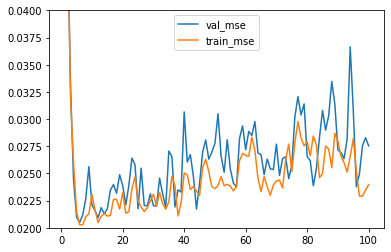

In [ ]:
model = Sequential()
model.add(Dense(nodes, activation=activation, input_shape=(X_train.shape[1],)))
if layers == 1:
  model.add(Dense(nodes, activation=activation))
elif layers == 2:
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
elif layers == 3:
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=['mse'])

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=100,
          verbose=1,
          validation_data=(X_val, y_val))

plt.plot(np.arange(1,101,1), np.array(history.history['val_mse']), np.arange(1,101,1), np.array(history.history['mse']))
plt.legend(['val_mse','train_mse'])
plt.rcParams['figure.figsize'] = [8,8]
plt.ylim([.02, 0.04])
plt.show()

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 29ms/step - loss: 0.9347 - mse: 0.9347 - val_loss: 0.0872 - val_mse: 0.0872
Epoch 2/50
10/10 [==============================] - 0s 11ms/step - loss: 0.1788 - mse: 0.1788 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 3/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0781 - mse: 0.0781 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 4/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 5/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 7/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 8/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0203 - mse: 0.0203 

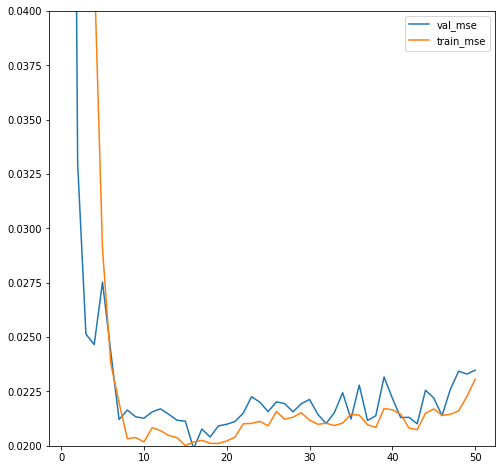

In [ ]:
model = Sequential()
model.add(Dense(nodes, activation=activation, input_shape=(X_train.shape[1],)))
if layers == 1:
  model.add(Dense(nodes, activation=activation))
elif layers == 2:
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
elif layers == 3:
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=['mse'])

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=50,
          verbose=1,
          validation_data=(X_val, y_val))

plt.plot(np.arange(1,51,1), np.array(history.history['val_mse']), np.arange(1,51,1), np.array(history.history['mse']))
plt.legend(['val_mse','train_mse'])
plt.rcParams['figure.figsize'] = [8,8]
plt.ylim([.015, 0.04])
plt.show()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
10/10 [==============================] - 3s 90ms/step - loss: 0.4710 - mse: 0.4710 - val_loss: 0.0947 - val_mse: 0.0947
Epoch 2/30
10/10 [==============================] - 0s 32ms/step - loss: 0.1278 - mse: 0.1278 - val_loss: 0.1122 - val_mse: 0.1122
Epoch 3/30
10/10 [==============================] - 0s 20ms/step - loss: 0.0687 - mse: 0.0687 - val_loss: 0.0694 - val_mse: 0.0694
Epoch 4/30
10/10 [==============================] - 0s 31ms/step - loss: 0.0396 - mse: 0.0396 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 5/30
10/10 [==============================] - 0s 33ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0258 - val_mse: 0.0258
Epoch 6/30
10/10 [==============================] - 0s 26ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 7/30
10/10 [==============================] - 0s 26ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 8/30
10/10 [==============================] - 0s 20ms/step - loss: 0.0204 - m

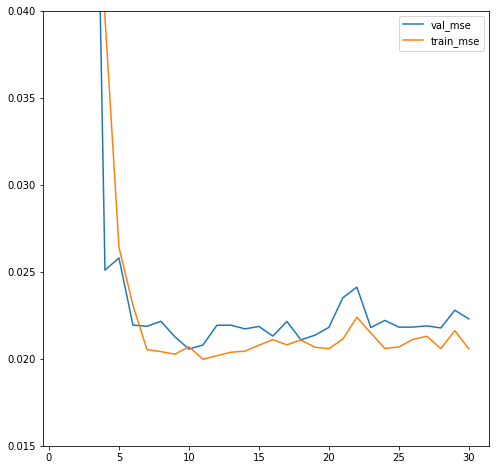

In [ ]:
model = Sequential()
model.add(Dense(nodes, activation=activation, input_shape=(X_train.shape[1],)))
if layers == 1:
  model.add(Dense(nodes, activation=activation))
elif layers == 2:
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
elif layers == 3:
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=['mse'])

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=1,
          validation_data=(X_val, y_val))

plt.plot(np.arange(1,31,1), np.array(history.history['val_mse']), np.arange(1,31,1), np.array(history.history['mse']))
plt.legend(['val_mse','train_mse'])
plt.rcParams['figure.figsize'] = [8,8]
plt.ylim([.015, 0.04])
plt.show()

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 109ms/step - loss: 0.1499 - mse: 0.1499 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 2/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 4/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 6/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 7/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 8/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0203 - mse: 0.0203

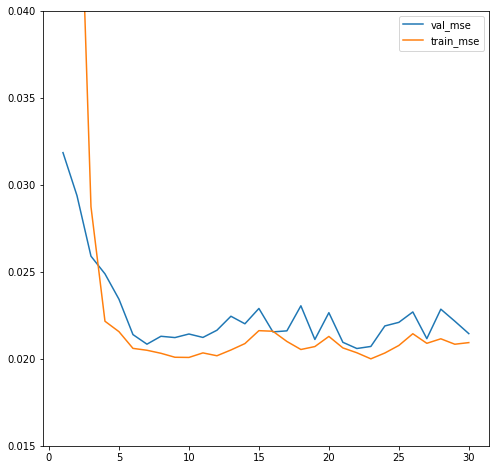

In [ ]:
model = Sequential()
model.add(Dense(nodes, activation=activation, input_shape=(X_train.shape[1],)))
if layers == 1:
  model.add(Dense(nodes, activation=activation))
elif layers == 2:
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
elif layers == 3:
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=['mse'])

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=1,
          validation_data=(X_val, y_val))

plt.plot(np.arange(1,31,1), np.array(history.history['val_mse']), np.arange(1,31,1), np.array(history.history['mse']))
plt.legend(['val_mse','train_mse'])
plt.rcParams['figure.figsize'] = [8,8]
plt.ylim([.015, 0.04])
plt.show()

The model is doing well at generalizing with 10 epochs. I will do 10-fold cross-validation as a final measure to ensure that training for this number of epochs does not carry a high chance of poor generalization, and to ensure that the average MSE is below the target MSE.

In [ ]:
X_cv = np.concatenate((X_train, X_val), axis=0)
y_cv = np.concatenate((y_train, y_val), axis=0)
cvscores = []

for train, test in kfold.split(X_cv, y_cv):
    model = Sequential()
    model.add(Dense(nodes, activation=activation, input_shape=(X_train.shape[1],)))
    if layers == 1:
      model.add(Dense(nodes, activation=activation))
    elif layers == 2:
      model.add(Dense(nodes, activation=activation))
      model.add(Dense(nodes, activation=activation))
    elif layers == 3:
      model.add(Dense(nodes, activation=activation))
      model.add(Dense(nodes, activation=activation))
      model.add(Dense(nodes, activation=activation))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=['mse'])
    # Train the model on the training data
    model.fit(X_cv[train], y_cv[train], epochs=10, batch_size=batch_size, verbose=0)
    
    # Evaluate the model on the validation data
    scores = model.evaluate(X_cv[test], y_cv[test], verbose=0)
    
    # Store the validation loss
    cvscores.append(scores[0])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


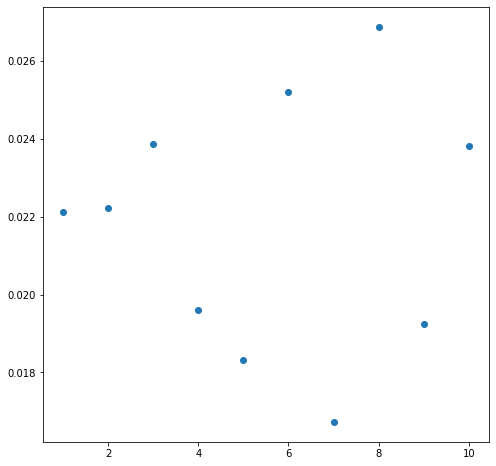

In [ ]:
plt.scatter(np.arange(1,11,1), cvscores)

In [ ]:
np.array(cvscores).mean()

0.021796085685491563

The model seems to be good at generalizing, and has an MSE that is beating our benchmark. My work here is done!

In [ ]:
model = Sequential()
model.add(Dense(nodes, activation=activation, input_shape=(X_train.shape[1],)))
if layers == 1:
  model.add(Dense(nodes, activation=activation))
elif layers == 2:
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
elif layers == 3:
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
  model.add(Dense(nodes, activation=activation))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=['mse'])
# Train the model on the training data
model.fit(X_cv, y_cv, epochs=10, batch_size=batch_size, verbose=0)


test_mse = model.evaluate(X_test, y_test, verbose=0)[0]
print("Test MSE:", test_mse)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Test MSE: 0.021013429388403893


11/11 [==============================] - 0s 4ms/step


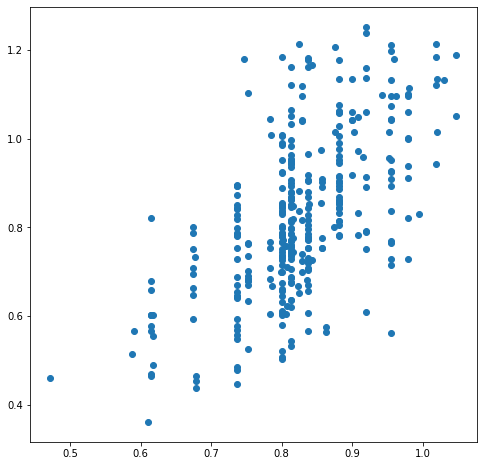

In [ ]:
plt.scatter(model.predict(X_test), y_test)